In [2]:
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of training dataset: 50000
Size of validation dataset: 10000


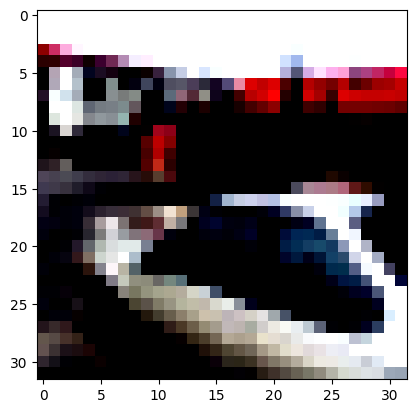

In [3]:
#Download CIFAR 10 dataset for training and validation purposes and apply the following changes on each image:
# 1) make it a tensor
# 2) normalize it based on the mean and standard deviation among all pixels in each channel (RGB).
#Print the size of training and validation datasets
#Plot the last training image

data_path = '../data-unversioned/p1ch7/'
t_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
t_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

# combine all images
imgs = torch.stack([img_t for img_t, _ in t_cifar10], dim=3) # training dataset images
imgs_val = torch.stack([img_t for img_t, _ in t_cifar10_val], dim=3) # validation dataset images

# # Computing mean per channel = 0.4914, 0.4822, 0.4465
# imgs_mean = imgs.view(3,-1).mean(dim=1) # (0.4914, 0.4822, 0.4465),
# # Computing std = 0.2470, 0.2435, 0.2616
# imgs_std = imgs.view(3, -1).std(dim=1) # (0.2470, 0.2435, 0.2616)
# print("imgs_mean", imgs_mean)
# print("imgs_std", imgs_std)

# # Computing mean per channel
# imgs_val_mean = imgs_val.view(3,-1).mean(dim=1) # [0.4914, 0.4822, 0.4465]
# # Computing std
# imgs_val_std = imgs_val.view(3, -1).std(dim=1) # [0.2470, 0.2435, 0.2616]
# print("imgs_val_mean", imgs_val_mean)
# print("imgs_val_std:", imgs_val_std)


# Normalize and transform datasets
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean = (0.4914, 0.4822, 0.4465),
                                                                std = (0.2470, 0.2435, 0.2616))
                                           ]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean = (0.4942, 0.4851, 0.4504),
                                                                std = (0.2467, 0.2429, 0.2616))
                                           ]))


print("Size of training dataset:", len(transformed_cifar10))
print("Size of validation dataset:", len(transformed_cifar10_val))

img_t, _ = transformed_cifar10[-1]
plt.imshow(img_t.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cifar2 size 15000
Cifar2_val size 3000


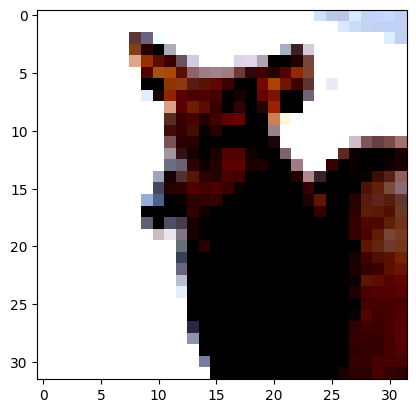

In [3]:
#We want to make a tertiary classifier that distinguishes between deers, dogs, and horses, labeled as 4, 5, and 7, resp.
#Create the subset training and validation datasets for this purpose.
#Print the size of these datasets.
#Plot the last training image

label_map = {4:0, 5:1, 7:2}
class_names = ["deers", "dogs", "horses"]
cifar2 = [(img, label_map[label])
    for img, label in transformed_cifar10
    if label in [4, 5, 7]]
cifar2_val = [(img, label_map[label])
    for img, label in transformed_cifar10_val
    if label in [4, 5, 7]]

print("Cifar2 size", len(cifar2))
print("Cifar2_val size", len(cifar2_val))

img_t, _ = cifar2[-1]
plt.imshow(img_t.permute(1, 2, 0))

In [4]:
###### Create a NN consisting of 
# 1) a linear layer that receives appropriate number of input features and outputs 1024 features, followed by hyperbolic
#    tangent as the activation function,
# 2) a linear layer that receives appropriate number of input features and outputs 256 features, followed by hyperbolic
#    tangent as the activation function,
# 3) the final linear layer with appropriate input and output number of features, followed by logarithm of softmax
#Print total number of exisiting parameters in the NN with respect to which gradient of loss must be computed.
model = nn.Sequential(
            nn.Linear(3072, 1024), #input = 32 x 32 x 3
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, 3),
            nn.LogSoftmax(dim=1))
    
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
parameters_num = sum(numel_list)
sum(numel_list), numel_list
print("The NN has a total of", parameters_num, "parameters")

The NN has a total of 3409923 parameters


In [5]:
#Our training functionality is supposed to compute gradient on batches of training data, randlomy selected each time.
#To this end, create a training data loader with batch size 32 that randomizes access to each batch.
#Also, create a validation data loader with the same batch size that does not randomize access to each batch (no need!)
#Print the number of batches in training and validation data loaders
#Print the size of the last batch in each of the training and validation loaders (they are not necessarily 32)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=32, shuffle=False)

print("Number of batches:")
print("- Training data loader: ", len(train_loader))
print("- Validation data loader: ", len(val_loader))
print()

print("Size of the last batch in:")
for img, label in train_loader:
    if img.shape[0] != 32:
        print("- Training data loader: ", img.shape[0])
        
for img, label in val_loader:
    if img.shape[0] != 32:
        print("- Validation data loader: ", img.shape[0])

Number of batches:
- Training data loader:  469
- Validation data loader:  94

Size of the last batch in:
- Training data loader:  24
- Validation data loader:  24


In [6]:
#Define your training function that receives the data loaders, model, loss function, optimizer, and number of epochs.
#In each epoch, you should go through each training data batch, and:
# 1) compute the output batch, and accordingly the loss
# 2) compute the gradient of loss wrt parameters, and update the parameters
#After covering all epochs, your training function must report
# 1) the training accuracy, and
# 2) the validation accuracy
import torch.optim as optim

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100


def training_loop(data_loader, model, loss_fn, optimizer, n_epochs):
    correct_train = 0
    total_train = 0
    for epoch in range(n_epochs):
        # go through each data batch
        for imgs, labels in data_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1)) # [32, 32, 32, 3] -> [32, 3072]
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
            
            # Compute Training Accuracy
            _, predicted = torch.max(outputs, dim=1)
            total_train += labels.shape[0]
            correct_train += int((predicted == labels).sum())
            
    print("Training Accuracy: ", correct_train / total_train)
            
            
    # Compute Validation Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
    print("Validation Accuracy: ", correct / total)



In [7]:
#Call the training function on the created data loaders, the created NN, negative log likelihood loss function, 
# stochastic gradient descent optimizer, and 100 epochs.
#Is the model overfit for this problem? (Yes/No) Why?
training_loop(
    data_loader = train_loader,
    model = model,
    loss_fn = nn.NLLLoss(),
    optimizer = optimizer,
    n_epochs = 100
)

'''
Yes, the model is overfit. We can notice that form the big difference in accuracy between the training
and validation accuracies. The model is able to classify the training data well by "memorizing the training
set", but once it is fed with new data that it has not seen before it cannot make predictions as accurate.
'''


Epoch: 0, Loss: 1.084375
Epoch: 0, Loss: 1.091258
Epoch: 0, Loss: 1.037183
Epoch: 0, Loss: 1.076848
Epoch: 0, Loss: 1.044265
Epoch: 0, Loss: 1.087346
Epoch: 0, Loss: 1.041792
Epoch: 0, Loss: 1.058017
Epoch: 0, Loss: 1.048267
Epoch: 0, Loss: 1.053097
Epoch: 0, Loss: 0.994188
Epoch: 0, Loss: 1.084724
Epoch: 0, Loss: 1.013487
Epoch: 0, Loss: 1.009389
Epoch: 0, Loss: 0.989202
Epoch: 0, Loss: 1.002903
Epoch: 0, Loss: 0.978213
Epoch: 0, Loss: 0.966532
Epoch: 0, Loss: 1.025277
Epoch: 0, Loss: 0.995671
Epoch: 0, Loss: 1.014939
Epoch: 0, Loss: 0.985143
Epoch: 0, Loss: 1.002669
Epoch: 0, Loss: 1.080849
Epoch: 0, Loss: 1.043174
Epoch: 0, Loss: 1.208737
Epoch: 0, Loss: 1.027390
Epoch: 0, Loss: 1.058355
Epoch: 0, Loss: 0.930350
Epoch: 0, Loss: 1.135008
Epoch: 0, Loss: 1.022662
Epoch: 0, Loss: 1.025500
Epoch: 0, Loss: 0.959618
Epoch: 0, Loss: 0.981237
Epoch: 0, Loss: 1.065328
Epoch: 0, Loss: 1.041098
Epoch: 0, Loss: 1.037260
Epoch: 0, Loss: 1.001081
Epoch: 0, Loss: 1.056290
Epoch: 0, Loss: 1.028930


Epoch: 0, Loss: 0.923049
Epoch: 0, Loss: 0.890854
Epoch: 0, Loss: 0.912675
Epoch: 0, Loss: 0.955112
Epoch: 0, Loss: 0.791512
Epoch: 0, Loss: 0.792462
Epoch: 0, Loss: 0.766735
Epoch: 0, Loss: 0.967868
Epoch: 0, Loss: 0.783044
Epoch: 0, Loss: 0.907272
Epoch: 0, Loss: 0.778412
Epoch: 0, Loss: 0.839787
Epoch: 0, Loss: 0.896799
Epoch: 0, Loss: 0.975883
Epoch: 0, Loss: 0.938070
Epoch: 0, Loss: 0.896084
Epoch: 0, Loss: 0.859358
Epoch: 0, Loss: 1.034724
Epoch: 0, Loss: 1.035576
Epoch: 0, Loss: 0.860842
Epoch: 0, Loss: 0.833298
Epoch: 0, Loss: 0.908932
Epoch: 0, Loss: 0.812323
Epoch: 0, Loss: 0.891672
Epoch: 0, Loss: 0.869313
Epoch: 0, Loss: 0.836589
Epoch: 0, Loss: 0.726181
Epoch: 0, Loss: 0.844195
Epoch: 0, Loss: 0.916902
Epoch: 0, Loss: 0.808734
Epoch: 0, Loss: 0.816675
Epoch: 0, Loss: 0.895614
Epoch: 0, Loss: 0.892582
Epoch: 0, Loss: 0.955085
Epoch: 0, Loss: 0.971192
Epoch: 0, Loss: 0.828122
Epoch: 0, Loss: 0.893378
Epoch: 0, Loss: 0.987936
Epoch: 0, Loss: 0.933567
Epoch: 0, Loss: 0.965910


Epoch: 1, Loss: 0.816965
Epoch: 1, Loss: 0.882261
Epoch: 1, Loss: 0.883018
Epoch: 1, Loss: 0.956457
Epoch: 1, Loss: 0.918010
Epoch: 1, Loss: 0.926858
Epoch: 1, Loss: 0.821298
Epoch: 1, Loss: 0.855448
Epoch: 1, Loss: 0.966635
Epoch: 1, Loss: 0.874729
Epoch: 1, Loss: 0.867308
Epoch: 1, Loss: 0.783996
Epoch: 1, Loss: 1.001687
Epoch: 1, Loss: 1.061712
Epoch: 1, Loss: 0.918315
Epoch: 1, Loss: 0.993496
Epoch: 1, Loss: 0.926540
Epoch: 1, Loss: 0.787699
Epoch: 1, Loss: 0.926833
Epoch: 1, Loss: 0.912943
Epoch: 1, Loss: 0.845632
Epoch: 1, Loss: 0.716060
Epoch: 1, Loss: 0.797614
Epoch: 1, Loss: 0.767711
Epoch: 1, Loss: 0.872902
Epoch: 1, Loss: 0.949371
Epoch: 1, Loss: 0.825304
Epoch: 1, Loss: 0.911563
Epoch: 1, Loss: 1.052460
Epoch: 1, Loss: 0.819462
Epoch: 1, Loss: 0.953288
Epoch: 1, Loss: 0.733361
Epoch: 1, Loss: 0.831221
Epoch: 1, Loss: 0.953533
Epoch: 1, Loss: 0.923527
Epoch: 1, Loss: 0.874270
Epoch: 1, Loss: 0.911213
Epoch: 1, Loss: 0.748834
Epoch: 1, Loss: 1.230910
Epoch: 1, Loss: 0.889466


Epoch: 2, Loss: 0.871044
Epoch: 2, Loss: 0.736384
Epoch: 2, Loss: 0.994257
Epoch: 2, Loss: 0.735964
Epoch: 2, Loss: 0.921240
Epoch: 2, Loss: 0.971351
Epoch: 2, Loss: 1.045159
Epoch: 2, Loss: 0.917482
Epoch: 2, Loss: 0.810318
Epoch: 2, Loss: 0.790300
Epoch: 2, Loss: 0.844461
Epoch: 2, Loss: 0.685381
Epoch: 2, Loss: 0.860213
Epoch: 2, Loss: 0.845546
Epoch: 2, Loss: 0.841194
Epoch: 2, Loss: 0.751981
Epoch: 2, Loss: 0.712092
Epoch: 2, Loss: 0.764171
Epoch: 2, Loss: 0.504187
Epoch: 2, Loss: 0.772459
Epoch: 2, Loss: 1.045250
Epoch: 2, Loss: 0.822301
Epoch: 2, Loss: 0.955767
Epoch: 2, Loss: 1.161176
Epoch: 2, Loss: 0.868058
Epoch: 2, Loss: 0.724347
Epoch: 2, Loss: 0.816797
Epoch: 2, Loss: 0.846899
Epoch: 2, Loss: 0.936373
Epoch: 2, Loss: 0.916462
Epoch: 2, Loss: 1.017253
Epoch: 2, Loss: 0.824576
Epoch: 2, Loss: 0.706423
Epoch: 2, Loss: 0.780270
Epoch: 2, Loss: 0.756713
Epoch: 2, Loss: 0.724237
Epoch: 2, Loss: 0.794448
Epoch: 2, Loss: 0.868003
Epoch: 2, Loss: 0.990731
Epoch: 2, Loss: 0.784938


Epoch: 2, Loss: 0.903695
Epoch: 2, Loss: 0.854194
Epoch: 2, Loss: 0.756900
Epoch: 2, Loss: 1.117727
Epoch: 2, Loss: 0.693895
Epoch: 2, Loss: 0.651923
Epoch: 2, Loss: 0.948012
Epoch: 2, Loss: 0.884026
Epoch: 2, Loss: 0.754462
Epoch: 2, Loss: 0.677520
Epoch: 2, Loss: 0.862899
Epoch: 2, Loss: 0.885191
Epoch: 2, Loss: 0.780704
Epoch: 2, Loss: 0.863446
Epoch: 2, Loss: 0.940241
Epoch: 2, Loss: 0.974543
Epoch: 2, Loss: 0.747819
Epoch: 2, Loss: 0.941877
Epoch: 2, Loss: 0.822610
Epoch: 2, Loss: 0.683442
Epoch: 2, Loss: 0.553352
Epoch: 2, Loss: 0.748768
Epoch: 2, Loss: 0.801593
Epoch: 2, Loss: 0.683189
Epoch: 2, Loss: 0.846459
Epoch: 2, Loss: 0.929604
Epoch: 2, Loss: 0.729842
Epoch: 2, Loss: 0.849297
Epoch: 2, Loss: 0.795762
Epoch: 2, Loss: 0.883280
Epoch: 2, Loss: 0.783498
Epoch: 2, Loss: 0.709479
Epoch: 2, Loss: 0.963724
Epoch: 2, Loss: 0.789847
Epoch: 2, Loss: 0.811751
Epoch: 2, Loss: 0.980679
Epoch: 2, Loss: 0.807385
Epoch: 2, Loss: 0.755204
Epoch: 2, Loss: 0.929301
Epoch: 2, Loss: 1.038106


Epoch: 3, Loss: 0.907595
Epoch: 3, Loss: 0.721862
Epoch: 3, Loss: 0.633237
Epoch: 3, Loss: 0.914276
Epoch: 3, Loss: 0.862253
Epoch: 3, Loss: 0.702924
Epoch: 3, Loss: 0.798934
Epoch: 3, Loss: 0.779715
Epoch: 3, Loss: 0.615063
Epoch: 3, Loss: 0.773999
Epoch: 3, Loss: 0.839171
Epoch: 3, Loss: 0.956292
Epoch: 3, Loss: 0.783057
Epoch: 3, Loss: 0.937740
Epoch: 3, Loss: 0.893105
Epoch: 3, Loss: 0.792869
Epoch: 3, Loss: 0.779557
Epoch: 3, Loss: 0.802928
Epoch: 3, Loss: 0.720922
Epoch: 3, Loss: 0.692349
Epoch: 3, Loss: 0.932247
Epoch: 3, Loss: 0.605015
Epoch: 3, Loss: 0.875736
Epoch: 3, Loss: 0.578491
Epoch: 3, Loss: 0.627990
Epoch: 3, Loss: 0.801591
Epoch: 3, Loss: 1.092380
Epoch: 3, Loss: 0.663257
Epoch: 3, Loss: 0.708038
Epoch: 3, Loss: 1.115010
Epoch: 3, Loss: 0.887904
Epoch: 3, Loss: 0.811023
Epoch: 3, Loss: 0.843232
Epoch: 3, Loss: 0.868183
Epoch: 3, Loss: 0.817117
Epoch: 3, Loss: 0.784395
Epoch: 3, Loss: 0.598414
Epoch: 3, Loss: 0.635054
Epoch: 3, Loss: 0.678779
Epoch: 3, Loss: 0.923024


Epoch: 4, Loss: 0.943183
Epoch: 4, Loss: 0.802195
Epoch: 4, Loss: 0.927785
Epoch: 4, Loss: 0.741484
Epoch: 4, Loss: 0.875019
Epoch: 4, Loss: 0.845535
Epoch: 4, Loss: 0.854900
Epoch: 4, Loss: 0.776675
Epoch: 4, Loss: 0.874767
Epoch: 4, Loss: 0.708302
Epoch: 4, Loss: 0.991204
Epoch: 4, Loss: 0.857020
Epoch: 4, Loss: 0.725203
Epoch: 4, Loss: 0.650128
Epoch: 4, Loss: 0.613627
Epoch: 4, Loss: 0.979036
Epoch: 4, Loss: 0.679942
Epoch: 4, Loss: 0.930414
Epoch: 4, Loss: 0.676343
Epoch: 4, Loss: 0.652660
Epoch: 4, Loss: 1.032633
Epoch: 4, Loss: 0.901151
Epoch: 4, Loss: 0.744519
Epoch: 4, Loss: 0.840333
Epoch: 4, Loss: 0.607324
Epoch: 4, Loss: 0.871541
Epoch: 4, Loss: 0.627410
Epoch: 4, Loss: 0.616899
Epoch: 4, Loss: 0.561176
Epoch: 4, Loss: 0.824090
Epoch: 4, Loss: 0.981676
Epoch: 4, Loss: 0.669127
Epoch: 4, Loss: 0.718654
Epoch: 4, Loss: 0.854902
Epoch: 4, Loss: 0.979611
Epoch: 4, Loss: 0.813755
Epoch: 4, Loss: 0.724616
Epoch: 4, Loss: 0.788202
Epoch: 4, Loss: 0.941376
Epoch: 4, Loss: 0.664029


Epoch: 4, Loss: 0.586483
Epoch: 4, Loss: 0.639050
Epoch: 4, Loss: 0.782944
Epoch: 4, Loss: 0.817916
Epoch: 4, Loss: 0.999796
Epoch: 4, Loss: 0.861998
Epoch: 4, Loss: 0.804734
Epoch: 4, Loss: 0.808745
Epoch: 4, Loss: 0.959845
Epoch: 4, Loss: 0.778053
Epoch: 4, Loss: 1.016786
Epoch: 4, Loss: 0.838185
Epoch: 4, Loss: 0.926624
Epoch: 4, Loss: 0.798153
Epoch: 4, Loss: 0.978021
Epoch: 4, Loss: 0.830078
Epoch: 4, Loss: 0.717139
Epoch: 4, Loss: 1.199762
Epoch: 4, Loss: 0.997185
Epoch: 4, Loss: 0.656003
Epoch: 4, Loss: 0.936148
Epoch: 4, Loss: 0.667521
Epoch: 4, Loss: 1.049121
Epoch: 4, Loss: 0.873011
Epoch: 4, Loss: 0.779841
Epoch: 4, Loss: 0.845614
Epoch: 4, Loss: 0.793710
Epoch: 4, Loss: 0.719824
Epoch: 4, Loss: 0.567168
Epoch: 4, Loss: 0.782527
Epoch: 4, Loss: 0.662442
Epoch: 4, Loss: 0.630876
Epoch: 4, Loss: 0.574132
Epoch: 4, Loss: 0.820766
Epoch: 4, Loss: 0.886855
Epoch: 4, Loss: 0.729338
Epoch: 4, Loss: 0.793345
Epoch: 4, Loss: 0.705868
Epoch: 4, Loss: 0.776037
Epoch: 4, Loss: 0.993346


Epoch: 5, Loss: 0.797233
Epoch: 5, Loss: 0.722414
Epoch: 5, Loss: 0.884982
Epoch: 5, Loss: 0.837217
Epoch: 5, Loss: 0.730008
Epoch: 5, Loss: 0.694046
Epoch: 5, Loss: 0.795067
Epoch: 5, Loss: 0.690819
Epoch: 5, Loss: 0.611528
Epoch: 5, Loss: 0.571872
Epoch: 5, Loss: 0.781911
Epoch: 5, Loss: 0.774092
Epoch: 5, Loss: 0.902256
Epoch: 5, Loss: 0.789158
Epoch: 5, Loss: 0.982862
Epoch: 5, Loss: 0.758528
Epoch: 5, Loss: 0.753646
Epoch: 5, Loss: 0.713148
Epoch: 5, Loss: 0.807330
Epoch: 5, Loss: 0.995646
Epoch: 5, Loss: 0.929855
Epoch: 5, Loss: 0.667218
Epoch: 5, Loss: 0.793136
Epoch: 5, Loss: 1.037377
Epoch: 5, Loss: 0.735828
Epoch: 5, Loss: 0.800725
Epoch: 5, Loss: 0.718712
Epoch: 5, Loss: 0.724587
Epoch: 5, Loss: 0.670466
Epoch: 5, Loss: 0.723481
Epoch: 5, Loss: 0.664870
Epoch: 5, Loss: 0.742487
Epoch: 5, Loss: 0.644576
Epoch: 5, Loss: 0.613167
Epoch: 5, Loss: 0.825574
Epoch: 5, Loss: 0.579162
Epoch: 5, Loss: 0.779656
Epoch: 5, Loss: 0.859644
Epoch: 5, Loss: 0.685439
Epoch: 5, Loss: 0.578506


Epoch: 6, Loss: 0.664465
Epoch: 6, Loss: 0.498652
Epoch: 6, Loss: 0.658529
Epoch: 6, Loss: 0.550258
Epoch: 6, Loss: 0.795856
Epoch: 6, Loss: 0.853375
Epoch: 6, Loss: 0.595621
Epoch: 6, Loss: 0.673625
Epoch: 6, Loss: 0.618774
Epoch: 6, Loss: 0.483652
Epoch: 6, Loss: 0.818696
Epoch: 6, Loss: 0.814457
Epoch: 6, Loss: 0.898322
Epoch: 6, Loss: 0.784999
Epoch: 6, Loss: 0.777441
Epoch: 6, Loss: 0.815914
Epoch: 6, Loss: 0.700158
Epoch: 6, Loss: 0.556604
Epoch: 6, Loss: 0.771119
Epoch: 6, Loss: 0.952145
Epoch: 6, Loss: 0.857015
Epoch: 6, Loss: 0.711979
Epoch: 6, Loss: 0.734925
Epoch: 6, Loss: 0.688156
Epoch: 6, Loss: 0.613508
Epoch: 6, Loss: 0.776638
Epoch: 6, Loss: 0.602895
Epoch: 6, Loss: 0.686484
Epoch: 6, Loss: 0.644140
Epoch: 6, Loss: 0.570985
Epoch: 6, Loss: 0.639584
Epoch: 6, Loss: 0.836038
Epoch: 6, Loss: 0.589323
Epoch: 6, Loss: 0.499116
Epoch: 6, Loss: 0.836464
Epoch: 6, Loss: 0.859516
Epoch: 6, Loss: 0.651651
Epoch: 6, Loss: 0.668181
Epoch: 6, Loss: 0.634635
Epoch: 6, Loss: 0.754888


Epoch: 7, Loss: 0.646066
Epoch: 7, Loss: 0.640053
Epoch: 7, Loss: 0.894815
Epoch: 7, Loss: 0.800296
Epoch: 7, Loss: 0.559099
Epoch: 7, Loss: 0.591567
Epoch: 7, Loss: 0.611269
Epoch: 7, Loss: 0.644681
Epoch: 7, Loss: 0.552146
Epoch: 7, Loss: 0.567913
Epoch: 7, Loss: 0.626267
Epoch: 7, Loss: 0.665748
Epoch: 7, Loss: 0.679966
Epoch: 7, Loss: 0.740941
Epoch: 7, Loss: 0.615472
Epoch: 7, Loss: 0.836586
Epoch: 7, Loss: 0.557375
Epoch: 7, Loss: 0.728348
Epoch: 7, Loss: 0.540352
Epoch: 7, Loss: 0.684824
Epoch: 7, Loss: 0.839353
Epoch: 7, Loss: 0.577369
Epoch: 7, Loss: 0.696902
Epoch: 7, Loss: 0.618560
Epoch: 7, Loss: 0.496753
Epoch: 7, Loss: 0.702140
Epoch: 7, Loss: 0.599957
Epoch: 7, Loss: 0.477854
Epoch: 7, Loss: 0.624955
Epoch: 7, Loss: 0.637726
Epoch: 7, Loss: 0.807916
Epoch: 7, Loss: 0.770466
Epoch: 7, Loss: 0.794118
Epoch: 7, Loss: 0.859205
Epoch: 7, Loss: 0.781350
Epoch: 7, Loss: 0.507727
Epoch: 7, Loss: 0.643143
Epoch: 7, Loss: 0.582667
Epoch: 7, Loss: 0.661417
Epoch: 7, Loss: 0.481361


Epoch: 7, Loss: 0.691052
Epoch: 7, Loss: 0.813860
Epoch: 7, Loss: 0.796299
Epoch: 7, Loss: 0.648907
Epoch: 7, Loss: 0.435782
Epoch: 7, Loss: 0.756432
Epoch: 7, Loss: 0.614495
Epoch: 7, Loss: 0.702301
Epoch: 7, Loss: 0.993052
Epoch: 7, Loss: 0.870649
Epoch: 7, Loss: 0.578274
Epoch: 7, Loss: 0.725832
Epoch: 7, Loss: 0.513658
Epoch: 7, Loss: 0.672358
Epoch: 7, Loss: 0.728500
Epoch: 7, Loss: 0.679453
Epoch: 7, Loss: 0.730184
Epoch: 7, Loss: 0.637511
Epoch: 7, Loss: 0.486520
Epoch: 7, Loss: 0.829363
Epoch: 7, Loss: 0.651223
Epoch: 7, Loss: 0.677149
Epoch: 7, Loss: 0.706140
Epoch: 7, Loss: 0.670785
Epoch: 7, Loss: 0.911749
Epoch: 7, Loss: 0.790306
Epoch: 7, Loss: 0.640576
Epoch: 7, Loss: 0.635643
Epoch: 7, Loss: 0.655841
Epoch: 7, Loss: 0.635931
Epoch: 7, Loss: 0.784294
Epoch: 7, Loss: 0.529808
Epoch: 7, Loss: 0.640764
Epoch: 7, Loss: 0.670399
Epoch: 7, Loss: 0.751475
Epoch: 7, Loss: 0.731803
Epoch: 7, Loss: 0.550409
Epoch: 7, Loss: 0.704011
Epoch: 7, Loss: 0.837370
Epoch: 7, Loss: 0.800279


Epoch: 8, Loss: 0.603727
Epoch: 8, Loss: 0.537160
Epoch: 8, Loss: 0.446030
Epoch: 8, Loss: 0.407790
Epoch: 8, Loss: 0.784779
Epoch: 8, Loss: 0.717090
Epoch: 8, Loss: 0.564008
Epoch: 8, Loss: 0.456276
Epoch: 8, Loss: 0.558454
Epoch: 8, Loss: 0.757424
Epoch: 8, Loss: 0.716158
Epoch: 8, Loss: 0.665302
Epoch: 8, Loss: 0.747273
Epoch: 8, Loss: 0.838641
Epoch: 8, Loss: 0.600605
Epoch: 8, Loss: 0.735619
Epoch: 8, Loss: 0.682209
Epoch: 8, Loss: 0.571081
Epoch: 8, Loss: 0.711895
Epoch: 8, Loss: 0.601747
Epoch: 8, Loss: 0.697131
Epoch: 8, Loss: 0.612128
Epoch: 8, Loss: 0.743636
Epoch: 8, Loss: 0.669063
Epoch: 8, Loss: 0.455874
Epoch: 8, Loss: 0.931469
Epoch: 8, Loss: 0.674493
Epoch: 8, Loss: 0.522130
Epoch: 8, Loss: 0.748371
Epoch: 8, Loss: 0.742717
Epoch: 8, Loss: 0.648431
Epoch: 8, Loss: 0.673798
Epoch: 8, Loss: 0.736176
Epoch: 8, Loss: 0.706257
Epoch: 8, Loss: 0.958582
Epoch: 8, Loss: 0.546991
Epoch: 8, Loss: 0.680445
Epoch: 8, Loss: 0.724195
Epoch: 8, Loss: 0.583084
Epoch: 8, Loss: 0.746473


Epoch: 9, Loss: 0.534036
Epoch: 9, Loss: 0.553113
Epoch: 9, Loss: 0.345696
Epoch: 9, Loss: 0.581821
Epoch: 9, Loss: 0.700307
Epoch: 9, Loss: 0.804748
Epoch: 9, Loss: 0.672226
Epoch: 9, Loss: 0.825155
Epoch: 9, Loss: 0.616270
Epoch: 9, Loss: 0.497864
Epoch: 9, Loss: 0.578106
Epoch: 9, Loss: 0.744870
Epoch: 9, Loss: 0.758673
Epoch: 9, Loss: 0.674781
Epoch: 9, Loss: 0.655146
Epoch: 9, Loss: 0.517838
Epoch: 9, Loss: 0.538302
Epoch: 9, Loss: 0.579666
Epoch: 9, Loss: 0.616884
Epoch: 9, Loss: 0.465692
Epoch: 9, Loss: 0.641167
Epoch: 9, Loss: 0.937790
Epoch: 9, Loss: 0.550242
Epoch: 9, Loss: 0.627501
Epoch: 9, Loss: 0.568122
Epoch: 9, Loss: 0.471968
Epoch: 9, Loss: 0.534263
Epoch: 9, Loss: 0.481339
Epoch: 9, Loss: 0.557836
Epoch: 9, Loss: 0.674820
Epoch: 9, Loss: 0.578667
Epoch: 9, Loss: 0.532288
Epoch: 9, Loss: 0.492490
Epoch: 9, Loss: 0.640831
Epoch: 9, Loss: 0.785118
Epoch: 9, Loss: 0.557193
Epoch: 9, Loss: 0.706179
Epoch: 9, Loss: 0.493100
Epoch: 9, Loss: 0.639061
Epoch: 9, Loss: 0.717223


Epoch: 9, Loss: 0.614902
Epoch: 9, Loss: 0.623873
Epoch: 9, Loss: 0.584849
Epoch: 9, Loss: 0.816642
Epoch: 9, Loss: 0.465083
Epoch: 9, Loss: 0.669629
Epoch: 9, Loss: 0.801206
Epoch: 9, Loss: 0.622049
Epoch: 9, Loss: 0.597057
Epoch: 9, Loss: 0.615004
Epoch: 9, Loss: 0.768465
Epoch: 9, Loss: 0.622839
Epoch: 9, Loss: 0.668577
Epoch: 9, Loss: 0.652354
Epoch: 9, Loss: 0.867203
Epoch: 9, Loss: 0.773333
Epoch: 9, Loss: 0.849773
Epoch: 9, Loss: 0.518578
Epoch: 9, Loss: 0.784636
Epoch: 9, Loss: 0.708280
Epoch: 9, Loss: 0.541862
Epoch: 9, Loss: 0.489202
Epoch: 9, Loss: 0.713284
Epoch: 9, Loss: 0.922227
Epoch: 9, Loss: 0.519958
Epoch: 9, Loss: 0.592930
Epoch: 9, Loss: 0.471315
Epoch: 9, Loss: 0.660632
Epoch: 9, Loss: 0.871626
Epoch: 9, Loss: 0.624094
Epoch: 9, Loss: 1.058785
Epoch: 9, Loss: 0.542950
Epoch: 9, Loss: 0.690940
Epoch: 9, Loss: 0.539710
Epoch: 9, Loss: 0.616200
Epoch: 9, Loss: 0.571339
Epoch: 9, Loss: 0.701720
Epoch: 9, Loss: 0.506515
Epoch: 9, Loss: 0.783656
Epoch: 9, Loss: 0.392540


Epoch: 10, Loss: 0.526194
Epoch: 10, Loss: 0.651518
Epoch: 10, Loss: 0.526553
Epoch: 10, Loss: 0.695369
Epoch: 10, Loss: 0.667651
Epoch: 10, Loss: 0.685577
Epoch: 10, Loss: 0.691484
Epoch: 10, Loss: 0.541879
Epoch: 10, Loss: 0.526656
Epoch: 10, Loss: 0.801294
Epoch: 10, Loss: 0.581005
Epoch: 10, Loss: 0.636036
Epoch: 10, Loss: 0.510813
Epoch: 10, Loss: 0.682344
Epoch: 10, Loss: 0.671201
Epoch: 10, Loss: 0.671753
Epoch: 10, Loss: 0.847365
Epoch: 10, Loss: 0.538260
Epoch: 10, Loss: 0.562834
Epoch: 10, Loss: 0.752990
Epoch: 10, Loss: 0.479577
Epoch: 10, Loss: 0.612326
Epoch: 10, Loss: 0.786975
Epoch: 10, Loss: 0.901780
Epoch: 10, Loss: 0.542801
Epoch: 10, Loss: 0.572903
Epoch: 10, Loss: 0.571916
Epoch: 10, Loss: 0.721271
Epoch: 10, Loss: 0.697344
Epoch: 10, Loss: 0.692345
Epoch: 10, Loss: 0.516031
Epoch: 10, Loss: 0.486410
Epoch: 10, Loss: 0.498209
Epoch: 10, Loss: 0.810138
Epoch: 10, Loss: 0.660551
Epoch: 10, Loss: 0.665679
Epoch: 10, Loss: 0.553642
Epoch: 10, Loss: 0.694079
Epoch: 10, L

Epoch: 11, Loss: 0.472735
Epoch: 11, Loss: 0.589678
Epoch: 11, Loss: 0.579494
Epoch: 11, Loss: 0.610077
Epoch: 11, Loss: 0.493660
Epoch: 11, Loss: 0.694073
Epoch: 11, Loss: 0.834244
Epoch: 11, Loss: 0.735859
Epoch: 11, Loss: 0.955856
Epoch: 11, Loss: 0.568257
Epoch: 11, Loss: 0.613287
Epoch: 11, Loss: 0.637277
Epoch: 11, Loss: 0.606391
Epoch: 11, Loss: 0.373566
Epoch: 11, Loss: 0.704470
Epoch: 11, Loss: 0.614230
Epoch: 11, Loss: 0.665487
Epoch: 11, Loss: 0.470553
Epoch: 11, Loss: 0.452154
Epoch: 11, Loss: 0.453314
Epoch: 11, Loss: 0.481732
Epoch: 11, Loss: 0.623286
Epoch: 11, Loss: 0.461243
Epoch: 11, Loss: 0.574885
Epoch: 11, Loss: 0.549487
Epoch: 11, Loss: 0.534425
Epoch: 11, Loss: 0.408154
Epoch: 11, Loss: 0.597877
Epoch: 11, Loss: 0.622621
Epoch: 11, Loss: 0.595913
Epoch: 11, Loss: 0.707189
Epoch: 11, Loss: 0.772547
Epoch: 11, Loss: 0.534046
Epoch: 11, Loss: 0.485445
Epoch: 11, Loss: 0.514859
Epoch: 11, Loss: 0.450625
Epoch: 11, Loss: 0.584504
Epoch: 11, Loss: 0.714318
Epoch: 11, L

Epoch: 11, Loss: 0.398692
Epoch: 11, Loss: 0.683048
Epoch: 11, Loss: 0.549358
Epoch: 11, Loss: 0.645099
Epoch: 11, Loss: 0.549216
Epoch: 11, Loss: 0.711658
Epoch: 11, Loss: 0.607894
Epoch: 11, Loss: 0.695614
Epoch: 11, Loss: 0.550340
Epoch: 11, Loss: 0.400989
Epoch: 12, Loss: 0.576116
Epoch: 12, Loss: 0.426757
Epoch: 12, Loss: 0.387442
Epoch: 12, Loss: 0.617079
Epoch: 12, Loss: 0.603729
Epoch: 12, Loss: 0.612602
Epoch: 12, Loss: 0.618237
Epoch: 12, Loss: 0.486940
Epoch: 12, Loss: 0.891017
Epoch: 12, Loss: 0.492365
Epoch: 12, Loss: 0.552970
Epoch: 12, Loss: 0.645923
Epoch: 12, Loss: 0.438789
Epoch: 12, Loss: 0.530953
Epoch: 12, Loss: 0.576726
Epoch: 12, Loss: 0.469499
Epoch: 12, Loss: 0.444114
Epoch: 12, Loss: 0.513672
Epoch: 12, Loss: 0.403607
Epoch: 12, Loss: 0.662378
Epoch: 12, Loss: 0.609337
Epoch: 12, Loss: 0.685024
Epoch: 12, Loss: 0.403749
Epoch: 12, Loss: 0.376138
Epoch: 12, Loss: 0.678247
Epoch: 12, Loss: 0.456140
Epoch: 12, Loss: 0.222275
Epoch: 12, Loss: 0.434367
Epoch: 12, L

Epoch: 12, Loss: 0.488755
Epoch: 12, Loss: 0.756155
Epoch: 12, Loss: 0.856124
Epoch: 12, Loss: 0.432746
Epoch: 12, Loss: 0.657671
Epoch: 12, Loss: 0.610129
Epoch: 12, Loss: 0.501799
Epoch: 12, Loss: 0.676087
Epoch: 12, Loss: 0.702540
Epoch: 12, Loss: 0.405574
Epoch: 12, Loss: 0.574200
Epoch: 12, Loss: 0.441567
Epoch: 12, Loss: 0.662610
Epoch: 12, Loss: 0.651745
Epoch: 12, Loss: 0.556319
Epoch: 12, Loss: 0.466582
Epoch: 12, Loss: 0.556697
Epoch: 12, Loss: 0.635494
Epoch: 12, Loss: 0.518324
Epoch: 12, Loss: 0.448964
Epoch: 12, Loss: 0.615327
Epoch: 12, Loss: 0.627254
Epoch: 12, Loss: 0.811382
Epoch: 12, Loss: 0.753226
Epoch: 12, Loss: 0.821748
Epoch: 12, Loss: 0.591858
Epoch: 12, Loss: 0.593936
Epoch: 12, Loss: 0.408578
Epoch: 12, Loss: 0.511272
Epoch: 12, Loss: 0.374852
Epoch: 12, Loss: 0.533858
Epoch: 12, Loss: 0.729402
Epoch: 12, Loss: 0.512288
Epoch: 12, Loss: 0.659116
Epoch: 12, Loss: 0.708558
Epoch: 12, Loss: 0.598292
Epoch: 12, Loss: 0.515248
Epoch: 12, Loss: 0.553644
Epoch: 12, L

Epoch: 13, Loss: 0.348149
Epoch: 13, Loss: 0.664436
Epoch: 13, Loss: 0.677115
Epoch: 13, Loss: 0.370969
Epoch: 13, Loss: 0.415268
Epoch: 13, Loss: 0.462141
Epoch: 13, Loss: 0.570354
Epoch: 13, Loss: 0.457731
Epoch: 13, Loss: 0.464218
Epoch: 13, Loss: 0.485860
Epoch: 13, Loss: 0.531015
Epoch: 13, Loss: 0.536479
Epoch: 13, Loss: 0.630417
Epoch: 13, Loss: 0.470369
Epoch: 13, Loss: 0.701763
Epoch: 13, Loss: 0.423601
Epoch: 13, Loss: 0.398175
Epoch: 13, Loss: 0.566840
Epoch: 13, Loss: 0.277963
Epoch: 13, Loss: 0.391037
Epoch: 13, Loss: 0.630785
Epoch: 13, Loss: 0.421081
Epoch: 13, Loss: 0.311369
Epoch: 13, Loss: 0.335121
Epoch: 13, Loss: 0.704864
Epoch: 13, Loss: 0.602812
Epoch: 13, Loss: 0.549781
Epoch: 13, Loss: 0.566184
Epoch: 13, Loss: 0.543363
Epoch: 13, Loss: 0.412028
Epoch: 13, Loss: 0.755107
Epoch: 13, Loss: 0.553203
Epoch: 13, Loss: 0.577436
Epoch: 13, Loss: 0.418057
Epoch: 13, Loss: 0.521586
Epoch: 13, Loss: 0.447246
Epoch: 13, Loss: 0.578912
Epoch: 13, Loss: 0.481554
Epoch: 13, L

Epoch: 14, Loss: 0.628029
Epoch: 14, Loss: 0.273233
Epoch: 14, Loss: 0.337842
Epoch: 14, Loss: 0.429917
Epoch: 14, Loss: 0.438848
Epoch: 14, Loss: 0.383480
Epoch: 14, Loss: 0.359534
Epoch: 14, Loss: 0.644985
Epoch: 14, Loss: 0.677415
Epoch: 14, Loss: 0.329049
Epoch: 14, Loss: 0.343023
Epoch: 14, Loss: 0.534796
Epoch: 14, Loss: 0.506931
Epoch: 14, Loss: 0.553264
Epoch: 14, Loss: 0.446403
Epoch: 14, Loss: 0.313320
Epoch: 14, Loss: 0.604561
Epoch: 14, Loss: 0.241131
Epoch: 14, Loss: 0.401445
Epoch: 14, Loss: 0.343423
Epoch: 14, Loss: 0.347427
Epoch: 14, Loss: 0.431310
Epoch: 14, Loss: 0.423055
Epoch: 14, Loss: 0.335081
Epoch: 14, Loss: 0.541262
Epoch: 14, Loss: 0.615124
Epoch: 14, Loss: 0.539591
Epoch: 14, Loss: 0.653824
Epoch: 14, Loss: 0.432738
Epoch: 14, Loss: 0.486028
Epoch: 14, Loss: 0.454536
Epoch: 14, Loss: 0.430029
Epoch: 14, Loss: 0.534380
Epoch: 14, Loss: 0.541316
Epoch: 14, Loss: 0.338806
Epoch: 14, Loss: 0.604412
Epoch: 14, Loss: 0.463203
Epoch: 14, Loss: 0.287392
Epoch: 14, L

Epoch: 14, Loss: 0.551778
Epoch: 14, Loss: 0.484341
Epoch: 14, Loss: 0.418364
Epoch: 14, Loss: 0.483624
Epoch: 14, Loss: 0.584849
Epoch: 14, Loss: 0.286564
Epoch: 14, Loss: 0.402350
Epoch: 14, Loss: 0.439534
Epoch: 14, Loss: 0.395050
Epoch: 14, Loss: 0.737536
Epoch: 14, Loss: 0.482024
Epoch: 14, Loss: 0.454318
Epoch: 14, Loss: 0.345501
Epoch: 14, Loss: 0.474825
Epoch: 14, Loss: 0.505024
Epoch: 14, Loss: 0.498588
Epoch: 14, Loss: 0.721320
Epoch: 14, Loss: 0.563457
Epoch: 14, Loss: 0.632351
Epoch: 14, Loss: 0.764486
Epoch: 14, Loss: 0.782037
Epoch: 14, Loss: 0.816565
Epoch: 14, Loss: 0.422915
Epoch: 14, Loss: 0.527575
Epoch: 14, Loss: 0.651295
Epoch: 14, Loss: 0.499028
Epoch: 14, Loss: 0.414565
Epoch: 14, Loss: 0.417931
Epoch: 14, Loss: 0.460334
Epoch: 14, Loss: 0.538058
Epoch: 14, Loss: 0.656949
Epoch: 14, Loss: 0.322584
Epoch: 14, Loss: 0.774579
Epoch: 14, Loss: 0.669590
Epoch: 14, Loss: 0.419585
Epoch: 14, Loss: 0.608957
Epoch: 14, Loss: 0.444359
Epoch: 14, Loss: 0.278697
Epoch: 14, L

Epoch: 15, Loss: 0.405242
Epoch: 15, Loss: 0.954193
Epoch: 15, Loss: 0.437201
Epoch: 15, Loss: 0.277315
Epoch: 15, Loss: 0.341432
Epoch: 15, Loss: 0.533131
Epoch: 15, Loss: 0.203361
Epoch: 15, Loss: 0.402100
Epoch: 15, Loss: 0.587963
Epoch: 15, Loss: 0.306571
Epoch: 15, Loss: 0.669218
Epoch: 15, Loss: 0.900552
Epoch: 15, Loss: 0.708299
Epoch: 15, Loss: 0.459375
Epoch: 15, Loss: 0.350509
Epoch: 15, Loss: 0.632153
Epoch: 15, Loss: 0.440938
Epoch: 15, Loss: 0.347166
Epoch: 15, Loss: 0.511986
Epoch: 15, Loss: 0.454862
Epoch: 15, Loss: 0.449653
Epoch: 15, Loss: 0.605235
Epoch: 15, Loss: 0.528153
Epoch: 15, Loss: 0.449205
Epoch: 15, Loss: 0.502470
Epoch: 15, Loss: 0.465218
Epoch: 15, Loss: 0.343336
Epoch: 15, Loss: 0.444379
Epoch: 15, Loss: 0.520439
Epoch: 15, Loss: 0.432234
Epoch: 15, Loss: 0.503914
Epoch: 15, Loss: 0.382610
Epoch: 15, Loss: 0.256168
Epoch: 15, Loss: 0.467120
Epoch: 15, Loss: 0.453316
Epoch: 15, Loss: 0.336837
Epoch: 15, Loss: 0.352785
Epoch: 15, Loss: 0.404733
Epoch: 15, L

Epoch: 16, Loss: 0.338448
Epoch: 16, Loss: 0.427122
Epoch: 16, Loss: 0.323462
Epoch: 16, Loss: 0.428173
Epoch: 16, Loss: 0.364361
Epoch: 16, Loss: 0.413374
Epoch: 16, Loss: 0.319330
Epoch: 16, Loss: 0.258603
Epoch: 16, Loss: 0.295880
Epoch: 16, Loss: 0.229688
Epoch: 16, Loss: 0.532581
Epoch: 16, Loss: 0.542127
Epoch: 16, Loss: 0.404242
Epoch: 16, Loss: 0.335452
Epoch: 16, Loss: 0.446643
Epoch: 16, Loss: 0.560142
Epoch: 16, Loss: 0.547768
Epoch: 16, Loss: 0.573984
Epoch: 16, Loss: 0.528388
Epoch: 16, Loss: 0.239052
Epoch: 16, Loss: 0.327134
Epoch: 16, Loss: 0.368866
Epoch: 16, Loss: 0.393185
Epoch: 16, Loss: 0.315405
Epoch: 16, Loss: 0.446162
Epoch: 16, Loss: 0.460976
Epoch: 16, Loss: 0.473499
Epoch: 16, Loss: 0.517497
Epoch: 16, Loss: 0.480818
Epoch: 16, Loss: 0.465659
Epoch: 16, Loss: 0.376992
Epoch: 16, Loss: 0.373918
Epoch: 16, Loss: 0.404015
Epoch: 16, Loss: 0.317874
Epoch: 16, Loss: 0.479587
Epoch: 16, Loss: 0.372908
Epoch: 16, Loss: 0.571982
Epoch: 16, Loss: 0.495602
Epoch: 16, L

Epoch: 16, Loss: 0.587543
Epoch: 16, Loss: 0.457220
Epoch: 16, Loss: 0.310548
Epoch: 16, Loss: 0.535774
Epoch: 16, Loss: 0.431964
Epoch: 16, Loss: 0.508035
Epoch: 16, Loss: 0.325079
Epoch: 16, Loss: 0.262202
Epoch: 16, Loss: 0.419028
Epoch: 16, Loss: 0.478061
Epoch: 16, Loss: 0.410087
Epoch: 16, Loss: 0.493823
Epoch: 16, Loss: 0.377476
Epoch: 16, Loss: 0.380856
Epoch: 16, Loss: 0.346648
Epoch: 16, Loss: 0.433376
Epoch: 16, Loss: 0.537911
Epoch: 16, Loss: 0.708613
Epoch: 16, Loss: 0.368302
Epoch: 16, Loss: 0.446200
Epoch: 16, Loss: 0.322585
Epoch: 16, Loss: 0.245044
Epoch: 16, Loss: 0.532084
Epoch: 16, Loss: 0.280906
Epoch: 16, Loss: 0.602715
Epoch: 16, Loss: 0.320594
Epoch: 16, Loss: 0.580776
Epoch: 16, Loss: 0.427812
Epoch: 16, Loss: 0.687555
Epoch: 16, Loss: 0.587125
Epoch: 16, Loss: 0.464278
Epoch: 16, Loss: 0.261756
Epoch: 16, Loss: 0.422599
Epoch: 16, Loss: 0.293798
Epoch: 16, Loss: 0.339496
Epoch: 16, Loss: 0.353604
Epoch: 16, Loss: 0.370866
Epoch: 16, Loss: 0.290499
Epoch: 16, L

Epoch: 17, Loss: 0.457581
Epoch: 17, Loss: 0.371576
Epoch: 17, Loss: 0.373908
Epoch: 17, Loss: 0.438127
Epoch: 17, Loss: 0.236828
Epoch: 17, Loss: 0.211066
Epoch: 17, Loss: 0.347391
Epoch: 17, Loss: 0.314876
Epoch: 17, Loss: 0.401679
Epoch: 17, Loss: 0.357276
Epoch: 17, Loss: 0.452019
Epoch: 17, Loss: 0.329845
Epoch: 17, Loss: 0.367349
Epoch: 17, Loss: 0.456531
Epoch: 17, Loss: 0.604718
Epoch: 17, Loss: 0.595637
Epoch: 17, Loss: 0.340136
Epoch: 17, Loss: 0.525432
Epoch: 17, Loss: 0.355623
Epoch: 17, Loss: 0.336714
Epoch: 17, Loss: 0.395538
Epoch: 17, Loss: 0.554672
Epoch: 17, Loss: 0.341856
Epoch: 17, Loss: 0.470428
Epoch: 17, Loss: 0.265554
Epoch: 17, Loss: 0.533791
Epoch: 17, Loss: 0.427593
Epoch: 17, Loss: 0.420517
Epoch: 17, Loss: 0.306237
Epoch: 17, Loss: 0.350216
Epoch: 17, Loss: 0.259247
Epoch: 17, Loss: 0.314321
Epoch: 17, Loss: 0.432487
Epoch: 17, Loss: 0.391682
Epoch: 17, Loss: 0.477048
Epoch: 17, Loss: 0.288774
Epoch: 17, Loss: 0.422271
Epoch: 17, Loss: 0.254684
Epoch: 17, L

Epoch: 18, Loss: 0.247653
Epoch: 18, Loss: 0.360762
Epoch: 18, Loss: 0.264699
Epoch: 18, Loss: 0.345216
Epoch: 18, Loss: 0.363177
Epoch: 18, Loss: 0.524298
Epoch: 18, Loss: 0.331201
Epoch: 18, Loss: 0.294971
Epoch: 18, Loss: 0.334655
Epoch: 18, Loss: 0.360849
Epoch: 18, Loss: 0.495415
Epoch: 18, Loss: 0.247973
Epoch: 18, Loss: 0.342000
Epoch: 18, Loss: 0.228811
Epoch: 18, Loss: 0.334680
Epoch: 18, Loss: 0.316338
Epoch: 18, Loss: 0.327597
Epoch: 18, Loss: 0.399848
Epoch: 18, Loss: 0.345547
Epoch: 18, Loss: 0.406836
Epoch: 18, Loss: 0.388554
Epoch: 18, Loss: 0.414631
Epoch: 18, Loss: 0.342273
Epoch: 18, Loss: 0.385423
Epoch: 18, Loss: 0.483519
Epoch: 18, Loss: 0.235670
Epoch: 18, Loss: 0.311950
Epoch: 18, Loss: 0.391511
Epoch: 18, Loss: 0.276718
Epoch: 18, Loss: 0.340192
Epoch: 18, Loss: 0.148394
Epoch: 18, Loss: 0.211450
Epoch: 18, Loss: 0.192689
Epoch: 18, Loss: 0.380205
Epoch: 18, Loss: 0.321093
Epoch: 18, Loss: 0.246801
Epoch: 18, Loss: 0.315107
Epoch: 18, Loss: 0.509541
Epoch: 18, L

Epoch: 18, Loss: 0.170799
Epoch: 18, Loss: 0.418194
Epoch: 18, Loss: 0.440730
Epoch: 18, Loss: 0.553611
Epoch: 18, Loss: 0.477961
Epoch: 18, Loss: 0.567232
Epoch: 18, Loss: 0.479715
Epoch: 18, Loss: 0.431984
Epoch: 18, Loss: 0.482699
Epoch: 18, Loss: 0.348245
Epoch: 18, Loss: 0.131344
Epoch: 18, Loss: 0.349843
Epoch: 18, Loss: 0.257025
Epoch: 18, Loss: 0.319828
Epoch: 18, Loss: 0.537450
Epoch: 18, Loss: 0.298211
Epoch: 18, Loss: 0.428492
Epoch: 18, Loss: 0.281950
Epoch: 18, Loss: 0.337520
Epoch: 18, Loss: 0.593376
Epoch: 18, Loss: 0.554153
Epoch: 18, Loss: 0.554113
Epoch: 18, Loss: 0.525824
Epoch: 18, Loss: 0.394780
Epoch: 18, Loss: 0.219353
Epoch: 18, Loss: 0.390472
Epoch: 18, Loss: 0.438335
Epoch: 18, Loss: 0.321507
Epoch: 18, Loss: 0.324096
Epoch: 18, Loss: 0.250050
Epoch: 18, Loss: 0.402308
Epoch: 18, Loss: 0.309228
Epoch: 18, Loss: 0.227947
Epoch: 18, Loss: 0.224178
Epoch: 18, Loss: 0.344444
Epoch: 18, Loss: 0.385467
Epoch: 18, Loss: 0.336657
Epoch: 18, Loss: 0.250429
Epoch: 18, L

Epoch: 19, Loss: 0.431554
Epoch: 19, Loss: 0.296858
Epoch: 19, Loss: 0.178561
Epoch: 19, Loss: 0.198548
Epoch: 19, Loss: 0.401777
Epoch: 19, Loss: 0.500085
Epoch: 19, Loss: 0.110902
Epoch: 19, Loss: 0.266602
Epoch: 19, Loss: 0.235539
Epoch: 19, Loss: 0.179892
Epoch: 19, Loss: 0.464406
Epoch: 19, Loss: 0.273583
Epoch: 19, Loss: 0.240561
Epoch: 19, Loss: 0.520409
Epoch: 19, Loss: 0.226911
Epoch: 19, Loss: 0.404257
Epoch: 19, Loss: 0.728171
Epoch: 19, Loss: 0.746359
Epoch: 19, Loss: 0.370537
Epoch: 19, Loss: 0.416453
Epoch: 19, Loss: 0.352903
Epoch: 19, Loss: 0.265286
Epoch: 19, Loss: 0.314195
Epoch: 19, Loss: 0.338494
Epoch: 19, Loss: 0.312301
Epoch: 19, Loss: 0.221280
Epoch: 19, Loss: 0.242648
Epoch: 19, Loss: 0.259340
Epoch: 19, Loss: 0.204924
Epoch: 19, Loss: 0.216216
Epoch: 19, Loss: 0.321842
Epoch: 19, Loss: 0.395254
Epoch: 19, Loss: 0.488753
Epoch: 19, Loss: 0.240649
Epoch: 19, Loss: 0.266254
Epoch: 19, Loss: 0.234231
Epoch: 19, Loss: 0.239469
Epoch: 19, Loss: 0.329927
Epoch: 19, L

Epoch: 20, Loss: 0.079912
Epoch: 20, Loss: 0.298804
Epoch: 20, Loss: 0.304594
Epoch: 20, Loss: 0.319885
Epoch: 20, Loss: 0.254152
Epoch: 20, Loss: 0.200987
Epoch: 20, Loss: 0.220903
Epoch: 20, Loss: 0.111741
Epoch: 20, Loss: 0.209652
Epoch: 20, Loss: 0.362944
Epoch: 20, Loss: 0.420766
Epoch: 20, Loss: 0.519579
Epoch: 20, Loss: 0.425650
Epoch: 20, Loss: 0.255043
Epoch: 20, Loss: 0.274156
Epoch: 20, Loss: 0.116024
Epoch: 20, Loss: 0.131027
Epoch: 20, Loss: 0.565512
Epoch: 20, Loss: 0.429296
Epoch: 20, Loss: 0.054491
Epoch: 20, Loss: 0.183507
Epoch: 20, Loss: 0.162883
Epoch: 20, Loss: 0.233177
Epoch: 20, Loss: 0.207432
Epoch: 20, Loss: 0.137377
Epoch: 20, Loss: 0.273807
Epoch: 20, Loss: 0.282353
Epoch: 20, Loss: 0.292800
Epoch: 20, Loss: 0.429413
Epoch: 20, Loss: 0.337436
Epoch: 20, Loss: 0.106120
Epoch: 20, Loss: 0.236494
Epoch: 20, Loss: 0.190126
Epoch: 20, Loss: 0.291838
Epoch: 20, Loss: 0.368571
Epoch: 20, Loss: 0.349548
Epoch: 20, Loss: 0.243910
Epoch: 20, Loss: 0.320593
Epoch: 20, L

Epoch: 20, Loss: 0.266131
Epoch: 20, Loss: 0.214267
Epoch: 20, Loss: 0.222488
Epoch: 20, Loss: 0.203128
Epoch: 20, Loss: 0.329708
Epoch: 20, Loss: 0.189126
Epoch: 20, Loss: 0.226515
Epoch: 20, Loss: 0.246709
Epoch: 20, Loss: 0.155081
Epoch: 20, Loss: 0.291050
Epoch: 20, Loss: 0.200990
Epoch: 20, Loss: 0.328211
Epoch: 20, Loss: 0.161928
Epoch: 20, Loss: 0.172402
Epoch: 20, Loss: 0.536967
Epoch: 20, Loss: 0.235946
Epoch: 20, Loss: 0.173634
Epoch: 20, Loss: 0.226303
Epoch: 20, Loss: 0.264786
Epoch: 20, Loss: 0.422648
Epoch: 20, Loss: 0.246754
Epoch: 20, Loss: 0.201249
Epoch: 20, Loss: 0.559550
Epoch: 20, Loss: 0.313630
Epoch: 20, Loss: 0.271664
Epoch: 20, Loss: 0.468668
Epoch: 20, Loss: 0.244960
Epoch: 20, Loss: 0.120761
Epoch: 20, Loss: 0.305881
Epoch: 20, Loss: 0.228802
Epoch: 20, Loss: 0.267859
Epoch: 20, Loss: 0.152617
Epoch: 20, Loss: 0.146146
Epoch: 20, Loss: 0.312428
Epoch: 20, Loss: 0.159728
Epoch: 20, Loss: 0.107237
Epoch: 20, Loss: 0.170145
Epoch: 20, Loss: 0.174688
Epoch: 20, L

Epoch: 21, Loss: 0.116853
Epoch: 21, Loss: 0.145512
Epoch: 21, Loss: 0.183897
Epoch: 21, Loss: 0.119525
Epoch: 21, Loss: 0.235206
Epoch: 21, Loss: 0.240749
Epoch: 21, Loss: 0.407869
Epoch: 21, Loss: 0.283714
Epoch: 21, Loss: 0.211407
Epoch: 21, Loss: 0.307719
Epoch: 21, Loss: 0.344783
Epoch: 21, Loss: 0.074145
Epoch: 21, Loss: 0.204291
Epoch: 21, Loss: 0.096189
Epoch: 21, Loss: 0.132928
Epoch: 21, Loss: 0.116275
Epoch: 21, Loss: 0.253030
Epoch: 21, Loss: 0.344169
Epoch: 21, Loss: 0.159961
Epoch: 21, Loss: 0.123886
Epoch: 21, Loss: 0.183668
Epoch: 21, Loss: 0.163406
Epoch: 21, Loss: 0.133613
Epoch: 21, Loss: 0.264709
Epoch: 21, Loss: 0.198301
Epoch: 21, Loss: 0.190526
Epoch: 21, Loss: 0.251086
Epoch: 21, Loss: 0.142195
Epoch: 21, Loss: 0.304504
Epoch: 21, Loss: 0.317694
Epoch: 21, Loss: 0.212074
Epoch: 21, Loss: 0.299596
Epoch: 21, Loss: 0.223883
Epoch: 21, Loss: 0.116543
Epoch: 21, Loss: 0.239329
Epoch: 21, Loss: 0.423416
Epoch: 21, Loss: 0.104964
Epoch: 21, Loss: 0.181417
Epoch: 21, L

Epoch: 22, Loss: 0.339909
Epoch: 22, Loss: 0.212061
Epoch: 22, Loss: 0.067362
Epoch: 22, Loss: 0.103218
Epoch: 22, Loss: 0.092998
Epoch: 22, Loss: 0.135695
Epoch: 22, Loss: 0.121458
Epoch: 22, Loss: 0.194278
Epoch: 22, Loss: 0.197090
Epoch: 22, Loss: 0.189840
Epoch: 22, Loss: 0.176212
Epoch: 22, Loss: 0.246705
Epoch: 22, Loss: 0.106562
Epoch: 22, Loss: 0.262399
Epoch: 22, Loss: 0.169693
Epoch: 22, Loss: 0.158830
Epoch: 22, Loss: 0.200597
Epoch: 22, Loss: 0.324111
Epoch: 22, Loss: 0.157818
Epoch: 22, Loss: 0.263359
Epoch: 22, Loss: 0.277330
Epoch: 22, Loss: 0.125076
Epoch: 22, Loss: 0.125499
Epoch: 22, Loss: 0.083173
Epoch: 22, Loss: 0.363824
Epoch: 22, Loss: 0.306599
Epoch: 22, Loss: 0.164847
Epoch: 22, Loss: 0.135049
Epoch: 22, Loss: 0.242247
Epoch: 22, Loss: 0.187479
Epoch: 22, Loss: 0.340560
Epoch: 22, Loss: 0.150949
Epoch: 22, Loss: 0.208213
Epoch: 22, Loss: 0.287430
Epoch: 22, Loss: 0.118889
Epoch: 22, Loss: 0.108869
Epoch: 22, Loss: 0.181140
Epoch: 22, Loss: 0.149902
Epoch: 22, L

Epoch: 22, Loss: 0.130492
Epoch: 22, Loss: 0.162099
Epoch: 22, Loss: 0.111582
Epoch: 22, Loss: 0.161436
Epoch: 22, Loss: 0.199986
Epoch: 22, Loss: 0.211118
Epoch: 22, Loss: 0.164629
Epoch: 22, Loss: 0.261711
Epoch: 22, Loss: 0.132066
Epoch: 22, Loss: 0.329179
Epoch: 22, Loss: 0.219243
Epoch: 22, Loss: 0.118846
Epoch: 22, Loss: 0.095035
Epoch: 22, Loss: 0.125916
Epoch: 22, Loss: 0.158118
Epoch: 22, Loss: 0.367670
Epoch: 22, Loss: 0.356037
Epoch: 22, Loss: 0.351477
Epoch: 22, Loss: 0.218364
Epoch: 22, Loss: 0.164999
Epoch: 22, Loss: 0.254013
Epoch: 22, Loss: 0.168670
Epoch: 22, Loss: 0.126796
Epoch: 22, Loss: 0.180642
Epoch: 22, Loss: 0.130861
Epoch: 22, Loss: 0.218337
Epoch: 22, Loss: 0.283727
Epoch: 22, Loss: 0.140910
Epoch: 22, Loss: 0.323644
Epoch: 22, Loss: 0.232399
Epoch: 22, Loss: 0.079543
Epoch: 22, Loss: 0.358087
Epoch: 22, Loss: 0.415115
Epoch: 23, Loss: 0.221358
Epoch: 23, Loss: 0.206533
Epoch: 23, Loss: 0.187313
Epoch: 23, Loss: 0.176652
Epoch: 23, Loss: 0.069000
Epoch: 23, L

Epoch: 23, Loss: 0.103932
Epoch: 23, Loss: 0.147832
Epoch: 23, Loss: 0.143066
Epoch: 23, Loss: 0.211200
Epoch: 23, Loss: 0.112615
Epoch: 23, Loss: 0.068037
Epoch: 23, Loss: 0.079043
Epoch: 23, Loss: 0.123815
Epoch: 23, Loss: 0.075439
Epoch: 23, Loss: 0.119717
Epoch: 23, Loss: 0.061213
Epoch: 23, Loss: 0.044825
Epoch: 23, Loss: 0.185532
Epoch: 23, Loss: 0.117010
Epoch: 23, Loss: 0.135443
Epoch: 23, Loss: 0.167889
Epoch: 23, Loss: 0.094773
Epoch: 23, Loss: 0.072783
Epoch: 23, Loss: 0.148460
Epoch: 23, Loss: 0.117971
Epoch: 23, Loss: 0.051292
Epoch: 23, Loss: 0.079635
Epoch: 23, Loss: 0.118261
Epoch: 23, Loss: 0.332644
Epoch: 23, Loss: 0.101144
Epoch: 23, Loss: 0.111035
Epoch: 23, Loss: 0.103030
Epoch: 23, Loss: 0.100934
Epoch: 23, Loss: 0.135783
Epoch: 23, Loss: 0.133312
Epoch: 23, Loss: 0.200244
Epoch: 23, Loss: 0.100385
Epoch: 23, Loss: 0.112006
Epoch: 23, Loss: 0.225761
Epoch: 23, Loss: 0.225529
Epoch: 23, Loss: 0.125706
Epoch: 23, Loss: 0.183207
Epoch: 23, Loss: 0.186764
Epoch: 23, L

Epoch: 24, Loss: 0.071431
Epoch: 24, Loss: 0.179174
Epoch: 24, Loss: 0.166892
Epoch: 24, Loss: 0.294892
Epoch: 24, Loss: 0.116720
Epoch: 24, Loss: 0.132254
Epoch: 24, Loss: 0.085030
Epoch: 24, Loss: 0.108388
Epoch: 24, Loss: 0.222261
Epoch: 24, Loss: 0.061238
Epoch: 24, Loss: 0.073003
Epoch: 24, Loss: 0.175619
Epoch: 24, Loss: 0.144168
Epoch: 24, Loss: 0.099905
Epoch: 24, Loss: 0.124615
Epoch: 24, Loss: 0.101127
Epoch: 24, Loss: 0.043752
Epoch: 24, Loss: 0.060099
Epoch: 24, Loss: 0.102115
Epoch: 24, Loss: 0.056036
Epoch: 24, Loss: 0.098737
Epoch: 24, Loss: 0.043917
Epoch: 24, Loss: 0.080256
Epoch: 24, Loss: 0.245597
Epoch: 24, Loss: 0.062340
Epoch: 24, Loss: 0.178853
Epoch: 24, Loss: 0.272531
Epoch: 24, Loss: 0.554323
Epoch: 24, Loss: 0.265688
Epoch: 24, Loss: 0.244777
Epoch: 24, Loss: 0.230988
Epoch: 24, Loss: 0.431394
Epoch: 24, Loss: 0.200687
Epoch: 24, Loss: 0.334575
Epoch: 24, Loss: 0.148120
Epoch: 24, Loss: 0.080379
Epoch: 24, Loss: 0.198788
Epoch: 24, Loss: 0.043212
Epoch: 24, L

Epoch: 24, Loss: 0.088114
Epoch: 24, Loss: 0.063904
Epoch: 24, Loss: 0.315527
Epoch: 24, Loss: 0.205199
Epoch: 24, Loss: 0.141945
Epoch: 24, Loss: 0.141551
Epoch: 24, Loss: 0.139010
Epoch: 24, Loss: 0.101039
Epoch: 24, Loss: 0.065630
Epoch: 24, Loss: 0.073407
Epoch: 25, Loss: 0.063368
Epoch: 25, Loss: 0.044433
Epoch: 25, Loss: 0.357298
Epoch: 25, Loss: 0.080686
Epoch: 25, Loss: 0.125354
Epoch: 25, Loss: 0.284384
Epoch: 25, Loss: 0.270482
Epoch: 25, Loss: 0.128386
Epoch: 25, Loss: 0.091825
Epoch: 25, Loss: 0.119806
Epoch: 25, Loss: 0.108655
Epoch: 25, Loss: 0.059485
Epoch: 25, Loss: 0.053525
Epoch: 25, Loss: 0.113594
Epoch: 25, Loss: 0.110565
Epoch: 25, Loss: 0.059668
Epoch: 25, Loss: 0.276545
Epoch: 25, Loss: 0.179182
Epoch: 25, Loss: 0.068696
Epoch: 25, Loss: 0.068286
Epoch: 25, Loss: 0.082173
Epoch: 25, Loss: 0.040613
Epoch: 25, Loss: 0.071013
Epoch: 25, Loss: 0.029604
Epoch: 25, Loss: 0.084028
Epoch: 25, Loss: 0.094436
Epoch: 25, Loss: 0.088094
Epoch: 25, Loss: 0.074819
Epoch: 25, L

Epoch: 25, Loss: 0.076550
Epoch: 25, Loss: 0.034558
Epoch: 25, Loss: 0.068375
Epoch: 25, Loss: 0.041023
Epoch: 25, Loss: 0.044598
Epoch: 25, Loss: 0.096913
Epoch: 25, Loss: 0.123679
Epoch: 25, Loss: 0.123340
Epoch: 25, Loss: 0.174172
Epoch: 25, Loss: 0.126010
Epoch: 25, Loss: 0.293274
Epoch: 25, Loss: 0.161598
Epoch: 25, Loss: 0.271111
Epoch: 25, Loss: 0.377243
Epoch: 25, Loss: 0.364407
Epoch: 25, Loss: 0.400419
Epoch: 25, Loss: 0.133603
Epoch: 25, Loss: 0.164159
Epoch: 25, Loss: 0.064173
Epoch: 25, Loss: 0.096916
Epoch: 25, Loss: 0.062042
Epoch: 25, Loss: 0.162788
Epoch: 25, Loss: 0.103653
Epoch: 25, Loss: 0.149053
Epoch: 25, Loss: 0.118427
Epoch: 25, Loss: 0.073360
Epoch: 25, Loss: 0.042408
Epoch: 25, Loss: 0.059001
Epoch: 25, Loss: 0.095201
Epoch: 25, Loss: 0.088096
Epoch: 25, Loss: 0.074311
Epoch: 25, Loss: 0.051461
Epoch: 25, Loss: 0.169939
Epoch: 25, Loss: 0.051969
Epoch: 25, Loss: 0.075504
Epoch: 25, Loss: 0.068315
Epoch: 25, Loss: 0.170696
Epoch: 25, Loss: 0.174170
Epoch: 25, L

Epoch: 26, Loss: 0.066081
Epoch: 26, Loss: 0.038460
Epoch: 26, Loss: 0.051072
Epoch: 26, Loss: 0.053957
Epoch: 26, Loss: 0.196535
Epoch: 26, Loss: 0.928778
Epoch: 26, Loss: 0.924959
Epoch: 26, Loss: 0.188246
Epoch: 26, Loss: 0.250652
Epoch: 26, Loss: 0.209665
Epoch: 26, Loss: 0.124870
Epoch: 26, Loss: 0.180443
Epoch: 26, Loss: 0.124947
Epoch: 26, Loss: 0.045111
Epoch: 26, Loss: 0.154250
Epoch: 26, Loss: 0.059168
Epoch: 26, Loss: 0.053074
Epoch: 26, Loss: 0.105693
Epoch: 26, Loss: 0.110311
Epoch: 26, Loss: 0.150285
Epoch: 26, Loss: 0.084072
Epoch: 26, Loss: 0.030822
Epoch: 26, Loss: 0.029980
Epoch: 26, Loss: 0.056720
Epoch: 26, Loss: 0.093284
Epoch: 26, Loss: 0.094481
Epoch: 26, Loss: 0.047319
Epoch: 26, Loss: 0.091168
Epoch: 26, Loss: 0.143048
Epoch: 26, Loss: 0.090332
Epoch: 26, Loss: 0.168091
Epoch: 26, Loss: 0.105878
Epoch: 26, Loss: 0.290509
Epoch: 26, Loss: 0.047836
Epoch: 26, Loss: 0.073358
Epoch: 26, Loss: 0.073001
Epoch: 26, Loss: 0.077521
Epoch: 26, Loss: 0.123017
Epoch: 26, L

Epoch: 27, Loss: 0.025839
Epoch: 27, Loss: 0.033257
Epoch: 27, Loss: 0.056578
Epoch: 27, Loss: 0.026923
Epoch: 27, Loss: 0.044912
Epoch: 27, Loss: 0.053161
Epoch: 27, Loss: 0.031899
Epoch: 27, Loss: 0.044709
Epoch: 27, Loss: 0.031672
Epoch: 27, Loss: 0.011573
Epoch: 27, Loss: 0.041366
Epoch: 27, Loss: 0.028347
Epoch: 27, Loss: 0.033261
Epoch: 27, Loss: 0.039182
Epoch: 27, Loss: 0.025163
Epoch: 27, Loss: 0.041623
Epoch: 27, Loss: 0.026015
Epoch: 27, Loss: 0.036124
Epoch: 27, Loss: 0.050104
Epoch: 27, Loss: 0.049252
Epoch: 27, Loss: 0.045991
Epoch: 27, Loss: 0.092008
Epoch: 27, Loss: 0.048845
Epoch: 27, Loss: 0.068912
Epoch: 27, Loss: 0.029429
Epoch: 27, Loss: 0.020496
Epoch: 27, Loss: 0.042996
Epoch: 27, Loss: 0.036906
Epoch: 27, Loss: 0.039078
Epoch: 27, Loss: 0.011103
Epoch: 27, Loss: 0.055236
Epoch: 27, Loss: 0.030466
Epoch: 27, Loss: 0.068036
Epoch: 27, Loss: 0.052687
Epoch: 27, Loss: 0.051216
Epoch: 27, Loss: 0.022840
Epoch: 27, Loss: 0.047835
Epoch: 27, Loss: 0.052484
Epoch: 27, L

Epoch: 27, Loss: 0.104522
Epoch: 27, Loss: 0.052527
Epoch: 27, Loss: 0.083355
Epoch: 27, Loss: 0.063695
Epoch: 27, Loss: 0.065677
Epoch: 27, Loss: 0.152412
Epoch: 27, Loss: 0.051864
Epoch: 27, Loss: 0.046889
Epoch: 27, Loss: 0.043376
Epoch: 27, Loss: 0.044230
Epoch: 27, Loss: 0.146837
Epoch: 27, Loss: 0.183659
Epoch: 27, Loss: 0.275082
Epoch: 27, Loss: 0.392573
Epoch: 27, Loss: 0.244177
Epoch: 27, Loss: 0.109701
Epoch: 27, Loss: 0.285801
Epoch: 27, Loss: 0.058815
Epoch: 27, Loss: 0.058508
Epoch: 27, Loss: 0.090724
Epoch: 27, Loss: 0.060668
Epoch: 27, Loss: 0.023889
Epoch: 27, Loss: 0.058697
Epoch: 27, Loss: 0.072168
Epoch: 27, Loss: 0.081641
Epoch: 27, Loss: 0.044293
Epoch: 27, Loss: 0.083379
Epoch: 27, Loss: 0.228652
Epoch: 27, Loss: 0.152632
Epoch: 27, Loss: 0.183534
Epoch: 27, Loss: 0.063605
Epoch: 27, Loss: 0.150348
Epoch: 27, Loss: 0.153293
Epoch: 27, Loss: 0.126307
Epoch: 27, Loss: 0.067301
Epoch: 27, Loss: 0.049977
Epoch: 27, Loss: 0.063895
Epoch: 27, Loss: 0.086220
Epoch: 27, L

Epoch: 28, Loss: 0.050543
Epoch: 28, Loss: 0.053242
Epoch: 28, Loss: 0.028485
Epoch: 28, Loss: 0.027869
Epoch: 28, Loss: 0.043183
Epoch: 28, Loss: 0.074135
Epoch: 28, Loss: 0.039464
Epoch: 28, Loss: 0.036036
Epoch: 28, Loss: 0.048420
Epoch: 28, Loss: 0.061191
Epoch: 28, Loss: 0.086140
Epoch: 28, Loss: 0.047332
Epoch: 28, Loss: 0.037096
Epoch: 28, Loss: 0.102507
Epoch: 28, Loss: 0.023605
Epoch: 28, Loss: 0.227622
Epoch: 28, Loss: 0.132650
Epoch: 28, Loss: 0.086746
Epoch: 28, Loss: 0.057141
Epoch: 28, Loss: 0.023851
Epoch: 28, Loss: 0.021147
Epoch: 28, Loss: 0.047215
Epoch: 28, Loss: 0.020788
Epoch: 28, Loss: 0.048572
Epoch: 28, Loss: 0.053459
Epoch: 28, Loss: 0.028156
Epoch: 28, Loss: 0.060191
Epoch: 28, Loss: 0.025499
Epoch: 28, Loss: 0.032409
Epoch: 28, Loss: 0.039341
Epoch: 28, Loss: 0.021088
Epoch: 28, Loss: 0.020074
Epoch: 28, Loss: 0.034563
Epoch: 28, Loss: 0.032327
Epoch: 28, Loss: 0.038469
Epoch: 28, Loss: 0.029114
Epoch: 28, Loss: 0.026470
Epoch: 28, Loss: 0.059518
Epoch: 28, L

Epoch: 29, Loss: 0.017872
Epoch: 29, Loss: 0.037012
Epoch: 29, Loss: 0.033054
Epoch: 29, Loss: 0.058268
Epoch: 29, Loss: 0.044128
Epoch: 29, Loss: 0.032122
Epoch: 29, Loss: 0.045648
Epoch: 29, Loss: 0.021620
Epoch: 29, Loss: 0.036073
Epoch: 29, Loss: 0.019351
Epoch: 29, Loss: 0.022722
Epoch: 29, Loss: 0.010627
Epoch: 29, Loss: 0.024808
Epoch: 29, Loss: 0.059203
Epoch: 29, Loss: 0.030884
Epoch: 29, Loss: 0.040987
Epoch: 29, Loss: 0.047587
Epoch: 29, Loss: 0.047327
Epoch: 29, Loss: 0.035572
Epoch: 29, Loss: 0.025583
Epoch: 29, Loss: 0.019437
Epoch: 29, Loss: 0.017834
Epoch: 29, Loss: 0.026820
Epoch: 29, Loss: 0.024245
Epoch: 29, Loss: 0.014971
Epoch: 29, Loss: 0.022554
Epoch: 29, Loss: 0.008000
Epoch: 29, Loss: 0.036118
Epoch: 29, Loss: 0.046947
Epoch: 29, Loss: 0.021469
Epoch: 29, Loss: 0.057825
Epoch: 29, Loss: 0.022969
Epoch: 29, Loss: 0.022282
Epoch: 29, Loss: 0.024050
Epoch: 29, Loss: 0.017761
Epoch: 29, Loss: 0.040763
Epoch: 29, Loss: 0.024067
Epoch: 29, Loss: 0.021332
Epoch: 29, L

Epoch: 29, Loss: 0.040058
Epoch: 29, Loss: 0.031106
Epoch: 29, Loss: 0.085778
Epoch: 29, Loss: 0.011245
Epoch: 29, Loss: 0.039913
Epoch: 29, Loss: 0.027502
Epoch: 29, Loss: 0.020390
Epoch: 29, Loss: 0.084427
Epoch: 29, Loss: 0.040822
Epoch: 29, Loss: 0.070754
Epoch: 29, Loss: 0.082268
Epoch: 29, Loss: 0.020600
Epoch: 29, Loss: 0.017858
Epoch: 29, Loss: 0.018522
Epoch: 29, Loss: 0.011364
Epoch: 29, Loss: 0.018808
Epoch: 29, Loss: 0.044103
Epoch: 29, Loss: 0.027021
Epoch: 29, Loss: 0.036289
Epoch: 29, Loss: 0.029008
Epoch: 29, Loss: 0.016388
Epoch: 29, Loss: 0.015450
Epoch: 29, Loss: 0.048345
Epoch: 29, Loss: 0.016028
Epoch: 29, Loss: 0.041371
Epoch: 29, Loss: 0.044414
Epoch: 29, Loss: 0.086704
Epoch: 29, Loss: 0.113210
Epoch: 29, Loss: 0.051285
Epoch: 29, Loss: 0.022002
Epoch: 29, Loss: 0.050219
Epoch: 29, Loss: 0.044545
Epoch: 29, Loss: 0.022905
Epoch: 29, Loss: 0.039993
Epoch: 29, Loss: 0.026127
Epoch: 29, Loss: 0.040134
Epoch: 29, Loss: 0.025771
Epoch: 29, Loss: 0.044122
Epoch: 29, L

Epoch: 30, Loss: 0.047461
Epoch: 30, Loss: 0.048572
Epoch: 30, Loss: 0.035652
Epoch: 30, Loss: 0.022575
Epoch: 30, Loss: 0.014506
Epoch: 30, Loss: 0.014519
Epoch: 30, Loss: 0.020388
Epoch: 30, Loss: 0.011665
Epoch: 30, Loss: 0.015010
Epoch: 30, Loss: 0.034831
Epoch: 30, Loss: 0.033612
Epoch: 30, Loss: 0.024367
Epoch: 30, Loss: 0.010810
Epoch: 30, Loss: 0.028896
Epoch: 30, Loss: 0.018673
Epoch: 30, Loss: 0.049602
Epoch: 30, Loss: 0.019926
Epoch: 30, Loss: 0.033589
Epoch: 30, Loss: 0.009255
Epoch: 30, Loss: 0.018017
Epoch: 30, Loss: 0.041010
Epoch: 30, Loss: 0.032603
Epoch: 30, Loss: 0.033250
Epoch: 30, Loss: 0.015453
Epoch: 30, Loss: 0.013250
Epoch: 30, Loss: 0.023080
Epoch: 30, Loss: 0.202749
Epoch: 30, Loss: 0.014071
Epoch: 30, Loss: 0.045321
Epoch: 30, Loss: 0.039029
Epoch: 30, Loss: 0.033765
Epoch: 30, Loss: 0.015199
Epoch: 30, Loss: 0.024490
Epoch: 30, Loss: 0.016834
Epoch: 30, Loss: 0.020000
Epoch: 30, Loss: 0.020523
Epoch: 30, Loss: 0.011317
Epoch: 30, Loss: 0.033162
Epoch: 30, L

Epoch: 31, Loss: 0.024781
Epoch: 31, Loss: 0.016166
Epoch: 31, Loss: 0.009345
Epoch: 31, Loss: 0.018937
Epoch: 31, Loss: 0.028506
Epoch: 31, Loss: 0.010875
Epoch: 31, Loss: 0.021630
Epoch: 31, Loss: 0.035731
Epoch: 31, Loss: 0.026014
Epoch: 31, Loss: 0.032442
Epoch: 31, Loss: 0.029608
Epoch: 31, Loss: 0.081184
Epoch: 31, Loss: 0.197232
Epoch: 31, Loss: 0.046669
Epoch: 31, Loss: 0.213914
Epoch: 31, Loss: 0.695502
Epoch: 31, Loss: 1.645204
Epoch: 31, Loss: 0.919439
Epoch: 31, Loss: 0.042499
Epoch: 31, Loss: 0.082985
Epoch: 31, Loss: 0.108437
Epoch: 31, Loss: 0.043274
Epoch: 31, Loss: 0.027183
Epoch: 31, Loss: 0.093843
Epoch: 31, Loss: 0.054725
Epoch: 31, Loss: 0.104045
Epoch: 31, Loss: 0.055093
Epoch: 31, Loss: 0.083753
Epoch: 31, Loss: 0.032751
Epoch: 31, Loss: 0.070408
Epoch: 31, Loss: 0.106698
Epoch: 31, Loss: 0.038432
Epoch: 31, Loss: 0.024822
Epoch: 31, Loss: 0.207197
Epoch: 31, Loss: 0.090148
Epoch: 31, Loss: 0.233892
Epoch: 31, Loss: 0.055954
Epoch: 31, Loss: 0.045232
Epoch: 31, L

Epoch: 31, Loss: 0.009842
Epoch: 31, Loss: 0.019446
Epoch: 31, Loss: 0.021552
Epoch: 31, Loss: 0.010457
Epoch: 31, Loss: 0.015319
Epoch: 31, Loss: 0.228633
Epoch: 31, Loss: 0.237625
Epoch: 31, Loss: 0.052348
Epoch: 31, Loss: 0.058645
Epoch: 31, Loss: 0.066483
Epoch: 31, Loss: 0.016165
Epoch: 31, Loss: 0.025720
Epoch: 31, Loss: 0.023293
Epoch: 31, Loss: 0.041359
Epoch: 31, Loss: 0.020257
Epoch: 31, Loss: 0.035002
Epoch: 31, Loss: 0.040632
Epoch: 31, Loss: 0.028943
Epoch: 31, Loss: 0.038318
Epoch: 31, Loss: 0.022181
Epoch: 31, Loss: 0.010701
Epoch: 31, Loss: 0.041386
Epoch: 31, Loss: 0.028486
Epoch: 31, Loss: 0.036993
Epoch: 31, Loss: 0.025637
Epoch: 31, Loss: 0.012723
Epoch: 31, Loss: 0.016780
Epoch: 31, Loss: 0.026590
Epoch: 31, Loss: 0.027454
Epoch: 31, Loss: 0.016240
Epoch: 31, Loss: 0.029359
Epoch: 31, Loss: 0.019670
Epoch: 31, Loss: 0.036415
Epoch: 31, Loss: 0.006569
Epoch: 31, Loss: 0.015337
Epoch: 31, Loss: 0.019121
Epoch: 31, Loss: 0.016409
Epoch: 31, Loss: 0.015380
Epoch: 31, L

Epoch: 32, Loss: 0.008489
Epoch: 32, Loss: 0.015331
Epoch: 32, Loss: 0.011514
Epoch: 32, Loss: 0.007546
Epoch: 32, Loss: 0.021224
Epoch: 32, Loss: 0.031779
Epoch: 32, Loss: 0.009868
Epoch: 32, Loss: 0.012495
Epoch: 32, Loss: 0.009380
Epoch: 32, Loss: 0.060448
Epoch: 32, Loss: 0.016026
Epoch: 32, Loss: 0.005241
Epoch: 32, Loss: 0.020341
Epoch: 32, Loss: 0.009467
Epoch: 32, Loss: 0.016675
Epoch: 32, Loss: 0.034632
Epoch: 32, Loss: 0.015629
Epoch: 32, Loss: 0.013457
Epoch: 32, Loss: 0.008570
Epoch: 32, Loss: 0.010561
Epoch: 32, Loss: 0.020055
Epoch: 32, Loss: 0.015185
Epoch: 32, Loss: 0.016818
Epoch: 32, Loss: 0.007794
Epoch: 32, Loss: 0.015802
Epoch: 32, Loss: 0.043462
Epoch: 32, Loss: 0.139697
Epoch: 32, Loss: 0.126436
Epoch: 32, Loss: 0.019988
Epoch: 32, Loss: 0.022009
Epoch: 32, Loss: 0.016675
Epoch: 32, Loss: 0.123831
Epoch: 32, Loss: 0.258168
Epoch: 32, Loss: 0.087558
Epoch: 32, Loss: 0.038215
Epoch: 32, Loss: 0.012541
Epoch: 32, Loss: 0.015561
Epoch: 32, Loss: 0.023730
Epoch: 32, L

Epoch: 33, Loss: 0.011320
Epoch: 33, Loss: 0.005961
Epoch: 33, Loss: 0.010803
Epoch: 33, Loss: 0.015583
Epoch: 33, Loss: 0.023715
Epoch: 33, Loss: 0.009889
Epoch: 33, Loss: 0.017308
Epoch: 33, Loss: 0.007652
Epoch: 33, Loss: 0.010388
Epoch: 33, Loss: 0.007186
Epoch: 33, Loss: 0.008510
Epoch: 33, Loss: 0.008727
Epoch: 33, Loss: 0.010601
Epoch: 33, Loss: 0.021562
Epoch: 33, Loss: 0.009620
Epoch: 33, Loss: 0.018420
Epoch: 33, Loss: 0.016704
Epoch: 33, Loss: 0.021074
Epoch: 33, Loss: 0.011775
Epoch: 33, Loss: 0.014343
Epoch: 33, Loss: 0.010809
Epoch: 33, Loss: 0.011806
Epoch: 33, Loss: 0.004256
Epoch: 33, Loss: 0.008742
Epoch: 33, Loss: 0.008681
Epoch: 33, Loss: 0.009920
Epoch: 33, Loss: 0.008524
Epoch: 33, Loss: 0.010488
Epoch: 33, Loss: 0.026583
Epoch: 33, Loss: 0.006926
Epoch: 33, Loss: 0.011472
Epoch: 33, Loss: 0.004395
Epoch: 33, Loss: 0.009767
Epoch: 33, Loss: 0.010668
Epoch: 33, Loss: 0.018262
Epoch: 33, Loss: 0.025261
Epoch: 33, Loss: 0.012851
Epoch: 33, Loss: 0.013208
Epoch: 33, L

Epoch: 33, Loss: 0.028175
Epoch: 33, Loss: 0.052901
Epoch: 33, Loss: 0.039350
Epoch: 33, Loss: 0.009304
Epoch: 33, Loss: 0.007076
Epoch: 33, Loss: 0.010857
Epoch: 33, Loss: 0.009131
Epoch: 33, Loss: 0.008085
Epoch: 33, Loss: 0.024277
Epoch: 33, Loss: 0.019326
Epoch: 33, Loss: 0.009095
Epoch: 33, Loss: 0.006624
Epoch: 33, Loss: 0.006657
Epoch: 33, Loss: 0.018616
Epoch: 33, Loss: 0.019787
Epoch: 33, Loss: 0.014487
Epoch: 33, Loss: 0.031156
Epoch: 33, Loss: 0.013968
Epoch: 33, Loss: 0.108143
Epoch: 33, Loss: 0.019237
Epoch: 33, Loss: 0.015709
Epoch: 33, Loss: 0.011087
Epoch: 33, Loss: 0.008305
Epoch: 33, Loss: 0.013224
Epoch: 33, Loss: 0.024766
Epoch: 33, Loss: 0.018083
Epoch: 33, Loss: 0.015776
Epoch: 33, Loss: 0.031496
Epoch: 33, Loss: 0.025990
Epoch: 33, Loss: 0.027624
Epoch: 33, Loss: 0.081144
Epoch: 33, Loss: 0.011374
Epoch: 33, Loss: 0.074713
Epoch: 33, Loss: 0.014133
Epoch: 33, Loss: 0.011830
Epoch: 33, Loss: 0.019187
Epoch: 33, Loss: 0.012659
Epoch: 33, Loss: 0.009486
Epoch: 33, L

Epoch: 34, Loss: 0.013392
Epoch: 34, Loss: 0.009507
Epoch: 34, Loss: 0.004589
Epoch: 34, Loss: 0.008547
Epoch: 34, Loss: 0.003919
Epoch: 34, Loss: 0.015512
Epoch: 34, Loss: 0.014472
Epoch: 34, Loss: 0.005604
Epoch: 34, Loss: 0.004023
Epoch: 34, Loss: 0.010736
Epoch: 34, Loss: 0.004184
Epoch: 34, Loss: 0.005346
Epoch: 34, Loss: 0.010254
Epoch: 34, Loss: 0.004438
Epoch: 34, Loss: 0.010447
Epoch: 34, Loss: 0.004751
Epoch: 34, Loss: 0.011634
Epoch: 34, Loss: 0.012050
Epoch: 34, Loss: 0.011452
Epoch: 34, Loss: 0.007197
Epoch: 34, Loss: 0.020304
Epoch: 34, Loss: 0.007915
Epoch: 34, Loss: 0.012566
Epoch: 34, Loss: 0.011637
Epoch: 34, Loss: 0.022273
Epoch: 34, Loss: 0.005590
Epoch: 34, Loss: 0.018917
Epoch: 34, Loss: 0.031132
Epoch: 34, Loss: 0.011324
Epoch: 34, Loss: 0.008977
Epoch: 34, Loss: 0.003439
Epoch: 34, Loss: 0.010733
Epoch: 34, Loss: 0.007582
Epoch: 34, Loss: 0.005683
Epoch: 34, Loss: 0.006024
Epoch: 34, Loss: 0.012148
Epoch: 34, Loss: 0.015767
Epoch: 34, Loss: 0.008536
Epoch: 34, L

Epoch: 35, Loss: 0.007109
Epoch: 35, Loss: 0.007923
Epoch: 35, Loss: 0.008519
Epoch: 35, Loss: 0.005971
Epoch: 35, Loss: 0.010900
Epoch: 35, Loss: 0.006970
Epoch: 35, Loss: 0.007220
Epoch: 35, Loss: 0.003769
Epoch: 35, Loss: 0.009003
Epoch: 35, Loss: 0.007351
Epoch: 35, Loss: 0.005374
Epoch: 35, Loss: 0.008508
Epoch: 35, Loss: 0.004360
Epoch: 35, Loss: 0.007416
Epoch: 35, Loss: 0.006036
Epoch: 35, Loss: 0.006749
Epoch: 35, Loss: 0.010201
Epoch: 35, Loss: 0.006359
Epoch: 35, Loss: 0.005605
Epoch: 35, Loss: 0.008919
Epoch: 35, Loss: 0.007182
Epoch: 35, Loss: 0.007064
Epoch: 35, Loss: 0.017944
Epoch: 35, Loss: 0.005654
Epoch: 35, Loss: 0.012822
Epoch: 35, Loss: 0.011637
Epoch: 35, Loss: 0.008055
Epoch: 35, Loss: 0.005085
Epoch: 35, Loss: 0.005078
Epoch: 35, Loss: 0.007302
Epoch: 35, Loss: 0.005796
Epoch: 35, Loss: 0.004960
Epoch: 35, Loss: 0.005010
Epoch: 35, Loss: 0.014240
Epoch: 35, Loss: 0.011583
Epoch: 35, Loss: 0.004762
Epoch: 35, Loss: 0.017936
Epoch: 35, Loss: 0.007520
Epoch: 35, L

Epoch: 35, Loss: 0.004728
Epoch: 35, Loss: 0.004578
Epoch: 35, Loss: 0.006159
Epoch: 35, Loss: 0.009629
Epoch: 35, Loss: 0.006815
Epoch: 35, Loss: 0.003532
Epoch: 35, Loss: 0.008906
Epoch: 35, Loss: 0.009088
Epoch: 35, Loss: 0.005299
Epoch: 35, Loss: 0.007870
Epoch: 35, Loss: 0.009252
Epoch: 35, Loss: 0.008100
Epoch: 35, Loss: 0.002289
Epoch: 35, Loss: 0.004873
Epoch: 36, Loss: 0.006820
Epoch: 36, Loss: 0.002859
Epoch: 36, Loss: 0.005885
Epoch: 36, Loss: 0.010527
Epoch: 36, Loss: 0.005543
Epoch: 36, Loss: 0.003992
Epoch: 36, Loss: 0.004736
Epoch: 36, Loss: 0.005541
Epoch: 36, Loss: 0.009357
Epoch: 36, Loss: 0.005121
Epoch: 36, Loss: 0.004525
Epoch: 36, Loss: 0.006533
Epoch: 36, Loss: 0.003909
Epoch: 36, Loss: 0.010814
Epoch: 36, Loss: 0.006302
Epoch: 36, Loss: 0.005862
Epoch: 36, Loss: 0.004245
Epoch: 36, Loss: 0.004513
Epoch: 36, Loss: 0.007576
Epoch: 36, Loss: 0.004260
Epoch: 36, Loss: 0.003192
Epoch: 36, Loss: 0.008268
Epoch: 36, Loss: 0.008007
Epoch: 36, Loss: 0.008383
Epoch: 36, L

Epoch: 36, Loss: 0.017253
Epoch: 36, Loss: 0.006076
Epoch: 36, Loss: 0.007904
Epoch: 36, Loss: 0.004993
Epoch: 36, Loss: 0.011982
Epoch: 36, Loss: 0.004805
Epoch: 36, Loss: 0.007364
Epoch: 36, Loss: 0.005610
Epoch: 36, Loss: 0.007517
Epoch: 36, Loss: 0.005005
Epoch: 36, Loss: 0.008966
Epoch: 36, Loss: 0.005345
Epoch: 36, Loss: 0.009087
Epoch: 36, Loss: 0.005147
Epoch: 36, Loss: 0.004759
Epoch: 36, Loss: 0.006577
Epoch: 36, Loss: 0.009464
Epoch: 36, Loss: 0.004440
Epoch: 36, Loss: 0.005904
Epoch: 36, Loss: 0.007486
Epoch: 36, Loss: 0.004349
Epoch: 36, Loss: 0.002443
Epoch: 36, Loss: 0.006329
Epoch: 36, Loss: 0.006734
Epoch: 36, Loss: 0.011627
Epoch: 36, Loss: 0.003062
Epoch: 36, Loss: 0.005660
Epoch: 36, Loss: 0.006363
Epoch: 36, Loss: 0.008041
Epoch: 36, Loss: 0.009852
Epoch: 36, Loss: 0.006725
Epoch: 36, Loss: 0.011503
Epoch: 36, Loss: 0.006021
Epoch: 36, Loss: 0.007866
Epoch: 36, Loss: 0.007066
Epoch: 36, Loss: 0.012286
Epoch: 36, Loss: 0.004663
Epoch: 36, Loss: 0.003852
Epoch: 36, L

Epoch: 37, Loss: 0.005900
Epoch: 37, Loss: 0.003594
Epoch: 37, Loss: 0.002817
Epoch: 37, Loss: 0.004461
Epoch: 37, Loss: 0.005983
Epoch: 37, Loss: 0.002504
Epoch: 37, Loss: 0.008885
Epoch: 37, Loss: 0.005682
Epoch: 37, Loss: 0.003526
Epoch: 37, Loss: 0.004608
Epoch: 37, Loss: 0.003127
Epoch: 37, Loss: 0.005856
Epoch: 37, Loss: 0.006436
Epoch: 37, Loss: 0.002933
Epoch: 37, Loss: 0.006509
Epoch: 37, Loss: 0.008632
Epoch: 37, Loss: 0.004220
Epoch: 37, Loss: 0.005641
Epoch: 37, Loss: 0.005362
Epoch: 37, Loss: 0.007070
Epoch: 37, Loss: 0.018434
Epoch: 37, Loss: 0.006042
Epoch: 37, Loss: 0.002758
Epoch: 37, Loss: 0.007866
Epoch: 37, Loss: 0.003737
Epoch: 37, Loss: 0.008671
Epoch: 37, Loss: 0.006863
Epoch: 37, Loss: 0.004056
Epoch: 37, Loss: 0.010254
Epoch: 37, Loss: 0.007415
Epoch: 37, Loss: 0.003105
Epoch: 37, Loss: 0.003861
Epoch: 37, Loss: 0.012660
Epoch: 37, Loss: 0.004364
Epoch: 37, Loss: 0.004905
Epoch: 37, Loss: 0.010039
Epoch: 37, Loss: 0.002964
Epoch: 37, Loss: 0.004819
Epoch: 37, L

Epoch: 38, Loss: 0.004607
Epoch: 38, Loss: 0.004236
Epoch: 38, Loss: 0.004834
Epoch: 38, Loss: 0.006238
Epoch: 38, Loss: 0.005386
Epoch: 38, Loss: 0.003057
Epoch: 38, Loss: 0.005671
Epoch: 38, Loss: 0.002227
Epoch: 38, Loss: 0.002631
Epoch: 38, Loss: 0.007564
Epoch: 38, Loss: 0.002401
Epoch: 38, Loss: 0.002803
Epoch: 38, Loss: 0.004170
Epoch: 38, Loss: 0.005338
Epoch: 38, Loss: 0.002333
Epoch: 38, Loss: 0.003824
Epoch: 38, Loss: 0.007432
Epoch: 38, Loss: 0.003171
Epoch: 38, Loss: 0.004202
Epoch: 38, Loss: 0.003497
Epoch: 38, Loss: 0.003439
Epoch: 38, Loss: 0.003096
Epoch: 38, Loss: 0.004085
Epoch: 38, Loss: 0.005073
Epoch: 38, Loss: 0.003719
Epoch: 38, Loss: 0.002422
Epoch: 38, Loss: 0.003250
Epoch: 38, Loss: 0.005864
Epoch: 38, Loss: 0.003852
Epoch: 38, Loss: 0.003248
Epoch: 38, Loss: 0.004838
Epoch: 38, Loss: 0.003559
Epoch: 38, Loss: 0.006253
Epoch: 38, Loss: 0.003479
Epoch: 38, Loss: 0.004274
Epoch: 38, Loss: 0.005562
Epoch: 38, Loss: 0.002497
Epoch: 38, Loss: 0.004288
Epoch: 38, L

Epoch: 38, Loss: 0.004220
Epoch: 38, Loss: 0.008209
Epoch: 38, Loss: 0.003690
Epoch: 38, Loss: 0.014203
Epoch: 38, Loss: 0.005328
Epoch: 38, Loss: 0.004144
Epoch: 38, Loss: 0.007066
Epoch: 38, Loss: 0.006004
Epoch: 38, Loss: 0.006396
Epoch: 38, Loss: 0.005799
Epoch: 38, Loss: 0.003342
Epoch: 38, Loss: 0.004464
Epoch: 38, Loss: 0.002880
Epoch: 38, Loss: 0.004892
Epoch: 38, Loss: 0.004186
Epoch: 38, Loss: 0.004852
Epoch: 38, Loss: 0.003316
Epoch: 38, Loss: 0.004365
Epoch: 38, Loss: 0.004332
Epoch: 38, Loss: 0.004494
Epoch: 38, Loss: 0.003473
Epoch: 38, Loss: 0.003316
Epoch: 38, Loss: 0.008765
Epoch: 38, Loss: 0.003310
Epoch: 38, Loss: 0.005792
Epoch: 38, Loss: 0.003613
Epoch: 38, Loss: 0.007121
Epoch: 38, Loss: 0.008824
Epoch: 38, Loss: 0.006237
Epoch: 38, Loss: 0.004355
Epoch: 38, Loss: 0.003178
Epoch: 38, Loss: 0.002567
Epoch: 38, Loss: 0.004000
Epoch: 38, Loss: 0.002976
Epoch: 38, Loss: 0.006371
Epoch: 38, Loss: 0.007149
Epoch: 38, Loss: 0.007628
Epoch: 38, Loss: 0.004258
Epoch: 38, L

Epoch: 39, Loss: 0.003505
Epoch: 39, Loss: 0.004540
Epoch: 39, Loss: 0.002496
Epoch: 39, Loss: 0.004360
Epoch: 39, Loss: 0.003105
Epoch: 39, Loss: 0.003363
Epoch: 39, Loss: 0.003765
Epoch: 39, Loss: 0.003272
Epoch: 39, Loss: 0.004179
Epoch: 39, Loss: 0.005351
Epoch: 39, Loss: 0.003414
Epoch: 39, Loss: 0.006996
Epoch: 39, Loss: 0.003334
Epoch: 39, Loss: 0.003869
Epoch: 39, Loss: 0.003396
Epoch: 39, Loss: 0.003945
Epoch: 39, Loss: 0.005074
Epoch: 39, Loss: 0.003591
Epoch: 39, Loss: 0.004255
Epoch: 39, Loss: 0.003386
Epoch: 39, Loss: 0.005129
Epoch: 39, Loss: 0.004172
Epoch: 39, Loss: 0.002358
Epoch: 39, Loss: 0.003658
Epoch: 39, Loss: 0.004257
Epoch: 39, Loss: 0.002330
Epoch: 39, Loss: 0.005906
Epoch: 39, Loss: 0.003216
Epoch: 39, Loss: 0.004945
Epoch: 39, Loss: 0.007332
Epoch: 39, Loss: 0.003890
Epoch: 39, Loss: 0.004157
Epoch: 39, Loss: 0.003799
Epoch: 39, Loss: 0.004368
Epoch: 39, Loss: 0.004288
Epoch: 39, Loss: 0.004383
Epoch: 39, Loss: 0.007730
Epoch: 39, Loss: 0.004557
Epoch: 39, L

Epoch: 40, Loss: 0.004495
Epoch: 40, Loss: 0.002664
Epoch: 40, Loss: 0.005209
Epoch: 40, Loss: 0.003537
Epoch: 40, Loss: 0.004399
Epoch: 40, Loss: 0.003295
Epoch: 40, Loss: 0.002830
Epoch: 40, Loss: 0.003108
Epoch: 40, Loss: 0.005532
Epoch: 40, Loss: 0.004743
Epoch: 40, Loss: 0.003426
Epoch: 40, Loss: 0.005183
Epoch: 40, Loss: 0.004444
Epoch: 40, Loss: 0.005732
Epoch: 40, Loss: 0.004507
Epoch: 40, Loss: 0.002171
Epoch: 40, Loss: 0.004240
Epoch: 40, Loss: 0.004875
Epoch: 40, Loss: 0.003582
Epoch: 40, Loss: 0.003655
Epoch: 40, Loss: 0.003099
Epoch: 40, Loss: 0.003886
Epoch: 40, Loss: 0.004385
Epoch: 40, Loss: 0.002610
Epoch: 40, Loss: 0.002986
Epoch: 40, Loss: 0.002499
Epoch: 40, Loss: 0.003354
Epoch: 40, Loss: 0.003713
Epoch: 40, Loss: 0.003921
Epoch: 40, Loss: 0.004753
Epoch: 40, Loss: 0.003439
Epoch: 40, Loss: 0.004161
Epoch: 40, Loss: 0.005406
Epoch: 40, Loss: 0.002880
Epoch: 40, Loss: 0.001623
Epoch: 40, Loss: 0.003637
Epoch: 40, Loss: 0.005960
Epoch: 40, Loss: 0.007492
Epoch: 40, L

Epoch: 40, Loss: 0.005392
Epoch: 40, Loss: 0.008761
Epoch: 40, Loss: 0.006435
Epoch: 40, Loss: 0.004027
Epoch: 40, Loss: 0.002611
Epoch: 40, Loss: 0.005380
Epoch: 40, Loss: 0.003857
Epoch: 40, Loss: 0.001796
Epoch: 40, Loss: 0.002349
Epoch: 40, Loss: 0.003737
Epoch: 40, Loss: 0.004542
Epoch: 40, Loss: 0.004006
Epoch: 40, Loss: 0.002832
Epoch: 40, Loss: 0.004511
Epoch: 40, Loss: 0.002540
Epoch: 40, Loss: 0.004622
Epoch: 40, Loss: 0.007565
Epoch: 40, Loss: 0.002559
Epoch: 40, Loss: 0.003216
Epoch: 40, Loss: 0.002770
Epoch: 40, Loss: 0.002958
Epoch: 40, Loss: 0.003844
Epoch: 40, Loss: 0.003185
Epoch: 40, Loss: 0.007685
Epoch: 40, Loss: 0.004412
Epoch: 40, Loss: 0.002755
Epoch: 40, Loss: 0.004360
Epoch: 40, Loss: 0.002306
Epoch: 40, Loss: 0.003101
Epoch: 40, Loss: 0.003482
Epoch: 40, Loss: 0.004537
Epoch: 40, Loss: 0.004085
Epoch: 40, Loss: 0.004519
Epoch: 40, Loss: 0.004281
Epoch: 40, Loss: 0.003368
Epoch: 40, Loss: 0.003679
Epoch: 40, Loss: 0.004084
Epoch: 40, Loss: 0.005578
Epoch: 40, L

Epoch: 41, Loss: 0.003762
Epoch: 41, Loss: 0.003830
Epoch: 41, Loss: 0.004241
Epoch: 41, Loss: 0.004313
Epoch: 41, Loss: 0.007945
Epoch: 41, Loss: 0.003795
Epoch: 41, Loss: 0.003339
Epoch: 41, Loss: 0.004833
Epoch: 41, Loss: 0.002495
Epoch: 41, Loss: 0.002130
Epoch: 41, Loss: 0.004848
Epoch: 41, Loss: 0.005212
Epoch: 41, Loss: 0.002330
Epoch: 41, Loss: 0.003815
Epoch: 41, Loss: 0.004249
Epoch: 41, Loss: 0.003254
Epoch: 41, Loss: 0.003591
Epoch: 41, Loss: 0.003832
Epoch: 41, Loss: 0.003203
Epoch: 41, Loss: 0.003571
Epoch: 41, Loss: 0.002822
Epoch: 41, Loss: 0.003763
Epoch: 41, Loss: 0.003646
Epoch: 41, Loss: 0.004999
Epoch: 41, Loss: 0.003555
Epoch: 41, Loss: 0.003391
Epoch: 41, Loss: 0.002778
Epoch: 41, Loss: 0.005052
Epoch: 41, Loss: 0.003765
Epoch: 41, Loss: 0.004911
Epoch: 41, Loss: 0.003323
Epoch: 41, Loss: 0.003185
Epoch: 41, Loss: 0.003081
Epoch: 41, Loss: 0.003056
Epoch: 41, Loss: 0.002333
Epoch: 41, Loss: 0.002412
Epoch: 41, Loss: 0.003783
Epoch: 41, Loss: 0.003226
Epoch: 41, L

Epoch: 42, Loss: 0.003559
Epoch: 42, Loss: 0.002725
Epoch: 42, Loss: 0.003917
Epoch: 42, Loss: 0.003708
Epoch: 42, Loss: 0.003336
Epoch: 42, Loss: 0.003612
Epoch: 42, Loss: 0.003340
Epoch: 42, Loss: 0.003775
Epoch: 42, Loss: 0.004932
Epoch: 42, Loss: 0.002575
Epoch: 42, Loss: 0.004622
Epoch: 42, Loss: 0.003511
Epoch: 42, Loss: 0.002288
Epoch: 42, Loss: 0.004968
Epoch: 42, Loss: 0.004160
Epoch: 42, Loss: 0.003554
Epoch: 42, Loss: 0.003009
Epoch: 42, Loss: 0.003311
Epoch: 42, Loss: 0.003199
Epoch: 42, Loss: 0.003990
Epoch: 42, Loss: 0.002318
Epoch: 42, Loss: 0.003109
Epoch: 42, Loss: 0.003351
Epoch: 42, Loss: 0.003079
Epoch: 42, Loss: 0.003751
Epoch: 42, Loss: 0.003121
Epoch: 42, Loss: 0.004103
Epoch: 42, Loss: 0.002815
Epoch: 42, Loss: 0.002634
Epoch: 42, Loss: 0.000962
Epoch: 42, Loss: 0.003358
Epoch: 42, Loss: 0.003480
Epoch: 42, Loss: 0.004175
Epoch: 42, Loss: 0.003769
Epoch: 42, Loss: 0.002907
Epoch: 42, Loss: 0.004430
Epoch: 42, Loss: 0.003566
Epoch: 42, Loss: 0.004978
Epoch: 42, L

Epoch: 42, Loss: 0.002667
Epoch: 42, Loss: 0.005760
Epoch: 42, Loss: 0.002732
Epoch: 42, Loss: 0.003489
Epoch: 42, Loss: 0.002609
Epoch: 42, Loss: 0.007229
Epoch: 42, Loss: 0.003038
Epoch: 42, Loss: 0.001741
Epoch: 42, Loss: 0.002532
Epoch: 42, Loss: 0.002317
Epoch: 42, Loss: 0.002659
Epoch: 42, Loss: 0.003479
Epoch: 42, Loss: 0.003447
Epoch: 42, Loss: 0.004187
Epoch: 42, Loss: 0.005128
Epoch: 42, Loss: 0.003430
Epoch: 42, Loss: 0.004180
Epoch: 42, Loss: 0.003999
Epoch: 42, Loss: 0.002906
Epoch: 42, Loss: 0.003040
Epoch: 42, Loss: 0.011921
Epoch: 42, Loss: 0.003579
Epoch: 42, Loss: 0.004195
Epoch: 42, Loss: 0.003035
Epoch: 42, Loss: 0.003133
Epoch: 42, Loss: 0.002762
Epoch: 42, Loss: 0.004745
Epoch: 42, Loss: 0.002712
Epoch: 42, Loss: 0.002387
Epoch: 42, Loss: 0.006863
Epoch: 42, Loss: 0.002592
Epoch: 42, Loss: 0.003025
Epoch: 42, Loss: 0.002078
Epoch: 42, Loss: 0.002550
Epoch: 42, Loss: 0.004147
Epoch: 42, Loss: 0.004346
Epoch: 42, Loss: 0.002417
Epoch: 42, Loss: 0.003434
Epoch: 42, L

Epoch: 43, Loss: 0.003444
Epoch: 43, Loss: 0.004411
Epoch: 43, Loss: 0.004103
Epoch: 43, Loss: 0.003725
Epoch: 43, Loss: 0.005637
Epoch: 43, Loss: 0.003175
Epoch: 43, Loss: 0.001502
Epoch: 43, Loss: 0.002450
Epoch: 43, Loss: 0.001920
Epoch: 43, Loss: 0.005778
Epoch: 43, Loss: 0.003968
Epoch: 43, Loss: 0.006067
Epoch: 43, Loss: 0.002233
Epoch: 43, Loss: 0.003368
Epoch: 43, Loss: 0.002959
Epoch: 43, Loss: 0.003602
Epoch: 43, Loss: 0.002973
Epoch: 43, Loss: 0.004019
Epoch: 43, Loss: 0.002467
Epoch: 43, Loss: 0.002162
Epoch: 43, Loss: 0.002051
Epoch: 43, Loss: 0.002410
Epoch: 43, Loss: 0.003876
Epoch: 43, Loss: 0.002261
Epoch: 43, Loss: 0.005745
Epoch: 43, Loss: 0.003655
Epoch: 43, Loss: 0.002382
Epoch: 43, Loss: 0.003090
Epoch: 43, Loss: 0.004375
Epoch: 43, Loss: 0.002710
Epoch: 43, Loss: 0.003539
Epoch: 43, Loss: 0.003616
Epoch: 43, Loss: 0.002266
Epoch: 43, Loss: 0.003533
Epoch: 43, Loss: 0.003454
Epoch: 43, Loss: 0.002767
Epoch: 43, Loss: 0.002413
Epoch: 43, Loss: 0.003667
Epoch: 43, L

Epoch: 44, Loss: 0.003200
Epoch: 44, Loss: 0.002378
Epoch: 44, Loss: 0.003399
Epoch: 44, Loss: 0.003704
Epoch: 44, Loss: 0.002735
Epoch: 44, Loss: 0.004492
Epoch: 44, Loss: 0.001637
Epoch: 44, Loss: 0.003182
Epoch: 44, Loss: 0.003397
Epoch: 44, Loss: 0.003089
Epoch: 44, Loss: 0.003185
Epoch: 44, Loss: 0.002013
Epoch: 44, Loss: 0.002679
Epoch: 44, Loss: 0.002955
Epoch: 44, Loss: 0.005208
Epoch: 44, Loss: 0.003172
Epoch: 44, Loss: 0.002122
Epoch: 44, Loss: 0.002587
Epoch: 44, Loss: 0.002610
Epoch: 44, Loss: 0.001300
Epoch: 44, Loss: 0.002041
Epoch: 44, Loss: 0.001732
Epoch: 44, Loss: 0.004650
Epoch: 44, Loss: 0.003882
Epoch: 44, Loss: 0.002841
Epoch: 44, Loss: 0.004511
Epoch: 44, Loss: 0.002459
Epoch: 44, Loss: 0.001757
Epoch: 44, Loss: 0.003058
Epoch: 44, Loss: 0.002496
Epoch: 44, Loss: 0.003350
Epoch: 44, Loss: 0.002884
Epoch: 44, Loss: 0.002470
Epoch: 44, Loss: 0.002590
Epoch: 44, Loss: 0.003598
Epoch: 44, Loss: 0.003351
Epoch: 44, Loss: 0.003595
Epoch: 44, Loss: 0.002654
Epoch: 44, L

Epoch: 44, Loss: 0.005290
Epoch: 44, Loss: 0.006900
Epoch: 44, Loss: 0.002138
Epoch: 44, Loss: 0.003379
Epoch: 44, Loss: 0.003783
Epoch: 44, Loss: 0.003471
Epoch: 44, Loss: 0.001610
Epoch: 44, Loss: 0.001285
Epoch: 44, Loss: 0.001865
Epoch: 44, Loss: 0.003204
Epoch: 44, Loss: 0.002741
Epoch: 44, Loss: 0.002482
Epoch: 44, Loss: 0.002595
Epoch: 44, Loss: 0.002078
Epoch: 44, Loss: 0.002297
Epoch: 44, Loss: 0.000931
Epoch: 44, Loss: 0.003732
Epoch: 44, Loss: 0.003068
Epoch: 44, Loss: 0.003992
Epoch: 44, Loss: 0.003456
Epoch: 44, Loss: 0.003543
Epoch: 44, Loss: 0.003330
Epoch: 44, Loss: 0.003828
Epoch: 44, Loss: 0.003874
Epoch: 44, Loss: 0.003025
Epoch: 44, Loss: 0.002796
Epoch: 44, Loss: 0.004441
Epoch: 44, Loss: 0.002607
Epoch: 44, Loss: 0.002250
Epoch: 44, Loss: 0.001843
Epoch: 44, Loss: 0.001745
Epoch: 44, Loss: 0.002262
Epoch: 44, Loss: 0.003116
Epoch: 44, Loss: 0.001341
Epoch: 44, Loss: 0.001247
Epoch: 44, Loss: 0.002506
Epoch: 44, Loss: 0.003332
Epoch: 44, Loss: 0.002325
Epoch: 44, L

Epoch: 45, Loss: 0.003449
Epoch: 45, Loss: 0.002535
Epoch: 45, Loss: 0.003405
Epoch: 45, Loss: 0.004605
Epoch: 45, Loss: 0.004431
Epoch: 45, Loss: 0.002246
Epoch: 45, Loss: 0.002068
Epoch: 45, Loss: 0.003306
Epoch: 45, Loss: 0.002297
Epoch: 45, Loss: 0.002568
Epoch: 45, Loss: 0.003419
Epoch: 45, Loss: 0.002128
Epoch: 45, Loss: 0.002911
Epoch: 45, Loss: 0.004034
Epoch: 45, Loss: 0.002933
Epoch: 45, Loss: 0.003344
Epoch: 45, Loss: 0.003776
Epoch: 45, Loss: 0.003964
Epoch: 45, Loss: 0.002658
Epoch: 45, Loss: 0.001881
Epoch: 45, Loss: 0.003323
Epoch: 45, Loss: 0.002030
Epoch: 45, Loss: 0.002536
Epoch: 45, Loss: 0.003570
Epoch: 45, Loss: 0.001749
Epoch: 45, Loss: 0.003558
Epoch: 45, Loss: 0.001627
Epoch: 45, Loss: 0.003855
Epoch: 45, Loss: 0.004938
Epoch: 45, Loss: 0.003157
Epoch: 45, Loss: 0.003358
Epoch: 45, Loss: 0.006088
Epoch: 45, Loss: 0.002873
Epoch: 45, Loss: 0.002858
Epoch: 45, Loss: 0.002985
Epoch: 45, Loss: 0.002170
Epoch: 45, Loss: 0.005531
Epoch: 45, Loss: 0.002545
Epoch: 45, L

Epoch: 46, Loss: 0.002645
Epoch: 46, Loss: 0.001759
Epoch: 46, Loss: 0.002481
Epoch: 46, Loss: 0.002140
Epoch: 46, Loss: 0.002695
Epoch: 46, Loss: 0.002350
Epoch: 46, Loss: 0.002003
Epoch: 46, Loss: 0.004126
Epoch: 46, Loss: 0.003454
Epoch: 46, Loss: 0.002843
Epoch: 46, Loss: 0.001382
Epoch: 46, Loss: 0.003424
Epoch: 46, Loss: 0.003733
Epoch: 46, Loss: 0.003496
Epoch: 46, Loss: 0.005348
Epoch: 46, Loss: 0.001725
Epoch: 46, Loss: 0.003970
Epoch: 46, Loss: 0.001252
Epoch: 46, Loss: 0.003551
Epoch: 46, Loss: 0.002798
Epoch: 46, Loss: 0.002726
Epoch: 46, Loss: 0.002273
Epoch: 46, Loss: 0.002061
Epoch: 46, Loss: 0.001863
Epoch: 46, Loss: 0.002874
Epoch: 46, Loss: 0.002564
Epoch: 46, Loss: 0.002005
Epoch: 46, Loss: 0.002445
Epoch: 46, Loss: 0.001631
Epoch: 46, Loss: 0.002822
Epoch: 46, Loss: 0.002150
Epoch: 46, Loss: 0.003757
Epoch: 46, Loss: 0.002865
Epoch: 46, Loss: 0.002342
Epoch: 46, Loss: 0.001237
Epoch: 46, Loss: 0.003441
Epoch: 46, Loss: 0.003082
Epoch: 46, Loss: 0.003149
Epoch: 46, L

Epoch: 46, Loss: 0.003045
Epoch: 46, Loss: 0.002312
Epoch: 46, Loss: 0.002247
Epoch: 46, Loss: 0.002181
Epoch: 46, Loss: 0.001874
Epoch: 46, Loss: 0.002349
Epoch: 46, Loss: 0.002232
Epoch: 46, Loss: 0.003431
Epoch: 46, Loss: 0.003311
Epoch: 46, Loss: 0.001387
Epoch: 46, Loss: 0.002057
Epoch: 46, Loss: 0.002405
Epoch: 46, Loss: 0.001795
Epoch: 46, Loss: 0.003573
Epoch: 46, Loss: 0.003749
Epoch: 46, Loss: 0.002857
Epoch: 46, Loss: 0.002577
Epoch: 46, Loss: 0.001853
Epoch: 46, Loss: 0.002024
Epoch: 46, Loss: 0.003393
Epoch: 47, Loss: 0.003444
Epoch: 47, Loss: 0.002690
Epoch: 47, Loss: 0.002110
Epoch: 47, Loss: 0.004209
Epoch: 47, Loss: 0.003289
Epoch: 47, Loss: 0.002097
Epoch: 47, Loss: 0.002170
Epoch: 47, Loss: 0.001933
Epoch: 47, Loss: 0.001405
Epoch: 47, Loss: 0.003376
Epoch: 47, Loss: 0.002342
Epoch: 47, Loss: 0.005392
Epoch: 47, Loss: 0.002383
Epoch: 47, Loss: 0.002005
Epoch: 47, Loss: 0.003407
Epoch: 47, Loss: 0.003188
Epoch: 47, Loss: 0.002789
Epoch: 47, Loss: 0.002437
Epoch: 47, L

Epoch: 47, Loss: 0.002387
Epoch: 47, Loss: 0.002885
Epoch: 47, Loss: 0.001621
Epoch: 47, Loss: 0.002575
Epoch: 47, Loss: 0.001902
Epoch: 47, Loss: 0.001632
Epoch: 47, Loss: 0.002695
Epoch: 47, Loss: 0.002337
Epoch: 47, Loss: 0.003442
Epoch: 47, Loss: 0.002972
Epoch: 47, Loss: 0.003311
Epoch: 47, Loss: 0.002922
Epoch: 47, Loss: 0.002346
Epoch: 47, Loss: 0.001252
Epoch: 47, Loss: 0.001992
Epoch: 47, Loss: 0.003200
Epoch: 47, Loss: 0.004874
Epoch: 47, Loss: 0.002384
Epoch: 47, Loss: 0.002424
Epoch: 47, Loss: 0.002401
Epoch: 47, Loss: 0.001914
Epoch: 47, Loss: 0.004140
Epoch: 47, Loss: 0.003255
Epoch: 47, Loss: 0.004289
Epoch: 47, Loss: 0.003060
Epoch: 47, Loss: 0.002935
Epoch: 47, Loss: 0.001835
Epoch: 47, Loss: 0.002070
Epoch: 47, Loss: 0.002508
Epoch: 47, Loss: 0.002510
Epoch: 47, Loss: 0.003697
Epoch: 47, Loss: 0.003147
Epoch: 47, Loss: 0.002420
Epoch: 47, Loss: 0.001707
Epoch: 47, Loss: 0.001735
Epoch: 47, Loss: 0.002131
Epoch: 47, Loss: 0.003754
Epoch: 47, Loss: 0.005306
Epoch: 47, L

Epoch: 48, Loss: 0.001312
Epoch: 48, Loss: 0.002271
Epoch: 48, Loss: 0.003262
Epoch: 48, Loss: 0.003844
Epoch: 48, Loss: 0.000852
Epoch: 48, Loss: 0.001744
Epoch: 48, Loss: 0.001043
Epoch: 48, Loss: 0.002739
Epoch: 48, Loss: 0.001424
Epoch: 48, Loss: 0.002079
Epoch: 48, Loss: 0.002644
Epoch: 48, Loss: 0.002709
Epoch: 48, Loss: 0.003598
Epoch: 48, Loss: 0.002130
Epoch: 48, Loss: 0.001744
Epoch: 48, Loss: 0.002270
Epoch: 48, Loss: 0.002452
Epoch: 48, Loss: 0.001624
Epoch: 48, Loss: 0.001637
Epoch: 48, Loss: 0.002511
Epoch: 48, Loss: 0.001995
Epoch: 48, Loss: 0.002840
Epoch: 48, Loss: 0.001423
Epoch: 48, Loss: 0.001394
Epoch: 48, Loss: 0.001634
Epoch: 48, Loss: 0.002672
Epoch: 48, Loss: 0.002049
Epoch: 48, Loss: 0.001400
Epoch: 48, Loss: 0.003227
Epoch: 48, Loss: 0.003095
Epoch: 48, Loss: 0.002788
Epoch: 48, Loss: 0.002169
Epoch: 48, Loss: 0.002854
Epoch: 48, Loss: 0.003419
Epoch: 48, Loss: 0.002347
Epoch: 48, Loss: 0.001452
Epoch: 48, Loss: 0.003193
Epoch: 48, Loss: 0.002477
Epoch: 48, L

Epoch: 49, Loss: 0.001964
Epoch: 49, Loss: 0.002391
Epoch: 49, Loss: 0.002067
Epoch: 49, Loss: 0.001728
Epoch: 49, Loss: 0.001326
Epoch: 49, Loss: 0.004824
Epoch: 49, Loss: 0.002083
Epoch: 49, Loss: 0.003093
Epoch: 49, Loss: 0.003012
Epoch: 49, Loss: 0.001696
Epoch: 49, Loss: 0.005020
Epoch: 49, Loss: 0.002464
Epoch: 49, Loss: 0.001955
Epoch: 49, Loss: 0.002657
Epoch: 49, Loss: 0.003156
Epoch: 49, Loss: 0.002451
Epoch: 49, Loss: 0.002397
Epoch: 49, Loss: 0.002769
Epoch: 49, Loss: 0.002122
Epoch: 49, Loss: 0.001690
Epoch: 49, Loss: 0.002040
Epoch: 49, Loss: 0.002447
Epoch: 49, Loss: 0.001589
Epoch: 49, Loss: 0.001770
Epoch: 49, Loss: 0.001299
Epoch: 49, Loss: 0.001193
Epoch: 49, Loss: 0.002541
Epoch: 49, Loss: 0.002399
Epoch: 49, Loss: 0.003538
Epoch: 49, Loss: 0.001857
Epoch: 49, Loss: 0.002107
Epoch: 49, Loss: 0.002023
Epoch: 49, Loss: 0.003404
Epoch: 49, Loss: 0.001644
Epoch: 49, Loss: 0.002158
Epoch: 49, Loss: 0.002532
Epoch: 49, Loss: 0.001716
Epoch: 49, Loss: 0.002126
Epoch: 49, L

Epoch: 49, Loss: 0.002019
Epoch: 49, Loss: 0.001101
Epoch: 49, Loss: 0.001730
Epoch: 49, Loss: 0.002498
Epoch: 49, Loss: 0.002244
Epoch: 49, Loss: 0.003719
Epoch: 49, Loss: 0.001493
Epoch: 49, Loss: 0.001286
Epoch: 49, Loss: 0.003510
Epoch: 49, Loss: 0.002599
Epoch: 49, Loss: 0.001552
Epoch: 49, Loss: 0.002114
Epoch: 49, Loss: 0.001731
Epoch: 49, Loss: 0.004875
Epoch: 49, Loss: 0.002571
Epoch: 49, Loss: 0.001880
Epoch: 49, Loss: 0.003238
Epoch: 49, Loss: 0.002377
Epoch: 49, Loss: 0.002021
Epoch: 49, Loss: 0.001746
Epoch: 49, Loss: 0.002925
Epoch: 49, Loss: 0.004846
Epoch: 49, Loss: 0.001520
Epoch: 49, Loss: 0.001666
Epoch: 49, Loss: 0.001576
Epoch: 49, Loss: 0.002750
Epoch: 49, Loss: 0.002683
Epoch: 49, Loss: 0.001381
Epoch: 49, Loss: 0.001953
Epoch: 49, Loss: 0.002195
Epoch: 49, Loss: 0.003315
Epoch: 49, Loss: 0.002391
Epoch: 49, Loss: 0.002726
Epoch: 49, Loss: 0.003673
Epoch: 49, Loss: 0.000991
Epoch: 49, Loss: 0.002663
Epoch: 49, Loss: 0.001157
Epoch: 49, Loss: 0.001604
Epoch: 49, L

Epoch: 50, Loss: 0.001603
Epoch: 50, Loss: 0.002272
Epoch: 50, Loss: 0.001873
Epoch: 50, Loss: 0.001420
Epoch: 50, Loss: 0.002816
Epoch: 50, Loss: 0.001876
Epoch: 50, Loss: 0.002447
Epoch: 50, Loss: 0.004008
Epoch: 50, Loss: 0.002052
Epoch: 50, Loss: 0.001958
Epoch: 50, Loss: 0.002941
Epoch: 50, Loss: 0.002498
Epoch: 50, Loss: 0.002451
Epoch: 50, Loss: 0.002198
Epoch: 50, Loss: 0.001668
Epoch: 50, Loss: 0.001342
Epoch: 50, Loss: 0.002693
Epoch: 50, Loss: 0.002290
Epoch: 50, Loss: 0.001006
Epoch: 50, Loss: 0.002070
Epoch: 50, Loss: 0.002506
Epoch: 50, Loss: 0.001107
Epoch: 50, Loss: 0.001794
Epoch: 50, Loss: 0.002233
Epoch: 50, Loss: 0.002547
Epoch: 50, Loss: 0.002091
Epoch: 50, Loss: 0.003190
Epoch: 50, Loss: 0.001430
Epoch: 50, Loss: 0.001822
Epoch: 50, Loss: 0.001744
Epoch: 50, Loss: 0.002036
Epoch: 50, Loss: 0.004241
Epoch: 50, Loss: 0.002577
Epoch: 50, Loss: 0.003243
Epoch: 50, Loss: 0.001151
Epoch: 50, Loss: 0.002822
Epoch: 50, Loss: 0.002150
Epoch: 50, Loss: 0.002998
Epoch: 50, L

Epoch: 51, Loss: 0.002691
Epoch: 51, Loss: 0.002070
Epoch: 51, Loss: 0.002545
Epoch: 51, Loss: 0.001744
Epoch: 51, Loss: 0.002100
Epoch: 51, Loss: 0.001946
Epoch: 51, Loss: 0.002225
Epoch: 51, Loss: 0.002562
Epoch: 51, Loss: 0.001053
Epoch: 51, Loss: 0.002018
Epoch: 51, Loss: 0.001690
Epoch: 51, Loss: 0.001231
Epoch: 51, Loss: 0.001922
Epoch: 51, Loss: 0.004011
Epoch: 51, Loss: 0.001947
Epoch: 51, Loss: 0.003076
Epoch: 51, Loss: 0.003160
Epoch: 51, Loss: 0.001616
Epoch: 51, Loss: 0.002545
Epoch: 51, Loss: 0.001801
Epoch: 51, Loss: 0.001791
Epoch: 51, Loss: 0.002447
Epoch: 51, Loss: 0.002166
Epoch: 51, Loss: 0.001618
Epoch: 51, Loss: 0.001629
Epoch: 51, Loss: 0.001964
Epoch: 51, Loss: 0.002625
Epoch: 51, Loss: 0.002021
Epoch: 51, Loss: 0.002105
Epoch: 51, Loss: 0.002047
Epoch: 51, Loss: 0.003127
Epoch: 51, Loss: 0.001757
Epoch: 51, Loss: 0.003250
Epoch: 51, Loss: 0.001929
Epoch: 51, Loss: 0.002671
Epoch: 51, Loss: 0.003434
Epoch: 51, Loss: 0.001609
Epoch: 51, Loss: 0.002098
Epoch: 51, L

Epoch: 51, Loss: 0.001612
Epoch: 51, Loss: 0.002225
Epoch: 51, Loss: 0.001869
Epoch: 51, Loss: 0.002199
Epoch: 51, Loss: 0.001854
Epoch: 51, Loss: 0.001898
Epoch: 51, Loss: 0.002140
Epoch: 51, Loss: 0.003419
Epoch: 51, Loss: 0.002424
Epoch: 51, Loss: 0.002033
Epoch: 51, Loss: 0.002100
Epoch: 51, Loss: 0.001994
Epoch: 51, Loss: 0.003613
Epoch: 51, Loss: 0.001730
Epoch: 51, Loss: 0.001650
Epoch: 51, Loss: 0.002288
Epoch: 51, Loss: 0.001548
Epoch: 51, Loss: 0.002703
Epoch: 51, Loss: 0.002170
Epoch: 51, Loss: 0.001172
Epoch: 51, Loss: 0.001643
Epoch: 51, Loss: 0.001509
Epoch: 51, Loss: 0.002056
Epoch: 51, Loss: 0.002322
Epoch: 51, Loss: 0.001688
Epoch: 51, Loss: 0.001385
Epoch: 51, Loss: 0.002298
Epoch: 51, Loss: 0.001849
Epoch: 51, Loss: 0.002172
Epoch: 51, Loss: 0.002059
Epoch: 51, Loss: 0.001884
Epoch: 51, Loss: 0.002501
Epoch: 51, Loss: 0.003161
Epoch: 51, Loss: 0.001862
Epoch: 51, Loss: 0.001400
Epoch: 51, Loss: 0.001158
Epoch: 51, Loss: 0.002293
Epoch: 51, Loss: 0.002010
Epoch: 51, L

Epoch: 52, Loss: 0.003031
Epoch: 52, Loss: 0.001527
Epoch: 52, Loss: 0.002413
Epoch: 52, Loss: 0.002856
Epoch: 52, Loss: 0.001997
Epoch: 52, Loss: 0.002482
Epoch: 52, Loss: 0.001472
Epoch: 52, Loss: 0.001475
Epoch: 52, Loss: 0.001907
Epoch: 52, Loss: 0.001314
Epoch: 52, Loss: 0.003044
Epoch: 52, Loss: 0.001153
Epoch: 52, Loss: 0.001459
Epoch: 52, Loss: 0.002096
Epoch: 52, Loss: 0.002068
Epoch: 52, Loss: 0.002057
Epoch: 52, Loss: 0.001606
Epoch: 52, Loss: 0.001928
Epoch: 52, Loss: 0.002367
Epoch: 52, Loss: 0.002169
Epoch: 52, Loss: 0.001953
Epoch: 52, Loss: 0.002778
Epoch: 52, Loss: 0.001766
Epoch: 52, Loss: 0.002122
Epoch: 52, Loss: 0.001376
Epoch: 52, Loss: 0.001283
Epoch: 52, Loss: 0.002374
Epoch: 52, Loss: 0.002021
Epoch: 52, Loss: 0.002380
Epoch: 52, Loss: 0.001955
Epoch: 52, Loss: 0.002386
Epoch: 52, Loss: 0.003341
Epoch: 52, Loss: 0.001283
Epoch: 52, Loss: 0.001251
Epoch: 52, Loss: 0.002424
Epoch: 52, Loss: 0.001599
Epoch: 52, Loss: 0.002258
Epoch: 52, Loss: 0.001059
Epoch: 52, L

Epoch: 53, Loss: 0.002110
Epoch: 53, Loss: 0.001377
Epoch: 53, Loss: 0.001349
Epoch: 53, Loss: 0.002338
Epoch: 53, Loss: 0.001574
Epoch: 53, Loss: 0.002108
Epoch: 53, Loss: 0.001681
Epoch: 53, Loss: 0.001608
Epoch: 53, Loss: 0.001589
Epoch: 53, Loss: 0.000841
Epoch: 53, Loss: 0.002282
Epoch: 53, Loss: 0.002535
Epoch: 53, Loss: 0.001954
Epoch: 53, Loss: 0.001414
Epoch: 53, Loss: 0.002199
Epoch: 53, Loss: 0.001557
Epoch: 53, Loss: 0.001471
Epoch: 53, Loss: 0.002314
Epoch: 53, Loss: 0.001490
Epoch: 53, Loss: 0.002416
Epoch: 53, Loss: 0.001662
Epoch: 53, Loss: 0.001060
Epoch: 53, Loss: 0.002042
Epoch: 53, Loss: 0.002371
Epoch: 53, Loss: 0.002436
Epoch: 53, Loss: 0.003126
Epoch: 53, Loss: 0.001472
Epoch: 53, Loss: 0.001254
Epoch: 53, Loss: 0.002844
Epoch: 53, Loss: 0.002795
Epoch: 53, Loss: 0.001970
Epoch: 53, Loss: 0.002463
Epoch: 53, Loss: 0.001698
Epoch: 53, Loss: 0.001455
Epoch: 53, Loss: 0.001531
Epoch: 53, Loss: 0.001104
Epoch: 53, Loss: 0.001516
Epoch: 53, Loss: 0.001950
Epoch: 53, L

Epoch: 53, Loss: 0.001411
Epoch: 53, Loss: 0.002271
Epoch: 53, Loss: 0.003907
Epoch: 53, Loss: 0.001332
Epoch: 53, Loss: 0.001527
Epoch: 53, Loss: 0.002901
Epoch: 53, Loss: 0.001379
Epoch: 53, Loss: 0.002009
Epoch: 53, Loss: 0.001610
Epoch: 53, Loss: 0.002089
Epoch: 53, Loss: 0.001802
Epoch: 53, Loss: 0.001497
Epoch: 53, Loss: 0.001949
Epoch: 53, Loss: 0.002720
Epoch: 53, Loss: 0.003158
Epoch: 53, Loss: 0.001906
Epoch: 53, Loss: 0.003428
Epoch: 53, Loss: 0.001775
Epoch: 53, Loss: 0.003279
Epoch: 53, Loss: 0.001636
Epoch: 53, Loss: 0.001060
Epoch: 53, Loss: 0.001605
Epoch: 53, Loss: 0.001322
Epoch: 53, Loss: 0.002225
Epoch: 53, Loss: 0.002486
Epoch: 53, Loss: 0.001526
Epoch: 53, Loss: 0.002919
Epoch: 53, Loss: 0.001131
Epoch: 53, Loss: 0.001551
Epoch: 53, Loss: 0.002515
Epoch: 53, Loss: 0.001455
Epoch: 53, Loss: 0.002685
Epoch: 53, Loss: 0.002418
Epoch: 53, Loss: 0.002888
Epoch: 53, Loss: 0.000956
Epoch: 53, Loss: 0.001915
Epoch: 53, Loss: 0.001332
Epoch: 53, Loss: 0.002753
Epoch: 53, L

Epoch: 54, Loss: 0.002037
Epoch: 54, Loss: 0.002067
Epoch: 54, Loss: 0.001852
Epoch: 54, Loss: 0.002127
Epoch: 54, Loss: 0.001152
Epoch: 54, Loss: 0.002267
Epoch: 54, Loss: 0.002020
Epoch: 54, Loss: 0.001343
Epoch: 54, Loss: 0.001304
Epoch: 54, Loss: 0.002169
Epoch: 54, Loss: 0.001089
Epoch: 54, Loss: 0.002129
Epoch: 54, Loss: 0.001616
Epoch: 54, Loss: 0.001867
Epoch: 54, Loss: 0.002638
Epoch: 54, Loss: 0.002026
Epoch: 54, Loss: 0.001593
Epoch: 54, Loss: 0.002360
Epoch: 54, Loss: 0.001928
Epoch: 54, Loss: 0.001856
Epoch: 54, Loss: 0.001716
Epoch: 54, Loss: 0.001672
Epoch: 54, Loss: 0.002102
Epoch: 54, Loss: 0.001876
Epoch: 54, Loss: 0.001363
Epoch: 54, Loss: 0.002288
Epoch: 54, Loss: 0.001459
Epoch: 54, Loss: 0.001981
Epoch: 54, Loss: 0.001729
Epoch: 54, Loss: 0.001728
Epoch: 54, Loss: 0.000775
Epoch: 54, Loss: 0.001833
Epoch: 54, Loss: 0.001653
Epoch: 54, Loss: 0.001439
Epoch: 54, Loss: 0.002442
Epoch: 54, Loss: 0.001586
Epoch: 54, Loss: 0.002288
Epoch: 54, Loss: 0.001512
Epoch: 54, L

Epoch: 55, Loss: 0.001067
Epoch: 55, Loss: 0.001752
Epoch: 55, Loss: 0.002512
Epoch: 55, Loss: 0.001577
Epoch: 55, Loss: 0.001629
Epoch: 55, Loss: 0.001862
Epoch: 55, Loss: 0.001716
Epoch: 55, Loss: 0.004364
Epoch: 55, Loss: 0.002503
Epoch: 55, Loss: 0.001585
Epoch: 55, Loss: 0.001888
Epoch: 55, Loss: 0.001344
Epoch: 55, Loss: 0.001834
Epoch: 55, Loss: 0.001953
Epoch: 55, Loss: 0.001955
Epoch: 55, Loss: 0.001383
Epoch: 55, Loss: 0.001971
Epoch: 55, Loss: 0.001404
Epoch: 55, Loss: 0.000818
Epoch: 55, Loss: 0.001513
Epoch: 55, Loss: 0.001258
Epoch: 55, Loss: 0.001296
Epoch: 55, Loss: 0.002460
Epoch: 55, Loss: 0.001688
Epoch: 55, Loss: 0.002212
Epoch: 55, Loss: 0.002584
Epoch: 55, Loss: 0.002517
Epoch: 55, Loss: 0.001133
Epoch: 55, Loss: 0.001700
Epoch: 55, Loss: 0.001183
Epoch: 55, Loss: 0.001559
Epoch: 55, Loss: 0.001401
Epoch: 55, Loss: 0.001748
Epoch: 55, Loss: 0.001726
Epoch: 55, Loss: 0.001899
Epoch: 55, Loss: 0.001989
Epoch: 55, Loss: 0.001182
Epoch: 55, Loss: 0.001014
Epoch: 55, L

Epoch: 55, Loss: 0.001183
Epoch: 55, Loss: 0.001375
Epoch: 55, Loss: 0.001860
Epoch: 55, Loss: 0.001850
Epoch: 55, Loss: 0.000963
Epoch: 55, Loss: 0.001817
Epoch: 55, Loss: 0.001921
Epoch: 55, Loss: 0.001295
Epoch: 55, Loss: 0.001288
Epoch: 55, Loss: 0.002311
Epoch: 55, Loss: 0.001796
Epoch: 55, Loss: 0.001310
Epoch: 55, Loss: 0.001043
Epoch: 55, Loss: 0.001644
Epoch: 55, Loss: 0.002482
Epoch: 55, Loss: 0.001011
Epoch: 55, Loss: 0.001793
Epoch: 55, Loss: 0.001442
Epoch: 55, Loss: 0.002403
Epoch: 55, Loss: 0.001634
Epoch: 55, Loss: 0.001496
Epoch: 55, Loss: 0.001483
Epoch: 55, Loss: 0.002051
Epoch: 55, Loss: 0.001967
Epoch: 55, Loss: 0.001911
Epoch: 55, Loss: 0.001003
Epoch: 55, Loss: 0.001346
Epoch: 55, Loss: 0.001356
Epoch: 55, Loss: 0.001216
Epoch: 55, Loss: 0.001944
Epoch: 55, Loss: 0.002332
Epoch: 55, Loss: 0.001805
Epoch: 55, Loss: 0.002782
Epoch: 55, Loss: 0.001964
Epoch: 55, Loss: 0.001911
Epoch: 55, Loss: 0.001078
Epoch: 55, Loss: 0.002033
Epoch: 55, Loss: 0.001132
Epoch: 55, L

Epoch: 56, Loss: 0.001403
Epoch: 56, Loss: 0.001803
Epoch: 56, Loss: 0.002437
Epoch: 56, Loss: 0.001362
Epoch: 56, Loss: 0.001538
Epoch: 56, Loss: 0.001065
Epoch: 56, Loss: 0.002244
Epoch: 56, Loss: 0.001981
Epoch: 56, Loss: 0.001351
Epoch: 56, Loss: 0.001059
Epoch: 56, Loss: 0.002805
Epoch: 56, Loss: 0.002138
Epoch: 56, Loss: 0.004086
Epoch: 56, Loss: 0.000910
Epoch: 56, Loss: 0.001868
Epoch: 56, Loss: 0.002313
Epoch: 56, Loss: 0.001793
Epoch: 56, Loss: 0.001944
Epoch: 56, Loss: 0.001710
Epoch: 56, Loss: 0.000980
Epoch: 56, Loss: 0.003031
Epoch: 56, Loss: 0.001178
Epoch: 56, Loss: 0.001894
Epoch: 56, Loss: 0.001359
Epoch: 56, Loss: 0.001815
Epoch: 56, Loss: 0.001595
Epoch: 56, Loss: 0.001318
Epoch: 56, Loss: 0.001507
Epoch: 56, Loss: 0.001836
Epoch: 56, Loss: 0.001453
Epoch: 56, Loss: 0.001684
Epoch: 56, Loss: 0.001196
Epoch: 56, Loss: 0.001257
Epoch: 56, Loss: 0.001544
Epoch: 56, Loss: 0.001684
Epoch: 56, Loss: 0.001347
Epoch: 56, Loss: 0.001752
Epoch: 56, Loss: 0.001677
Epoch: 56, L

Epoch: 57, Loss: 0.001710
Epoch: 57, Loss: 0.001577
Epoch: 57, Loss: 0.001414
Epoch: 57, Loss: 0.001371
Epoch: 57, Loss: 0.000924
Epoch: 57, Loss: 0.001875
Epoch: 57, Loss: 0.001793
Epoch: 57, Loss: 0.001701
Epoch: 57, Loss: 0.001165
Epoch: 57, Loss: 0.001366
Epoch: 57, Loss: 0.001030
Epoch: 57, Loss: 0.001742
Epoch: 57, Loss: 0.001971
Epoch: 57, Loss: 0.001019
Epoch: 57, Loss: 0.001479
Epoch: 57, Loss: 0.000944
Epoch: 57, Loss: 0.002002
Epoch: 57, Loss: 0.001203
Epoch: 57, Loss: 0.003306
Epoch: 57, Loss: 0.001994
Epoch: 57, Loss: 0.002476
Epoch: 57, Loss: 0.001084
Epoch: 57, Loss: 0.002005
Epoch: 57, Loss: 0.001963
Epoch: 57, Loss: 0.001830
Epoch: 57, Loss: 0.002368
Epoch: 57, Loss: 0.001448
Epoch: 57, Loss: 0.001963
Epoch: 57, Loss: 0.001566
Epoch: 57, Loss: 0.001103
Epoch: 57, Loss: 0.000862
Epoch: 57, Loss: 0.001638
Epoch: 57, Loss: 0.000875
Epoch: 57, Loss: 0.000905
Epoch: 57, Loss: 0.001858
Epoch: 57, Loss: 0.001737
Epoch: 57, Loss: 0.000729
Epoch: 57, Loss: 0.002270
Epoch: 57, L

Epoch: 57, Loss: 0.002066
Epoch: 57, Loss: 0.001724
Epoch: 57, Loss: 0.001379
Epoch: 57, Loss: 0.000928
Epoch: 57, Loss: 0.001842
Epoch: 57, Loss: 0.001652
Epoch: 57, Loss: 0.001324
Epoch: 57, Loss: 0.001211
Epoch: 57, Loss: 0.001335
Epoch: 57, Loss: 0.001265
Epoch: 57, Loss: 0.002498
Epoch: 57, Loss: 0.001075
Epoch: 57, Loss: 0.001316
Epoch: 57, Loss: 0.002148
Epoch: 57, Loss: 0.001671
Epoch: 57, Loss: 0.001461
Epoch: 57, Loss: 0.001591
Epoch: 57, Loss: 0.002264
Epoch: 57, Loss: 0.002008
Epoch: 57, Loss: 0.000740
Epoch: 57, Loss: 0.001699
Epoch: 57, Loss: 0.001308
Epoch: 57, Loss: 0.001060
Epoch: 57, Loss: 0.001196
Epoch: 57, Loss: 0.001850
Epoch: 57, Loss: 0.003162
Epoch: 57, Loss: 0.001096
Epoch: 57, Loss: 0.001373
Epoch: 58, Loss: 0.001333
Epoch: 58, Loss: 0.001445
Epoch: 58, Loss: 0.002169
Epoch: 58, Loss: 0.001800
Epoch: 58, Loss: 0.001660
Epoch: 58, Loss: 0.001137
Epoch: 58, Loss: 0.001103
Epoch: 58, Loss: 0.001368
Epoch: 58, Loss: 0.001781
Epoch: 58, Loss: 0.001106
Epoch: 58, L

Epoch: 58, Loss: 0.001325
Epoch: 58, Loss: 0.001522
Epoch: 58, Loss: 0.001437
Epoch: 58, Loss: 0.001363
Epoch: 58, Loss: 0.001619
Epoch: 58, Loss: 0.003329
Epoch: 58, Loss: 0.001239
Epoch: 58, Loss: 0.001642
Epoch: 58, Loss: 0.001404
Epoch: 58, Loss: 0.002244
Epoch: 58, Loss: 0.001199
Epoch: 58, Loss: 0.002019
Epoch: 58, Loss: 0.001310
Epoch: 58, Loss: 0.002413
Epoch: 58, Loss: 0.001334
Epoch: 58, Loss: 0.002137
Epoch: 58, Loss: 0.002011
Epoch: 58, Loss: 0.001163
Epoch: 58, Loss: 0.001346
Epoch: 58, Loss: 0.002280
Epoch: 58, Loss: 0.001956
Epoch: 58, Loss: 0.000849
Epoch: 58, Loss: 0.001537
Epoch: 58, Loss: 0.001461
Epoch: 58, Loss: 0.001226
Epoch: 58, Loss: 0.000978
Epoch: 58, Loss: 0.001244
Epoch: 58, Loss: 0.001582
Epoch: 58, Loss: 0.001298
Epoch: 58, Loss: 0.001445
Epoch: 58, Loss: 0.001201
Epoch: 58, Loss: 0.001554
Epoch: 58, Loss: 0.002096
Epoch: 58, Loss: 0.000856
Epoch: 58, Loss: 0.001480
Epoch: 58, Loss: 0.001850
Epoch: 58, Loss: 0.001375
Epoch: 58, Loss: 0.001388
Epoch: 58, L

Epoch: 59, Loss: 0.001580
Epoch: 59, Loss: 0.000887
Epoch: 59, Loss: 0.001070
Epoch: 59, Loss: 0.001491
Epoch: 59, Loss: 0.001207
Epoch: 59, Loss: 0.000822
Epoch: 59, Loss: 0.001143
Epoch: 59, Loss: 0.001553
Epoch: 59, Loss: 0.001921
Epoch: 59, Loss: 0.001153
Epoch: 59, Loss: 0.002164
Epoch: 59, Loss: 0.001025
Epoch: 59, Loss: 0.001234
Epoch: 59, Loss: 0.002023
Epoch: 59, Loss: 0.001924
Epoch: 59, Loss: 0.001942
Epoch: 59, Loss: 0.001635
Epoch: 59, Loss: 0.001134
Epoch: 59, Loss: 0.001736
Epoch: 59, Loss: 0.000863
Epoch: 59, Loss: 0.001240
Epoch: 59, Loss: 0.002409
Epoch: 59, Loss: 0.001633
Epoch: 59, Loss: 0.002085
Epoch: 59, Loss: 0.001332
Epoch: 59, Loss: 0.000879
Epoch: 59, Loss: 0.001118
Epoch: 59, Loss: 0.001086
Epoch: 59, Loss: 0.002319
Epoch: 59, Loss: 0.001068
Epoch: 59, Loss: 0.001490
Epoch: 59, Loss: 0.000854
Epoch: 59, Loss: 0.001909
Epoch: 59, Loss: 0.001649
Epoch: 59, Loss: 0.001432
Epoch: 59, Loss: 0.001967
Epoch: 59, Loss: 0.000700
Epoch: 59, Loss: 0.001057
Epoch: 59, L

Epoch: 59, Loss: 0.001112
Epoch: 59, Loss: 0.001197
Epoch: 59, Loss: 0.001354
Epoch: 59, Loss: 0.001498
Epoch: 59, Loss: 0.001488
Epoch: 59, Loss: 0.002950
Epoch: 60, Loss: 0.001430
Epoch: 60, Loss: 0.001066
Epoch: 60, Loss: 0.001477
Epoch: 60, Loss: 0.002174
Epoch: 60, Loss: 0.001869
Epoch: 60, Loss: 0.001057
Epoch: 60, Loss: 0.001583
Epoch: 60, Loss: 0.001233
Epoch: 60, Loss: 0.001064
Epoch: 60, Loss: 0.001991
Epoch: 60, Loss: 0.001375
Epoch: 60, Loss: 0.001337
Epoch: 60, Loss: 0.001550
Epoch: 60, Loss: 0.001454
Epoch: 60, Loss: 0.000817
Epoch: 60, Loss: 0.001488
Epoch: 60, Loss: 0.001632
Epoch: 60, Loss: 0.001662
Epoch: 60, Loss: 0.001369
Epoch: 60, Loss: 0.001363
Epoch: 60, Loss: 0.001662
Epoch: 60, Loss: 0.002230
Epoch: 60, Loss: 0.001004
Epoch: 60, Loss: 0.002608
Epoch: 60, Loss: 0.001284
Epoch: 60, Loss: 0.001421
Epoch: 60, Loss: 0.001093
Epoch: 60, Loss: 0.001105
Epoch: 60, Loss: 0.001398
Epoch: 60, Loss: 0.001505
Epoch: 60, Loss: 0.001493
Epoch: 60, Loss: 0.001448
Epoch: 60, L

Epoch: 60, Loss: 0.001200
Epoch: 60, Loss: 0.000905
Epoch: 60, Loss: 0.001068
Epoch: 60, Loss: 0.000907
Epoch: 60, Loss: 0.000983
Epoch: 60, Loss: 0.000636
Epoch: 60, Loss: 0.001422
Epoch: 60, Loss: 0.001324
Epoch: 60, Loss: 0.001474
Epoch: 60, Loss: 0.001009
Epoch: 60, Loss: 0.001137
Epoch: 60, Loss: 0.000709
Epoch: 60, Loss: 0.001528
Epoch: 60, Loss: 0.001324
Epoch: 60, Loss: 0.001308
Epoch: 60, Loss: 0.001111
Epoch: 60, Loss: 0.001733
Epoch: 60, Loss: 0.001120
Epoch: 60, Loss: 0.001847
Epoch: 60, Loss: 0.001274
Epoch: 60, Loss: 0.001718
Epoch: 60, Loss: 0.001712
Epoch: 60, Loss: 0.001443
Epoch: 60, Loss: 0.000705
Epoch: 60, Loss: 0.001167
Epoch: 60, Loss: 0.002178
Epoch: 60, Loss: 0.002244
Epoch: 60, Loss: 0.001931
Epoch: 60, Loss: 0.002143
Epoch: 60, Loss: 0.002076
Epoch: 60, Loss: 0.000906
Epoch: 60, Loss: 0.000928
Epoch: 60, Loss: 0.001643
Epoch: 60, Loss: 0.001403
Epoch: 60, Loss: 0.001600
Epoch: 60, Loss: 0.001309
Epoch: 60, Loss: 0.001546
Epoch: 60, Loss: 0.000881
Epoch: 60, L

Epoch: 61, Loss: 0.001877
Epoch: 61, Loss: 0.001311
Epoch: 61, Loss: 0.001568
Epoch: 61, Loss: 0.001330
Epoch: 61, Loss: 0.001999
Epoch: 61, Loss: 0.001496
Epoch: 61, Loss: 0.001791
Epoch: 61, Loss: 0.001469
Epoch: 61, Loss: 0.001240
Epoch: 61, Loss: 0.001795
Epoch: 61, Loss: 0.000560
Epoch: 61, Loss: 0.001068
Epoch: 61, Loss: 0.001569
Epoch: 61, Loss: 0.000821
Epoch: 61, Loss: 0.001347
Epoch: 61, Loss: 0.001710
Epoch: 61, Loss: 0.002371
Epoch: 61, Loss: 0.001262
Epoch: 61, Loss: 0.001303
Epoch: 61, Loss: 0.001280
Epoch: 61, Loss: 0.001494
Epoch: 61, Loss: 0.001588
Epoch: 61, Loss: 0.000683
Epoch: 61, Loss: 0.001043
Epoch: 61, Loss: 0.001978
Epoch: 61, Loss: 0.001482
Epoch: 61, Loss: 0.001147
Epoch: 61, Loss: 0.001192
Epoch: 61, Loss: 0.001475
Epoch: 61, Loss: 0.001058
Epoch: 61, Loss: 0.001622
Epoch: 61, Loss: 0.001067
Epoch: 61, Loss: 0.001587
Epoch: 61, Loss: 0.001929
Epoch: 61, Loss: 0.001858
Epoch: 61, Loss: 0.002072
Epoch: 61, Loss: 0.001263
Epoch: 61, Loss: 0.001328
Epoch: 61, L

Epoch: 62, Loss: 0.001793
Epoch: 62, Loss: 0.001460
Epoch: 62, Loss: 0.001098
Epoch: 62, Loss: 0.001423
Epoch: 62, Loss: 0.001019
Epoch: 62, Loss: 0.002123
Epoch: 62, Loss: 0.001366
Epoch: 62, Loss: 0.001792
Epoch: 62, Loss: 0.001420
Epoch: 62, Loss: 0.001261
Epoch: 62, Loss: 0.001382
Epoch: 62, Loss: 0.002802
Epoch: 62, Loss: 0.001868
Epoch: 62, Loss: 0.000919
Epoch: 62, Loss: 0.001557
Epoch: 62, Loss: 0.001024
Epoch: 62, Loss: 0.001459
Epoch: 62, Loss: 0.002359
Epoch: 62, Loss: 0.001687
Epoch: 62, Loss: 0.001410
Epoch: 62, Loss: 0.002321
Epoch: 62, Loss: 0.001174
Epoch: 62, Loss: 0.001530
Epoch: 62, Loss: 0.001809
Epoch: 62, Loss: 0.002278
Epoch: 62, Loss: 0.000702
Epoch: 62, Loss: 0.001164
Epoch: 62, Loss: 0.002253
Epoch: 62, Loss: 0.001375
Epoch: 62, Loss: 0.001461
Epoch: 62, Loss: 0.001282
Epoch: 62, Loss: 0.000655
Epoch: 62, Loss: 0.000865
Epoch: 62, Loss: 0.001432
Epoch: 62, Loss: 0.001689
Epoch: 62, Loss: 0.001447
Epoch: 62, Loss: 0.002815
Epoch: 62, Loss: 0.001883
Epoch: 62, L

Epoch: 62, Loss: 0.002384
Epoch: 62, Loss: 0.001203
Epoch: 62, Loss: 0.000662
Epoch: 62, Loss: 0.002571
Epoch: 62, Loss: 0.001375
Epoch: 62, Loss: 0.001470
Epoch: 62, Loss: 0.001532
Epoch: 62, Loss: 0.001536
Epoch: 62, Loss: 0.001995
Epoch: 62, Loss: 0.001868
Epoch: 62, Loss: 0.000972
Epoch: 62, Loss: 0.001647
Epoch: 62, Loss: 0.001431
Epoch: 62, Loss: 0.001225
Epoch: 62, Loss: 0.001105
Epoch: 62, Loss: 0.001328
Epoch: 62, Loss: 0.000970
Epoch: 62, Loss: 0.000799
Epoch: 62, Loss: 0.000970
Epoch: 62, Loss: 0.001347
Epoch: 62, Loss: 0.000854
Epoch: 62, Loss: 0.001206
Epoch: 62, Loss: 0.000587
Epoch: 62, Loss: 0.002105
Epoch: 62, Loss: 0.001446
Epoch: 62, Loss: 0.001420
Epoch: 62, Loss: 0.002555
Epoch: 62, Loss: 0.001982
Epoch: 62, Loss: 0.001770
Epoch: 62, Loss: 0.001477
Epoch: 62, Loss: 0.001123
Epoch: 62, Loss: 0.001395
Epoch: 62, Loss: 0.000999
Epoch: 62, Loss: 0.000929
Epoch: 62, Loss: 0.001326
Epoch: 62, Loss: 0.001213
Epoch: 62, Loss: 0.000994
Epoch: 62, Loss: 0.000910
Epoch: 62, L

Epoch: 63, Loss: 0.000943
Epoch: 63, Loss: 0.001144
Epoch: 63, Loss: 0.001363
Epoch: 63, Loss: 0.001050
Epoch: 63, Loss: 0.000970
Epoch: 63, Loss: 0.000543
Epoch: 63, Loss: 0.001504
Epoch: 63, Loss: 0.001107
Epoch: 63, Loss: 0.001421
Epoch: 63, Loss: 0.001115
Epoch: 63, Loss: 0.000761
Epoch: 63, Loss: 0.000886
Epoch: 63, Loss: 0.001038
Epoch: 63, Loss: 0.001325
Epoch: 63, Loss: 0.001747
Epoch: 63, Loss: 0.001125
Epoch: 63, Loss: 0.001173
Epoch: 63, Loss: 0.002231
Epoch: 63, Loss: 0.002516
Epoch: 63, Loss: 0.001184
Epoch: 63, Loss: 0.001075
Epoch: 63, Loss: 0.000478
Epoch: 63, Loss: 0.001349
Epoch: 63, Loss: 0.001343
Epoch: 63, Loss: 0.001872
Epoch: 63, Loss: 0.001477
Epoch: 63, Loss: 0.001792
Epoch: 63, Loss: 0.001209
Epoch: 63, Loss: 0.001067
Epoch: 63, Loss: 0.001223
Epoch: 63, Loss: 0.000876
Epoch: 63, Loss: 0.001487
Epoch: 63, Loss: 0.001340
Epoch: 63, Loss: 0.001269
Epoch: 63, Loss: 0.001273
Epoch: 63, Loss: 0.001395
Epoch: 63, Loss: 0.000754
Epoch: 63, Loss: 0.001328
Epoch: 63, L

Epoch: 64, Loss: 0.001056
Epoch: 64, Loss: 0.000924
Epoch: 64, Loss: 0.000996
Epoch: 64, Loss: 0.001116
Epoch: 64, Loss: 0.001452
Epoch: 64, Loss: 0.001183
Epoch: 64, Loss: 0.001127
Epoch: 64, Loss: 0.000900
Epoch: 64, Loss: 0.001253
Epoch: 64, Loss: 0.001169
Epoch: 64, Loss: 0.001305
Epoch: 64, Loss: 0.001119
Epoch: 64, Loss: 0.001247
Epoch: 64, Loss: 0.000613
Epoch: 64, Loss: 0.001747
Epoch: 64, Loss: 0.000643
Epoch: 64, Loss: 0.000947
Epoch: 64, Loss: 0.001995
Epoch: 64, Loss: 0.001204
Epoch: 64, Loss: 0.001316
Epoch: 64, Loss: 0.001904
Epoch: 64, Loss: 0.001495
Epoch: 64, Loss: 0.001188
Epoch: 64, Loss: 0.001683
Epoch: 64, Loss: 0.001284
Epoch: 64, Loss: 0.002398
Epoch: 64, Loss: 0.001265
Epoch: 64, Loss: 0.001901
Epoch: 64, Loss: 0.001431
Epoch: 64, Loss: 0.000987
Epoch: 64, Loss: 0.001642
Epoch: 64, Loss: 0.001572
Epoch: 64, Loss: 0.001552
Epoch: 64, Loss: 0.001159
Epoch: 64, Loss: 0.001632
Epoch: 64, Loss: 0.001372
Epoch: 64, Loss: 0.001717
Epoch: 64, Loss: 0.001304
Epoch: 64, L

Epoch: 64, Loss: 0.001052
Epoch: 64, Loss: 0.001026
Epoch: 64, Loss: 0.001888
Epoch: 64, Loss: 0.000716
Epoch: 64, Loss: 0.001148
Epoch: 64, Loss: 0.001086
Epoch: 64, Loss: 0.001597
Epoch: 64, Loss: 0.002217
Epoch: 64, Loss: 0.001434
Epoch: 64, Loss: 0.000716
Epoch: 64, Loss: 0.001913
Epoch: 64, Loss: 0.001055
Epoch: 64, Loss: 0.001519
Epoch: 64, Loss: 0.001336
Epoch: 64, Loss: 0.001245
Epoch: 64, Loss: 0.001824
Epoch: 64, Loss: 0.001426
Epoch: 64, Loss: 0.001147
Epoch: 64, Loss: 0.001596
Epoch: 64, Loss: 0.000914
Epoch: 64, Loss: 0.000959
Epoch: 64, Loss: 0.000635
Epoch: 64, Loss: 0.001091
Epoch: 64, Loss: 0.001176
Epoch: 64, Loss: 0.001299
Epoch: 64, Loss: 0.000922
Epoch: 64, Loss: 0.001224
Epoch: 64, Loss: 0.001611
Epoch: 64, Loss: 0.001892
Epoch: 64, Loss: 0.000821
Epoch: 64, Loss: 0.001244
Epoch: 64, Loss: 0.001441
Epoch: 64, Loss: 0.001080
Epoch: 64, Loss: 0.001190
Epoch: 64, Loss: 0.000515
Epoch: 64, Loss: 0.001982
Epoch: 64, Loss: 0.001086
Epoch: 64, Loss: 0.001321
Epoch: 64, L

Epoch: 65, Loss: 0.001432
Epoch: 65, Loss: 0.001321
Epoch: 65, Loss: 0.001315
Epoch: 65, Loss: 0.000933
Epoch: 65, Loss: 0.000662
Epoch: 65, Loss: 0.001538
Epoch: 65, Loss: 0.001301
Epoch: 65, Loss: 0.000467
Epoch: 65, Loss: 0.001327
Epoch: 65, Loss: 0.001785
Epoch: 65, Loss: 0.000899
Epoch: 65, Loss: 0.001170
Epoch: 65, Loss: 0.001383
Epoch: 65, Loss: 0.001326
Epoch: 65, Loss: 0.001313
Epoch: 65, Loss: 0.001391
Epoch: 65, Loss: 0.000775
Epoch: 65, Loss: 0.000793
Epoch: 65, Loss: 0.001715
Epoch: 65, Loss: 0.000959
Epoch: 65, Loss: 0.000758
Epoch: 65, Loss: 0.001197
Epoch: 65, Loss: 0.001421
Epoch: 65, Loss: 0.001252
Epoch: 65, Loss: 0.001285
Epoch: 65, Loss: 0.002468
Epoch: 65, Loss: 0.000964
Epoch: 65, Loss: 0.001095
Epoch: 65, Loss: 0.000968
Epoch: 65, Loss: 0.001043
Epoch: 65, Loss: 0.001384
Epoch: 65, Loss: 0.000637
Epoch: 65, Loss: 0.000825
Epoch: 65, Loss: 0.001561
Epoch: 65, Loss: 0.000846
Epoch: 65, Loss: 0.001039
Epoch: 65, Loss: 0.001320
Epoch: 65, Loss: 0.001266
Epoch: 65, L

Epoch: 66, Loss: 0.001232
Epoch: 66, Loss: 0.001213
Epoch: 66, Loss: 0.001297
Epoch: 66, Loss: 0.000987
Epoch: 66, Loss: 0.001747
Epoch: 66, Loss: 0.001024
Epoch: 66, Loss: 0.001054
Epoch: 66, Loss: 0.001068
Epoch: 66, Loss: 0.001244
Epoch: 66, Loss: 0.001021
Epoch: 66, Loss: 0.001276
Epoch: 66, Loss: 0.000646
Epoch: 66, Loss: 0.000835
Epoch: 66, Loss: 0.001242
Epoch: 66, Loss: 0.001099
Epoch: 66, Loss: 0.001003
Epoch: 66, Loss: 0.000794
Epoch: 66, Loss: 0.001297
Epoch: 66, Loss: 0.001161
Epoch: 66, Loss: 0.001351
Epoch: 66, Loss: 0.001317
Epoch: 66, Loss: 0.001537
Epoch: 66, Loss: 0.001885
Epoch: 66, Loss: 0.001179
Epoch: 66, Loss: 0.001221
Epoch: 66, Loss: 0.001667
Epoch: 66, Loss: 0.001620
Epoch: 66, Loss: 0.001708
Epoch: 66, Loss: 0.001106
Epoch: 66, Loss: 0.000891
Epoch: 66, Loss: 0.000882
Epoch: 66, Loss: 0.001004
Epoch: 66, Loss: 0.001745
Epoch: 66, Loss: 0.000664
Epoch: 66, Loss: 0.001224
Epoch: 66, Loss: 0.001758
Epoch: 66, Loss: 0.001778
Epoch: 66, Loss: 0.001126
Epoch: 66, L

Epoch: 66, Loss: 0.000606
Epoch: 66, Loss: 0.000872
Epoch: 66, Loss: 0.001868
Epoch: 66, Loss: 0.001128
Epoch: 66, Loss: 0.001418
Epoch: 66, Loss: 0.001164
Epoch: 66, Loss: 0.001377
Epoch: 66, Loss: 0.000771
Epoch: 66, Loss: 0.000984
Epoch: 66, Loss: 0.001457
Epoch: 66, Loss: 0.001234
Epoch: 66, Loss: 0.000802
Epoch: 66, Loss: 0.000901
Epoch: 66, Loss: 0.001505
Epoch: 66, Loss: 0.001064
Epoch: 66, Loss: 0.001362
Epoch: 66, Loss: 0.001021
Epoch: 66, Loss: 0.000605
Epoch: 66, Loss: 0.001704
Epoch: 66, Loss: 0.001369
Epoch: 66, Loss: 0.001193
Epoch: 66, Loss: 0.001222
Epoch: 66, Loss: 0.001706
Epoch: 66, Loss: 0.001124
Epoch: 66, Loss: 0.001851
Epoch: 66, Loss: 0.001037
Epoch: 66, Loss: 0.001170
Epoch: 66, Loss: 0.001333
Epoch: 66, Loss: 0.001466
Epoch: 66, Loss: 0.001924
Epoch: 66, Loss: 0.001225
Epoch: 66, Loss: 0.000750
Epoch: 66, Loss: 0.001718
Epoch: 66, Loss: 0.001350
Epoch: 66, Loss: 0.000845
Epoch: 66, Loss: 0.001086
Epoch: 66, Loss: 0.001065
Epoch: 66, Loss: 0.001233
Epoch: 66, L

Epoch: 67, Loss: 0.000774
Epoch: 67, Loss: 0.001250
Epoch: 67, Loss: 0.001130
Epoch: 67, Loss: 0.001026
Epoch: 67, Loss: 0.001202
Epoch: 67, Loss: 0.001133
Epoch: 67, Loss: 0.000861
Epoch: 67, Loss: 0.001863
Epoch: 67, Loss: 0.000871
Epoch: 67, Loss: 0.001080
Epoch: 67, Loss: 0.000985
Epoch: 67, Loss: 0.001254
Epoch: 67, Loss: 0.001816
Epoch: 67, Loss: 0.000820
Epoch: 67, Loss: 0.001668
Epoch: 67, Loss: 0.001121
Epoch: 67, Loss: 0.001201
Epoch: 67, Loss: 0.001133
Epoch: 67, Loss: 0.001390
Epoch: 67, Loss: 0.001195
Epoch: 67, Loss: 0.001240
Epoch: 67, Loss: 0.001029
Epoch: 67, Loss: 0.001302
Epoch: 67, Loss: 0.001569
Epoch: 67, Loss: 0.001918
Epoch: 67, Loss: 0.000880
Epoch: 67, Loss: 0.001271
Epoch: 67, Loss: 0.001092
Epoch: 67, Loss: 0.000805
Epoch: 67, Loss: 0.000951
Epoch: 67, Loss: 0.001044
Epoch: 67, Loss: 0.000666
Epoch: 67, Loss: 0.001414
Epoch: 67, Loss: 0.001381
Epoch: 67, Loss: 0.000859
Epoch: 67, Loss: 0.000780
Epoch: 67, Loss: 0.002002
Epoch: 67, Loss: 0.000968
Epoch: 67, L

Epoch: 68, Loss: 0.000800
Epoch: 68, Loss: 0.001215
Epoch: 68, Loss: 0.001071
Epoch: 68, Loss: 0.001593
Epoch: 68, Loss: 0.000765
Epoch: 68, Loss: 0.001076
Epoch: 68, Loss: 0.002195
Epoch: 68, Loss: 0.001232
Epoch: 68, Loss: 0.001791
Epoch: 68, Loss: 0.000943
Epoch: 68, Loss: 0.000839
Epoch: 68, Loss: 0.001356
Epoch: 68, Loss: 0.001515
Epoch: 68, Loss: 0.002458
Epoch: 68, Loss: 0.000656
Epoch: 68, Loss: 0.001476
Epoch: 68, Loss: 0.001063
Epoch: 68, Loss: 0.001228
Epoch: 68, Loss: 0.000859
Epoch: 68, Loss: 0.001645
Epoch: 68, Loss: 0.001307
Epoch: 68, Loss: 0.000894
Epoch: 68, Loss: 0.001239
Epoch: 68, Loss: 0.001040
Epoch: 68, Loss: 0.001018
Epoch: 68, Loss: 0.000864
Epoch: 68, Loss: 0.001177
Epoch: 68, Loss: 0.000820
Epoch: 68, Loss: 0.001132
Epoch: 68, Loss: 0.000948
Epoch: 68, Loss: 0.000571
Epoch: 68, Loss: 0.000890
Epoch: 68, Loss: 0.000894
Epoch: 68, Loss: 0.000909
Epoch: 68, Loss: 0.001199
Epoch: 68, Loss: 0.000871
Epoch: 68, Loss: 0.000773
Epoch: 68, Loss: 0.001189
Epoch: 68, L

Epoch: 68, Loss: 0.001175
Epoch: 68, Loss: 0.000886
Epoch: 68, Loss: 0.001954
Epoch: 68, Loss: 0.001271
Epoch: 68, Loss: 0.001587
Epoch: 68, Loss: 0.000798
Epoch: 68, Loss: 0.000863
Epoch: 68, Loss: 0.000549
Epoch: 68, Loss: 0.000849
Epoch: 68, Loss: 0.000803
Epoch: 68, Loss: 0.000666
Epoch: 68, Loss: 0.000799
Epoch: 68, Loss: 0.001755
Epoch: 68, Loss: 0.001098
Epoch: 68, Loss: 0.001794
Epoch: 68, Loss: 0.001122
Epoch: 68, Loss: 0.000742
Epoch: 68, Loss: 0.000809
Epoch: 68, Loss: 0.000817
Epoch: 68, Loss: 0.000741
Epoch: 68, Loss: 0.001116
Epoch: 68, Loss: 0.000848
Epoch: 68, Loss: 0.001179
Epoch: 68, Loss: 0.001192
Epoch: 68, Loss: 0.000846
Epoch: 68, Loss: 0.001674
Epoch: 68, Loss: 0.001432
Epoch: 68, Loss: 0.000710
Epoch: 68, Loss: 0.001071
Epoch: 68, Loss: 0.001079
Epoch: 68, Loss: 0.001570
Epoch: 68, Loss: 0.001112
Epoch: 68, Loss: 0.001364
Epoch: 68, Loss: 0.001994
Epoch: 68, Loss: 0.001529
Epoch: 68, Loss: 0.001229
Epoch: 69, Loss: 0.000613
Epoch: 69, Loss: 0.000911
Epoch: 69, L

Epoch: 69, Loss: 0.000681
Epoch: 69, Loss: 0.001204
Epoch: 69, Loss: 0.001180
Epoch: 69, Loss: 0.000962
Epoch: 69, Loss: 0.001203
Epoch: 69, Loss: 0.000938
Epoch: 69, Loss: 0.001273
Epoch: 69, Loss: 0.000853
Epoch: 69, Loss: 0.001063
Epoch: 69, Loss: 0.001155
Epoch: 69, Loss: 0.000506
Epoch: 69, Loss: 0.000929
Epoch: 69, Loss: 0.001242
Epoch: 69, Loss: 0.000842
Epoch: 69, Loss: 0.001199
Epoch: 69, Loss: 0.001718
Epoch: 69, Loss: 0.001179
Epoch: 69, Loss: 0.001095
Epoch: 69, Loss: 0.001191
Epoch: 69, Loss: 0.001636
Epoch: 69, Loss: 0.001282
Epoch: 69, Loss: 0.001227
Epoch: 69, Loss: 0.000754
Epoch: 69, Loss: 0.000757
Epoch: 69, Loss: 0.001109
Epoch: 69, Loss: 0.000770
Epoch: 69, Loss: 0.000974
Epoch: 69, Loss: 0.000950
Epoch: 69, Loss: 0.001270
Epoch: 69, Loss: 0.000933
Epoch: 69, Loss: 0.001104
Epoch: 69, Loss: 0.001348
Epoch: 69, Loss: 0.000766
Epoch: 69, Loss: 0.000827
Epoch: 69, Loss: 0.000904
Epoch: 69, Loss: 0.001720
Epoch: 69, Loss: 0.001067
Epoch: 69, Loss: 0.001535
Epoch: 69, L

Epoch: 70, Loss: 0.000856
Epoch: 70, Loss: 0.001014
Epoch: 70, Loss: 0.000951
Epoch: 70, Loss: 0.001108
Epoch: 70, Loss: 0.001067
Epoch: 70, Loss: 0.000831
Epoch: 70, Loss: 0.001170
Epoch: 70, Loss: 0.001104
Epoch: 70, Loss: 0.000840
Epoch: 70, Loss: 0.001148
Epoch: 70, Loss: 0.001052
Epoch: 70, Loss: 0.001010
Epoch: 70, Loss: 0.001165
Epoch: 70, Loss: 0.001173
Epoch: 70, Loss: 0.001115
Epoch: 70, Loss: 0.001071
Epoch: 70, Loss: 0.000925
Epoch: 70, Loss: 0.000673
Epoch: 70, Loss: 0.000927
Epoch: 70, Loss: 0.000760
Epoch: 70, Loss: 0.000618
Epoch: 70, Loss: 0.000777
Epoch: 70, Loss: 0.000814
Epoch: 70, Loss: 0.000716
Epoch: 70, Loss: 0.000836
Epoch: 70, Loss: 0.001033
Epoch: 70, Loss: 0.000741
Epoch: 70, Loss: 0.001004
Epoch: 70, Loss: 0.001068
Epoch: 70, Loss: 0.000830
Epoch: 70, Loss: 0.001150
Epoch: 70, Loss: 0.000781
Epoch: 70, Loss: 0.001014
Epoch: 70, Loss: 0.001122
Epoch: 70, Loss: 0.000961
Epoch: 70, Loss: 0.001149
Epoch: 70, Loss: 0.001762
Epoch: 70, Loss: 0.001309
Epoch: 70, L

Epoch: 70, Loss: 0.000892
Epoch: 70, Loss: 0.000918
Epoch: 70, Loss: 0.000786
Epoch: 70, Loss: 0.001309
Epoch: 70, Loss: 0.000887
Epoch: 70, Loss: 0.001003
Epoch: 70, Loss: 0.001405
Epoch: 70, Loss: 0.001828
Epoch: 70, Loss: 0.000887
Epoch: 70, Loss: 0.001450
Epoch: 70, Loss: 0.001155
Epoch: 70, Loss: 0.001092
Epoch: 70, Loss: 0.001231
Epoch: 71, Loss: 0.000785
Epoch: 71, Loss: 0.000780
Epoch: 71, Loss: 0.000533
Epoch: 71, Loss: 0.000995
Epoch: 71, Loss: 0.001034
Epoch: 71, Loss: 0.000893
Epoch: 71, Loss: 0.000967
Epoch: 71, Loss: 0.000885
Epoch: 71, Loss: 0.000703
Epoch: 71, Loss: 0.000900
Epoch: 71, Loss: 0.000832
Epoch: 71, Loss: 0.000786
Epoch: 71, Loss: 0.000979
Epoch: 71, Loss: 0.000870
Epoch: 71, Loss: 0.000740
Epoch: 71, Loss: 0.000718
Epoch: 71, Loss: 0.000733
Epoch: 71, Loss: 0.001305
Epoch: 71, Loss: 0.000848
Epoch: 71, Loss: 0.000871
Epoch: 71, Loss: 0.000830
Epoch: 71, Loss: 0.000577
Epoch: 71, Loss: 0.000800
Epoch: 71, Loss: 0.000995
Epoch: 71, Loss: 0.001435
Epoch: 71, L

Epoch: 71, Loss: 0.001063
Epoch: 71, Loss: 0.001460
Epoch: 71, Loss: 0.000653
Epoch: 71, Loss: 0.000956
Epoch: 71, Loss: 0.001130
Epoch: 71, Loss: 0.001177
Epoch: 71, Loss: 0.001029
Epoch: 71, Loss: 0.001344
Epoch: 71, Loss: 0.000728
Epoch: 71, Loss: 0.000843
Epoch: 71, Loss: 0.000761
Epoch: 71, Loss: 0.001156
Epoch: 71, Loss: 0.001079
Epoch: 71, Loss: 0.002001
Epoch: 71, Loss: 0.001308
Epoch: 71, Loss: 0.000952
Epoch: 71, Loss: 0.000617
Epoch: 71, Loss: 0.001006
Epoch: 71, Loss: 0.001061
Epoch: 71, Loss: 0.001162
Epoch: 71, Loss: 0.000719
Epoch: 71, Loss: 0.001097
Epoch: 71, Loss: 0.001696
Epoch: 71, Loss: 0.000702
Epoch: 71, Loss: 0.001110
Epoch: 71, Loss: 0.000826
Epoch: 71, Loss: 0.001167
Epoch: 71, Loss: 0.001632
Epoch: 71, Loss: 0.000837
Epoch: 71, Loss: 0.000530
Epoch: 71, Loss: 0.000657
Epoch: 71, Loss: 0.001001
Epoch: 71, Loss: 0.001047
Epoch: 71, Loss: 0.000844
Epoch: 71, Loss: 0.000849
Epoch: 71, Loss: 0.000895
Epoch: 71, Loss: 0.000800
Epoch: 71, Loss: 0.001080
Epoch: 71, L

Epoch: 72, Loss: 0.001040
Epoch: 72, Loss: 0.001190
Epoch: 72, Loss: 0.001126
Epoch: 72, Loss: 0.000496
Epoch: 72, Loss: 0.000743
Epoch: 72, Loss: 0.000798
Epoch: 72, Loss: 0.000714
Epoch: 72, Loss: 0.000783
Epoch: 72, Loss: 0.001049
Epoch: 72, Loss: 0.000609
Epoch: 72, Loss: 0.000631
Epoch: 72, Loss: 0.001010
Epoch: 72, Loss: 0.000530
Epoch: 72, Loss: 0.000764
Epoch: 72, Loss: 0.000869
Epoch: 72, Loss: 0.000610
Epoch: 72, Loss: 0.001438
Epoch: 72, Loss: 0.001114
Epoch: 72, Loss: 0.000879
Epoch: 72, Loss: 0.001198
Epoch: 72, Loss: 0.000950
Epoch: 72, Loss: 0.001293
Epoch: 72, Loss: 0.001011
Epoch: 72, Loss: 0.001111
Epoch: 72, Loss: 0.000678
Epoch: 72, Loss: 0.000545
Epoch: 72, Loss: 0.000705
Epoch: 72, Loss: 0.000759
Epoch: 72, Loss: 0.001448
Epoch: 72, Loss: 0.001216
Epoch: 72, Loss: 0.000687
Epoch: 72, Loss: 0.001150
Epoch: 72, Loss: 0.000803
Epoch: 72, Loss: 0.002317
Epoch: 72, Loss: 0.000642
Epoch: 72, Loss: 0.000665
Epoch: 72, Loss: 0.001244
Epoch: 72, Loss: 0.000997
Epoch: 72, L

Epoch: 73, Loss: 0.001136
Epoch: 73, Loss: 0.001268
Epoch: 73, Loss: 0.000732
Epoch: 73, Loss: 0.000635
Epoch: 73, Loss: 0.001418
Epoch: 73, Loss: 0.001413
Epoch: 73, Loss: 0.001234
Epoch: 73, Loss: 0.001262
Epoch: 73, Loss: 0.001048
Epoch: 73, Loss: 0.001049
Epoch: 73, Loss: 0.001041
Epoch: 73, Loss: 0.000653
Epoch: 73, Loss: 0.001293
Epoch: 73, Loss: 0.000610
Epoch: 73, Loss: 0.000870
Epoch: 73, Loss: 0.000786
Epoch: 73, Loss: 0.001576
Epoch: 73, Loss: 0.001112
Epoch: 73, Loss: 0.000407
Epoch: 73, Loss: 0.000904
Epoch: 73, Loss: 0.001700
Epoch: 73, Loss: 0.001102
Epoch: 73, Loss: 0.000993
Epoch: 73, Loss: 0.000904
Epoch: 73, Loss: 0.001106
Epoch: 73, Loss: 0.001079
Epoch: 73, Loss: 0.001210
Epoch: 73, Loss: 0.001201
Epoch: 73, Loss: 0.002175
Epoch: 73, Loss: 0.000931
Epoch: 73, Loss: 0.000952
Epoch: 73, Loss: 0.001089
Epoch: 73, Loss: 0.000611
Epoch: 73, Loss: 0.001873
Epoch: 73, Loss: 0.001272
Epoch: 73, Loss: 0.001045
Epoch: 73, Loss: 0.001072
Epoch: 73, Loss: 0.000954
Epoch: 73, L

Epoch: 73, Loss: 0.001239
Epoch: 73, Loss: 0.000940
Epoch: 73, Loss: 0.001412
Epoch: 73, Loss: 0.001168
Epoch: 73, Loss: 0.001012
Epoch: 73, Loss: 0.000425
Epoch: 73, Loss: 0.001112
Epoch: 73, Loss: 0.000914
Epoch: 73, Loss: 0.001359
Epoch: 73, Loss: 0.000996
Epoch: 73, Loss: 0.001056
Epoch: 73, Loss: 0.000991
Epoch: 73, Loss: 0.000489
Epoch: 73, Loss: 0.000848
Epoch: 73, Loss: 0.001142
Epoch: 73, Loss: 0.001096
Epoch: 73, Loss: 0.000840
Epoch: 73, Loss: 0.000838
Epoch: 73, Loss: 0.000648
Epoch: 73, Loss: 0.000854
Epoch: 73, Loss: 0.000869
Epoch: 73, Loss: 0.000918
Epoch: 73, Loss: 0.000963
Epoch: 73, Loss: 0.001127
Epoch: 73, Loss: 0.000970
Epoch: 73, Loss: 0.000921
Epoch: 73, Loss: 0.000586
Epoch: 73, Loss: 0.001090
Epoch: 73, Loss: 0.000793
Epoch: 73, Loss: 0.000898
Epoch: 73, Loss: 0.001136
Epoch: 73, Loss: 0.000839
Epoch: 73, Loss: 0.001162
Epoch: 73, Loss: 0.000944
Epoch: 73, Loss: 0.001306
Epoch: 73, Loss: 0.000857
Epoch: 73, Loss: 0.001138
Epoch: 73, Loss: 0.001011
Epoch: 73, L

Epoch: 74, Loss: 0.000853
Epoch: 74, Loss: 0.001327
Epoch: 74, Loss: 0.000676
Epoch: 74, Loss: 0.000830
Epoch: 74, Loss: 0.000671
Epoch: 74, Loss: 0.000681
Epoch: 74, Loss: 0.000952
Epoch: 74, Loss: 0.001084
Epoch: 74, Loss: 0.001978
Epoch: 74, Loss: 0.000862
Epoch: 74, Loss: 0.000703
Epoch: 74, Loss: 0.000707
Epoch: 74, Loss: 0.001119
Epoch: 74, Loss: 0.001030
Epoch: 74, Loss: 0.001025
Epoch: 74, Loss: 0.000555
Epoch: 74, Loss: 0.000945
Epoch: 74, Loss: 0.000890
Epoch: 74, Loss: 0.001244
Epoch: 74, Loss: 0.001068
Epoch: 74, Loss: 0.000745
Epoch: 74, Loss: 0.000970
Epoch: 74, Loss: 0.000973
Epoch: 74, Loss: 0.001378
Epoch: 74, Loss: 0.000924
Epoch: 74, Loss: 0.000983
Epoch: 74, Loss: 0.001795
Epoch: 74, Loss: 0.000661
Epoch: 74, Loss: 0.000569
Epoch: 74, Loss: 0.000666
Epoch: 74, Loss: 0.000688
Epoch: 74, Loss: 0.001639
Epoch: 74, Loss: 0.000830
Epoch: 74, Loss: 0.000876
Epoch: 74, Loss: 0.000453
Epoch: 74, Loss: 0.000619
Epoch: 74, Loss: 0.001068
Epoch: 74, Loss: 0.000836
Epoch: 74, L

Epoch: 75, Loss: 0.001413
Epoch: 75, Loss: 0.000670
Epoch: 75, Loss: 0.000590
Epoch: 75, Loss: 0.000767
Epoch: 75, Loss: 0.000780
Epoch: 75, Loss: 0.000701
Epoch: 75, Loss: 0.000877
Epoch: 75, Loss: 0.000545
Epoch: 75, Loss: 0.000580
Epoch: 75, Loss: 0.000658
Epoch: 75, Loss: 0.001019
Epoch: 75, Loss: 0.001127
Epoch: 75, Loss: 0.001111
Epoch: 75, Loss: 0.001023
Epoch: 75, Loss: 0.000639
Epoch: 75, Loss: 0.000762
Epoch: 75, Loss: 0.000946
Epoch: 75, Loss: 0.001260
Epoch: 75, Loss: 0.001351
Epoch: 75, Loss: 0.000882
Epoch: 75, Loss: 0.001673
Epoch: 75, Loss: 0.001524
Epoch: 75, Loss: 0.001368
Epoch: 75, Loss: 0.000560
Epoch: 75, Loss: 0.001018
Epoch: 75, Loss: 0.000769
Epoch: 75, Loss: 0.001097
Epoch: 75, Loss: 0.001624
Epoch: 75, Loss: 0.000473
Epoch: 75, Loss: 0.000807
Epoch: 75, Loss: 0.000757
Epoch: 75, Loss: 0.001254
Epoch: 75, Loss: 0.000945
Epoch: 75, Loss: 0.001874
Epoch: 75, Loss: 0.000940
Epoch: 75, Loss: 0.001459
Epoch: 75, Loss: 0.000662
Epoch: 75, Loss: 0.000493
Epoch: 75, L

Epoch: 75, Loss: 0.000883
Epoch: 75, Loss: 0.001310
Epoch: 75, Loss: 0.000998
Epoch: 75, Loss: 0.000939
Epoch: 75, Loss: 0.001263
Epoch: 75, Loss: 0.001001
Epoch: 75, Loss: 0.000666
Epoch: 75, Loss: 0.001260
Epoch: 75, Loss: 0.001649
Epoch: 75, Loss: 0.000784
Epoch: 75, Loss: 0.000872
Epoch: 75, Loss: 0.000959
Epoch: 75, Loss: 0.000457
Epoch: 75, Loss: 0.000774
Epoch: 75, Loss: 0.000936
Epoch: 75, Loss: 0.000940
Epoch: 75, Loss: 0.000803
Epoch: 75, Loss: 0.000763
Epoch: 75, Loss: 0.001204
Epoch: 75, Loss: 0.000790
Epoch: 75, Loss: 0.000949
Epoch: 75, Loss: 0.000809
Epoch: 75, Loss: 0.001641
Epoch: 75, Loss: 0.000909
Epoch: 75, Loss: 0.000565
Epoch: 75, Loss: 0.000885
Epoch: 75, Loss: 0.000900
Epoch: 75, Loss: 0.000975
Epoch: 75, Loss: 0.000831
Epoch: 75, Loss: 0.001066
Epoch: 75, Loss: 0.001355
Epoch: 75, Loss: 0.000659
Epoch: 75, Loss: 0.001149
Epoch: 75, Loss: 0.001083
Epoch: 75, Loss: 0.001554
Epoch: 75, Loss: 0.000822
Epoch: 75, Loss: 0.000949
Epoch: 75, Loss: 0.001081
Epoch: 75, L

Epoch: 76, Loss: 0.000638
Epoch: 76, Loss: 0.000568
Epoch: 76, Loss: 0.000625
Epoch: 76, Loss: 0.001247
Epoch: 76, Loss: 0.000897
Epoch: 76, Loss: 0.000955
Epoch: 76, Loss: 0.001234
Epoch: 76, Loss: 0.000801
Epoch: 76, Loss: 0.000897
Epoch: 76, Loss: 0.000806
Epoch: 76, Loss: 0.000876
Epoch: 76, Loss: 0.000716
Epoch: 76, Loss: 0.001132
Epoch: 76, Loss: 0.000843
Epoch: 76, Loss: 0.000722
Epoch: 76, Loss: 0.000792
Epoch: 76, Loss: 0.001074
Epoch: 76, Loss: 0.000491
Epoch: 76, Loss: 0.000803
Epoch: 76, Loss: 0.000723
Epoch: 76, Loss: 0.000698
Epoch: 76, Loss: 0.000677
Epoch: 76, Loss: 0.001247
Epoch: 76, Loss: 0.000789
Epoch: 76, Loss: 0.001549
Epoch: 76, Loss: 0.000574
Epoch: 76, Loss: 0.000859
Epoch: 76, Loss: 0.000964
Epoch: 76, Loss: 0.001033
Epoch: 76, Loss: 0.000903
Epoch: 76, Loss: 0.000944
Epoch: 76, Loss: 0.000789
Epoch: 76, Loss: 0.001393
Epoch: 76, Loss: 0.001016
Epoch: 76, Loss: 0.000709
Epoch: 76, Loss: 0.000839
Epoch: 76, Loss: 0.000569
Epoch: 76, Loss: 0.000656
Epoch: 76, L

Epoch: 77, Loss: 0.001258
Epoch: 77, Loss: 0.001575
Epoch: 77, Loss: 0.000980
Epoch: 77, Loss: 0.000942
Epoch: 77, Loss: 0.001254
Epoch: 77, Loss: 0.000524
Epoch: 77, Loss: 0.000956
Epoch: 77, Loss: 0.001444
Epoch: 77, Loss: 0.001002
Epoch: 77, Loss: 0.000647
Epoch: 77, Loss: 0.001373
Epoch: 77, Loss: 0.000906
Epoch: 77, Loss: 0.000781
Epoch: 77, Loss: 0.000493
Epoch: 77, Loss: 0.000639
Epoch: 77, Loss: 0.000732
Epoch: 77, Loss: 0.000841
Epoch: 77, Loss: 0.000934
Epoch: 77, Loss: 0.000518
Epoch: 77, Loss: 0.000756
Epoch: 77, Loss: 0.001021
Epoch: 77, Loss: 0.000964
Epoch: 77, Loss: 0.000801
Epoch: 77, Loss: 0.000717
Epoch: 77, Loss: 0.001054
Epoch: 77, Loss: 0.000596
Epoch: 77, Loss: 0.000878
Epoch: 77, Loss: 0.000885
Epoch: 77, Loss: 0.001144
Epoch: 77, Loss: 0.000683
Epoch: 77, Loss: 0.001066
Epoch: 77, Loss: 0.000617
Epoch: 77, Loss: 0.000461
Epoch: 77, Loss: 0.001007
Epoch: 77, Loss: 0.000418
Epoch: 77, Loss: 0.001028
Epoch: 77, Loss: 0.001064
Epoch: 77, Loss: 0.000700
Epoch: 77, L

Epoch: 77, Loss: 0.000948
Epoch: 77, Loss: 0.001280
Epoch: 77, Loss: 0.001207
Epoch: 77, Loss: 0.000351
Epoch: 77, Loss: 0.000568
Epoch: 77, Loss: 0.000979
Epoch: 77, Loss: 0.001170
Epoch: 77, Loss: 0.000824
Epoch: 77, Loss: 0.001165
Epoch: 77, Loss: 0.000900
Epoch: 77, Loss: 0.001065
Epoch: 77, Loss: 0.000877
Epoch: 77, Loss: 0.000836
Epoch: 77, Loss: 0.000737
Epoch: 77, Loss: 0.000977
Epoch: 77, Loss: 0.000425
Epoch: 77, Loss: 0.000911
Epoch: 77, Loss: 0.000551
Epoch: 77, Loss: 0.001191
Epoch: 77, Loss: 0.000643
Epoch: 77, Loss: 0.000892
Epoch: 77, Loss: 0.001093
Epoch: 77, Loss: 0.000968
Epoch: 77, Loss: 0.001045
Epoch: 77, Loss: 0.000633
Epoch: 77, Loss: 0.001104
Epoch: 77, Loss: 0.000732
Epoch: 77, Loss: 0.001236
Epoch: 77, Loss: 0.001208
Epoch: 77, Loss: 0.001114
Epoch: 77, Loss: 0.000839
Epoch: 77, Loss: 0.001491
Epoch: 77, Loss: 0.000574
Epoch: 77, Loss: 0.000739
Epoch: 77, Loss: 0.000787
Epoch: 77, Loss: 0.001207
Epoch: 77, Loss: 0.001147
Epoch: 77, Loss: 0.000992
Epoch: 77, L

Epoch: 78, Loss: 0.000842
Epoch: 78, Loss: 0.001176
Epoch: 78, Loss: 0.000732
Epoch: 78, Loss: 0.000778
Epoch: 78, Loss: 0.000660
Epoch: 78, Loss: 0.000871
Epoch: 78, Loss: 0.001282
Epoch: 78, Loss: 0.001001
Epoch: 78, Loss: 0.001388
Epoch: 78, Loss: 0.001154
Epoch: 78, Loss: 0.000486
Epoch: 78, Loss: 0.000893
Epoch: 78, Loss: 0.001123
Epoch: 78, Loss: 0.001012
Epoch: 78, Loss: 0.001052
Epoch: 78, Loss: 0.000928
Epoch: 78, Loss: 0.000697
Epoch: 78, Loss: 0.001025
Epoch: 78, Loss: 0.000757
Epoch: 78, Loss: 0.000586
Epoch: 78, Loss: 0.000929
Epoch: 78, Loss: 0.000685
Epoch: 78, Loss: 0.001030
Epoch: 78, Loss: 0.000971
Epoch: 78, Loss: 0.000989
Epoch: 78, Loss: 0.001213
Epoch: 78, Loss: 0.000529
Epoch: 78, Loss: 0.000591
Epoch: 78, Loss: 0.001357
Epoch: 78, Loss: 0.000555
Epoch: 78, Loss: 0.001003
Epoch: 78, Loss: 0.000848
Epoch: 78, Loss: 0.001035
Epoch: 78, Loss: 0.001006
Epoch: 78, Loss: 0.000875
Epoch: 78, Loss: 0.000621
Epoch: 78, Loss: 0.001672
Epoch: 78, Loss: 0.001115
Epoch: 78, L

Epoch: 79, Loss: 0.000673
Epoch: 79, Loss: 0.000819
Epoch: 79, Loss: 0.001752
Epoch: 79, Loss: 0.000777
Epoch: 79, Loss: 0.001223
Epoch: 79, Loss: 0.001008
Epoch: 79, Loss: 0.000730
Epoch: 79, Loss: 0.000897
Epoch: 79, Loss: 0.001034
Epoch: 79, Loss: 0.001147
Epoch: 79, Loss: 0.000664
Epoch: 79, Loss: 0.001452
Epoch: 79, Loss: 0.000820
Epoch: 79, Loss: 0.000906
Epoch: 79, Loss: 0.000722
Epoch: 79, Loss: 0.000806
Epoch: 79, Loss: 0.000996
Epoch: 79, Loss: 0.001847
Epoch: 79, Loss: 0.001031
Epoch: 79, Loss: 0.000655
Epoch: 79, Loss: 0.000660
Epoch: 79, Loss: 0.000761
Epoch: 79, Loss: 0.001277
Epoch: 79, Loss: 0.001113
Epoch: 79, Loss: 0.001229
Epoch: 79, Loss: 0.001030
Epoch: 79, Loss: 0.000473
Epoch: 79, Loss: 0.000982
Epoch: 79, Loss: 0.000777
Epoch: 79, Loss: 0.001004
Epoch: 79, Loss: 0.000794
Epoch: 79, Loss: 0.000728
Epoch: 79, Loss: 0.000530
Epoch: 79, Loss: 0.000670
Epoch: 79, Loss: 0.001100
Epoch: 79, Loss: 0.000924
Epoch: 79, Loss: 0.001024
Epoch: 79, Loss: 0.000596
Epoch: 79, L

Epoch: 79, Loss: 0.000883
Epoch: 79, Loss: 0.000727
Epoch: 79, Loss: 0.000883
Epoch: 79, Loss: 0.001360
Epoch: 79, Loss: 0.000603
Epoch: 79, Loss: 0.000745
Epoch: 79, Loss: 0.000857
Epoch: 79, Loss: 0.000728
Epoch: 79, Loss: 0.000459
Epoch: 79, Loss: 0.000907
Epoch: 79, Loss: 0.000627
Epoch: 79, Loss: 0.000754
Epoch: 79, Loss: 0.001280
Epoch: 79, Loss: 0.000763
Epoch: 79, Loss: 0.001301
Epoch: 79, Loss: 0.000635
Epoch: 79, Loss: 0.001290
Epoch: 79, Loss: 0.000388
Epoch: 79, Loss: 0.000756
Epoch: 79, Loss: 0.001316
Epoch: 79, Loss: 0.001670
Epoch: 79, Loss: 0.000881
Epoch: 79, Loss: 0.000900
Epoch: 79, Loss: 0.000913
Epoch: 79, Loss: 0.000809
Epoch: 79, Loss: 0.000863
Epoch: 79, Loss: 0.000405
Epoch: 79, Loss: 0.000658
Epoch: 79, Loss: 0.001094
Epoch: 79, Loss: 0.001222
Epoch: 79, Loss: 0.001137
Epoch: 79, Loss: 0.000931
Epoch: 79, Loss: 0.000793
Epoch: 79, Loss: 0.000558
Epoch: 79, Loss: 0.000798
Epoch: 79, Loss: 0.000422
Epoch: 79, Loss: 0.000549
Epoch: 79, Loss: 0.001007
Epoch: 79, L

Epoch: 80, Loss: 0.000793
Epoch: 80, Loss: 0.000533
Epoch: 80, Loss: 0.000884
Epoch: 80, Loss: 0.000504
Epoch: 80, Loss: 0.000854
Epoch: 80, Loss: 0.001002
Epoch: 80, Loss: 0.000773
Epoch: 80, Loss: 0.000596
Epoch: 80, Loss: 0.001139
Epoch: 80, Loss: 0.001333
Epoch: 80, Loss: 0.000750
Epoch: 80, Loss: 0.000536
Epoch: 80, Loss: 0.001259
Epoch: 80, Loss: 0.000929
Epoch: 80, Loss: 0.000839
Epoch: 80, Loss: 0.000841
Epoch: 80, Loss: 0.000372
Epoch: 80, Loss: 0.000962
Epoch: 80, Loss: 0.000776
Epoch: 80, Loss: 0.001196
Epoch: 80, Loss: 0.000704
Epoch: 80, Loss: 0.000794
Epoch: 80, Loss: 0.000492
Epoch: 80, Loss: 0.000621
Epoch: 80, Loss: 0.000910
Epoch: 80, Loss: 0.000822
Epoch: 80, Loss: 0.001059
Epoch: 80, Loss: 0.000792
Epoch: 80, Loss: 0.001032
Epoch: 80, Loss: 0.000583
Epoch: 80, Loss: 0.000633
Epoch: 80, Loss: 0.000858
Epoch: 80, Loss: 0.000643
Epoch: 80, Loss: 0.001252
Epoch: 80, Loss: 0.000998
Epoch: 80, Loss: 0.000722
Epoch: 80, Loss: 0.001343
Epoch: 80, Loss: 0.000662
Epoch: 80, L

Epoch: 81, Loss: 0.001166
Epoch: 81, Loss: 0.000573
Epoch: 81, Loss: 0.000530
Epoch: 81, Loss: 0.000932
Epoch: 81, Loss: 0.000798
Epoch: 81, Loss: 0.000910
Epoch: 81, Loss: 0.000541
Epoch: 81, Loss: 0.000735
Epoch: 81, Loss: 0.000946
Epoch: 81, Loss: 0.001202
Epoch: 81, Loss: 0.000862
Epoch: 81, Loss: 0.000618
Epoch: 81, Loss: 0.000614
Epoch: 81, Loss: 0.000943
Epoch: 81, Loss: 0.000644
Epoch: 81, Loss: 0.000965
Epoch: 81, Loss: 0.000841
Epoch: 81, Loss: 0.000778
Epoch: 81, Loss: 0.000569
Epoch: 81, Loss: 0.000895
Epoch: 81, Loss: 0.000684
Epoch: 81, Loss: 0.000634
Epoch: 81, Loss: 0.000742
Epoch: 81, Loss: 0.000601
Epoch: 81, Loss: 0.000584
Epoch: 81, Loss: 0.000524
Epoch: 81, Loss: 0.000875
Epoch: 81, Loss: 0.000418
Epoch: 81, Loss: 0.000996
Epoch: 81, Loss: 0.000590
Epoch: 81, Loss: 0.001001
Epoch: 81, Loss: 0.000585
Epoch: 81, Loss: 0.000679
Epoch: 81, Loss: 0.000629
Epoch: 81, Loss: 0.000868
Epoch: 81, Loss: 0.001049
Epoch: 81, Loss: 0.000893
Epoch: 81, Loss: 0.001196
Epoch: 81, L

Epoch: 81, Loss: 0.000450
Epoch: 81, Loss: 0.000910
Epoch: 81, Loss: 0.001050
Epoch: 81, Loss: 0.000654
Epoch: 81, Loss: 0.000533
Epoch: 81, Loss: 0.000932
Epoch: 81, Loss: 0.000669
Epoch: 81, Loss: 0.000992
Epoch: 81, Loss: 0.000615
Epoch: 81, Loss: 0.000916
Epoch: 81, Loss: 0.000971
Epoch: 81, Loss: 0.000965
Epoch: 81, Loss: 0.001152
Epoch: 81, Loss: 0.000752
Epoch: 81, Loss: 0.000631
Epoch: 81, Loss: 0.000698
Epoch: 81, Loss: 0.000927
Epoch: 81, Loss: 0.001019
Epoch: 81, Loss: 0.001480
Epoch: 81, Loss: 0.000623
Epoch: 81, Loss: 0.000700
Epoch: 81, Loss: 0.000458
Epoch: 81, Loss: 0.000803
Epoch: 81, Loss: 0.000655
Epoch: 81, Loss: 0.000905
Epoch: 81, Loss: 0.001338
Epoch: 81, Loss: 0.000968
Epoch: 81, Loss: 0.000750
Epoch: 81, Loss: 0.000646
Epoch: 82, Loss: 0.001017
Epoch: 82, Loss: 0.000780
Epoch: 82, Loss: 0.000625
Epoch: 82, Loss: 0.000361
Epoch: 82, Loss: 0.000781
Epoch: 82, Loss: 0.000776
Epoch: 82, Loss: 0.000731
Epoch: 82, Loss: 0.001101
Epoch: 82, Loss: 0.000816
Epoch: 82, L

Epoch: 82, Loss: 0.000910
Epoch: 82, Loss: 0.000771
Epoch: 82, Loss: 0.000953
Epoch: 82, Loss: 0.001151
Epoch: 82, Loss: 0.000598
Epoch: 82, Loss: 0.000654
Epoch: 82, Loss: 0.001098
Epoch: 82, Loss: 0.001507
Epoch: 82, Loss: 0.000586
Epoch: 82, Loss: 0.000748
Epoch: 82, Loss: 0.001125
Epoch: 82, Loss: 0.000947
Epoch: 82, Loss: 0.000775
Epoch: 82, Loss: 0.000649
Epoch: 82, Loss: 0.000659
Epoch: 82, Loss: 0.000719
Epoch: 82, Loss: 0.000907
Epoch: 82, Loss: 0.000598
Epoch: 82, Loss: 0.000396
Epoch: 82, Loss: 0.000570
Epoch: 82, Loss: 0.000626
Epoch: 82, Loss: 0.000779
Epoch: 82, Loss: 0.000694
Epoch: 82, Loss: 0.000669
Epoch: 82, Loss: 0.000558
Epoch: 82, Loss: 0.000811
Epoch: 82, Loss: 0.000828
Epoch: 82, Loss: 0.000842
Epoch: 82, Loss: 0.000673
Epoch: 82, Loss: 0.000526
Epoch: 82, Loss: 0.001056
Epoch: 82, Loss: 0.000871
Epoch: 82, Loss: 0.001340
Epoch: 82, Loss: 0.000481
Epoch: 82, Loss: 0.001070
Epoch: 82, Loss: 0.000729
Epoch: 82, Loss: 0.001143
Epoch: 82, Loss: 0.000903
Epoch: 82, L

Epoch: 83, Loss: 0.000785
Epoch: 83, Loss: 0.000954
Epoch: 83, Loss: 0.000561
Epoch: 83, Loss: 0.000880
Epoch: 83, Loss: 0.000848
Epoch: 83, Loss: 0.001168
Epoch: 83, Loss: 0.001599
Epoch: 83, Loss: 0.000605
Epoch: 83, Loss: 0.000742
Epoch: 83, Loss: 0.000901
Epoch: 83, Loss: 0.000579
Epoch: 83, Loss: 0.000595
Epoch: 83, Loss: 0.000612
Epoch: 83, Loss: 0.001015
Epoch: 83, Loss: 0.000928
Epoch: 83, Loss: 0.000614
Epoch: 83, Loss: 0.000782
Epoch: 83, Loss: 0.000454
Epoch: 83, Loss: 0.000901
Epoch: 83, Loss: 0.000866
Epoch: 83, Loss: 0.000789
Epoch: 83, Loss: 0.000837
Epoch: 83, Loss: 0.000709
Epoch: 83, Loss: 0.000974
Epoch: 83, Loss: 0.000893
Epoch: 83, Loss: 0.000594
Epoch: 83, Loss: 0.000646
Epoch: 83, Loss: 0.000671
Epoch: 83, Loss: 0.000499
Epoch: 83, Loss: 0.000573
Epoch: 83, Loss: 0.000467
Epoch: 83, Loss: 0.000685
Epoch: 83, Loss: 0.000685
Epoch: 83, Loss: 0.000879
Epoch: 83, Loss: 0.000714
Epoch: 83, Loss: 0.000837
Epoch: 83, Loss: 0.000745
Epoch: 83, Loss: 0.000617
Epoch: 83, L

Epoch: 83, Loss: 0.000873
Epoch: 83, Loss: 0.001049
Epoch: 84, Loss: 0.000683
Epoch: 84, Loss: 0.000769
Epoch: 84, Loss: 0.000460
Epoch: 84, Loss: 0.000485
Epoch: 84, Loss: 0.000856
Epoch: 84, Loss: 0.000796
Epoch: 84, Loss: 0.000603
Epoch: 84, Loss: 0.000525
Epoch: 84, Loss: 0.000585
Epoch: 84, Loss: 0.000792
Epoch: 84, Loss: 0.000573
Epoch: 84, Loss: 0.001339
Epoch: 84, Loss: 0.000856
Epoch: 84, Loss: 0.001340
Epoch: 84, Loss: 0.000551
Epoch: 84, Loss: 0.000721
Epoch: 84, Loss: 0.000909
Epoch: 84, Loss: 0.000868
Epoch: 84, Loss: 0.000944
Epoch: 84, Loss: 0.000821
Epoch: 84, Loss: 0.000860
Epoch: 84, Loss: 0.000499
Epoch: 84, Loss: 0.000878
Epoch: 84, Loss: 0.000686
Epoch: 84, Loss: 0.000593
Epoch: 84, Loss: 0.001026
Epoch: 84, Loss: 0.000777
Epoch: 84, Loss: 0.000625
Epoch: 84, Loss: 0.000722
Epoch: 84, Loss: 0.001027
Epoch: 84, Loss: 0.000659
Epoch: 84, Loss: 0.000948
Epoch: 84, Loss: 0.000790
Epoch: 84, Loss: 0.000551
Epoch: 84, Loss: 0.000555
Epoch: 84, Loss: 0.001131
Epoch: 84, L

Epoch: 84, Loss: 0.000678
Epoch: 84, Loss: 0.000432
Epoch: 84, Loss: 0.000873
Epoch: 84, Loss: 0.000878
Epoch: 84, Loss: 0.000759
Epoch: 84, Loss: 0.000488
Epoch: 84, Loss: 0.000854
Epoch: 84, Loss: 0.000664
Epoch: 84, Loss: 0.000851
Epoch: 84, Loss: 0.000844
Epoch: 84, Loss: 0.000611
Epoch: 84, Loss: 0.000606
Epoch: 84, Loss: 0.001106
Epoch: 84, Loss: 0.000697
Epoch: 84, Loss: 0.000725
Epoch: 84, Loss: 0.001034
Epoch: 84, Loss: 0.000898
Epoch: 84, Loss: 0.000743
Epoch: 84, Loss: 0.000498
Epoch: 84, Loss: 0.000939
Epoch: 84, Loss: 0.000930
Epoch: 84, Loss: 0.000854
Epoch: 84, Loss: 0.000819
Epoch: 84, Loss: 0.000505
Epoch: 84, Loss: 0.000530
Epoch: 84, Loss: 0.000758
Epoch: 84, Loss: 0.000758
Epoch: 84, Loss: 0.000436
Epoch: 84, Loss: 0.001091
Epoch: 84, Loss: 0.000762
Epoch: 84, Loss: 0.000741
Epoch: 84, Loss: 0.000921
Epoch: 84, Loss: 0.000849
Epoch: 84, Loss: 0.000993
Epoch: 84, Loss: 0.000653
Epoch: 84, Loss: 0.000659
Epoch: 84, Loss: 0.000680
Epoch: 84, Loss: 0.000825
Epoch: 84, L

Epoch: 85, Loss: 0.000841
Epoch: 85, Loss: 0.001015
Epoch: 85, Loss: 0.000319
Epoch: 85, Loss: 0.000634
Epoch: 85, Loss: 0.000762
Epoch: 85, Loss: 0.000620
Epoch: 85, Loss: 0.001507
Epoch: 85, Loss: 0.000804
Epoch: 85, Loss: 0.000621
Epoch: 85, Loss: 0.000512
Epoch: 85, Loss: 0.000886
Epoch: 85, Loss: 0.000664
Epoch: 85, Loss: 0.000863
Epoch: 85, Loss: 0.000493
Epoch: 85, Loss: 0.000495
Epoch: 85, Loss: 0.000572
Epoch: 85, Loss: 0.000808
Epoch: 85, Loss: 0.000772
Epoch: 85, Loss: 0.000645
Epoch: 85, Loss: 0.000526
Epoch: 85, Loss: 0.000751
Epoch: 85, Loss: 0.000513
Epoch: 85, Loss: 0.000822
Epoch: 85, Loss: 0.001114
Epoch: 85, Loss: 0.000561
Epoch: 85, Loss: 0.001833
Epoch: 85, Loss: 0.000494
Epoch: 85, Loss: 0.000541
Epoch: 85, Loss: 0.000853
Epoch: 85, Loss: 0.000739
Epoch: 85, Loss: 0.000760
Epoch: 85, Loss: 0.000469
Epoch: 85, Loss: 0.000443
Epoch: 85, Loss: 0.000570
Epoch: 85, Loss: 0.000831
Epoch: 85, Loss: 0.001048
Epoch: 85, Loss: 0.000463
Epoch: 85, Loss: 0.000899
Epoch: 85, L

Epoch: 86, Loss: 0.001014
Epoch: 86, Loss: 0.000454
Epoch: 86, Loss: 0.000788
Epoch: 86, Loss: 0.000507
Epoch: 86, Loss: 0.000897
Epoch: 86, Loss: 0.001219
Epoch: 86, Loss: 0.000645
Epoch: 86, Loss: 0.000491
Epoch: 86, Loss: 0.000568
Epoch: 86, Loss: 0.000837
Epoch: 86, Loss: 0.000592
Epoch: 86, Loss: 0.000616
Epoch: 86, Loss: 0.000830
Epoch: 86, Loss: 0.000504
Epoch: 86, Loss: 0.000932
Epoch: 86, Loss: 0.000544
Epoch: 86, Loss: 0.000719
Epoch: 86, Loss: 0.000452
Epoch: 86, Loss: 0.000528
Epoch: 86, Loss: 0.000856
Epoch: 86, Loss: 0.001010
Epoch: 86, Loss: 0.000851
Epoch: 86, Loss: 0.001084
Epoch: 86, Loss: 0.000751
Epoch: 86, Loss: 0.001179
Epoch: 86, Loss: 0.000708
Epoch: 86, Loss: 0.000651
Epoch: 86, Loss: 0.000746
Epoch: 86, Loss: 0.000758
Epoch: 86, Loss: 0.001350
Epoch: 86, Loss: 0.000996
Epoch: 86, Loss: 0.000798
Epoch: 86, Loss: 0.000731
Epoch: 86, Loss: 0.000697
Epoch: 86, Loss: 0.000712
Epoch: 86, Loss: 0.000854
Epoch: 86, Loss: 0.000362
Epoch: 86, Loss: 0.001023
Epoch: 86, L

Epoch: 86, Loss: 0.000589
Epoch: 86, Loss: 0.000727
Epoch: 86, Loss: 0.001010
Epoch: 86, Loss: 0.000830
Epoch: 86, Loss: 0.001004
Epoch: 86, Loss: 0.000684
Epoch: 86, Loss: 0.000863
Epoch: 86, Loss: 0.001002
Epoch: 86, Loss: 0.000710
Epoch: 86, Loss: 0.000530
Epoch: 86, Loss: 0.000860
Epoch: 86, Loss: 0.000593
Epoch: 86, Loss: 0.000949
Epoch: 86, Loss: 0.000997
Epoch: 86, Loss: 0.000908
Epoch: 86, Loss: 0.000538
Epoch: 86, Loss: 0.000945
Epoch: 86, Loss: 0.000678
Epoch: 86, Loss: 0.000722
Epoch: 86, Loss: 0.000573
Epoch: 86, Loss: 0.000727
Epoch: 86, Loss: 0.000567
Epoch: 86, Loss: 0.000610
Epoch: 86, Loss: 0.000778
Epoch: 86, Loss: 0.000695
Epoch: 86, Loss: 0.000702
Epoch: 86, Loss: 0.000567
Epoch: 86, Loss: 0.000842
Epoch: 86, Loss: 0.000611
Epoch: 86, Loss: 0.000667
Epoch: 86, Loss: 0.000685
Epoch: 86, Loss: 0.000816
Epoch: 86, Loss: 0.000501
Epoch: 86, Loss: 0.000754
Epoch: 86, Loss: 0.000884
Epoch: 86, Loss: 0.000817
Epoch: 86, Loss: 0.001126
Epoch: 86, Loss: 0.001229
Epoch: 86, L

Epoch: 87, Loss: 0.000962
Epoch: 87, Loss: 0.001132
Epoch: 87, Loss: 0.000549
Epoch: 87, Loss: 0.000752
Epoch: 87, Loss: 0.000531
Epoch: 87, Loss: 0.000630
Epoch: 87, Loss: 0.000842
Epoch: 87, Loss: 0.000864
Epoch: 87, Loss: 0.001067
Epoch: 87, Loss: 0.001111
Epoch: 87, Loss: 0.000678
Epoch: 87, Loss: 0.001095
Epoch: 87, Loss: 0.000950
Epoch: 87, Loss: 0.000734
Epoch: 87, Loss: 0.000944
Epoch: 87, Loss: 0.000926
Epoch: 87, Loss: 0.000757
Epoch: 87, Loss: 0.000596
Epoch: 87, Loss: 0.000840
Epoch: 87, Loss: 0.000642
Epoch: 87, Loss: 0.000531
Epoch: 87, Loss: 0.000725
Epoch: 87, Loss: 0.000860
Epoch: 87, Loss: 0.000512
Epoch: 87, Loss: 0.000680
Epoch: 87, Loss: 0.000630
Epoch: 87, Loss: 0.000755
Epoch: 87, Loss: 0.000877
Epoch: 87, Loss: 0.000794
Epoch: 87, Loss: 0.000505
Epoch: 87, Loss: 0.001067
Epoch: 87, Loss: 0.000595
Epoch: 87, Loss: 0.000473
Epoch: 87, Loss: 0.000729
Epoch: 87, Loss: 0.000644
Epoch: 87, Loss: 0.000460
Epoch: 87, Loss: 0.000580
Epoch: 87, Loss: 0.000709
Epoch: 87, L

Epoch: 88, Loss: 0.000831
Epoch: 88, Loss: 0.000652
Epoch: 88, Loss: 0.000990
Epoch: 88, Loss: 0.000623
Epoch: 88, Loss: 0.000572
Epoch: 88, Loss: 0.000662
Epoch: 88, Loss: 0.000433
Epoch: 88, Loss: 0.000920
Epoch: 88, Loss: 0.000691
Epoch: 88, Loss: 0.000616
Epoch: 88, Loss: 0.000923
Epoch: 88, Loss: 0.000530
Epoch: 88, Loss: 0.000504
Epoch: 88, Loss: 0.000828
Epoch: 88, Loss: 0.001030
Epoch: 88, Loss: 0.000685
Epoch: 88, Loss: 0.000621
Epoch: 88, Loss: 0.000671
Epoch: 88, Loss: 0.000889
Epoch: 88, Loss: 0.000375
Epoch: 88, Loss: 0.000727
Epoch: 88, Loss: 0.000500
Epoch: 88, Loss: 0.000663
Epoch: 88, Loss: 0.000306
Epoch: 88, Loss: 0.000842
Epoch: 88, Loss: 0.000936
Epoch: 88, Loss: 0.000745
Epoch: 88, Loss: 0.000826
Epoch: 88, Loss: 0.000683
Epoch: 88, Loss: 0.000528
Epoch: 88, Loss: 0.000527
Epoch: 88, Loss: 0.000492
Epoch: 88, Loss: 0.000681
Epoch: 88, Loss: 0.000853
Epoch: 88, Loss: 0.000636
Epoch: 88, Loss: 0.000824
Epoch: 88, Loss: 0.000400
Epoch: 88, Loss: 0.000303
Epoch: 88, L

Epoch: 88, Loss: 0.000954
Epoch: 88, Loss: 0.000652
Epoch: 88, Loss: 0.000760
Epoch: 88, Loss: 0.000577
Epoch: 88, Loss: 0.000764
Epoch: 88, Loss: 0.000714
Epoch: 88, Loss: 0.000375
Epoch: 88, Loss: 0.000982
Epoch: 88, Loss: 0.000693
Epoch: 88, Loss: 0.000569
Epoch: 88, Loss: 0.001039
Epoch: 88, Loss: 0.000704
Epoch: 88, Loss: 0.000668
Epoch: 88, Loss: 0.000875
Epoch: 88, Loss: 0.000663
Epoch: 88, Loss: 0.000640
Epoch: 88, Loss: 0.000675
Epoch: 88, Loss: 0.000793
Epoch: 88, Loss: 0.000729
Epoch: 88, Loss: 0.000410
Epoch: 88, Loss: 0.000938
Epoch: 88, Loss: 0.000964
Epoch: 88, Loss: 0.000412
Epoch: 88, Loss: 0.000839
Epoch: 88, Loss: 0.000756
Epoch: 88, Loss: 0.000625
Epoch: 88, Loss: 0.000594
Epoch: 88, Loss: 0.000890
Epoch: 88, Loss: 0.000903
Epoch: 88, Loss: 0.000769
Epoch: 88, Loss: 0.000852
Epoch: 88, Loss: 0.000446
Epoch: 88, Loss: 0.000672
Epoch: 88, Loss: 0.000736
Epoch: 88, Loss: 0.000486
Epoch: 88, Loss: 0.001080
Epoch: 88, Loss: 0.000925
Epoch: 88, Loss: 0.000851
Epoch: 88, L

Epoch: 89, Loss: 0.000586
Epoch: 89, Loss: 0.000520
Epoch: 89, Loss: 0.000948
Epoch: 89, Loss: 0.000678
Epoch: 89, Loss: 0.000788
Epoch: 89, Loss: 0.000589
Epoch: 89, Loss: 0.000571
Epoch: 89, Loss: 0.000866
Epoch: 89, Loss: 0.000768
Epoch: 89, Loss: 0.000570
Epoch: 89, Loss: 0.000610
Epoch: 89, Loss: 0.001087
Epoch: 89, Loss: 0.001243
Epoch: 89, Loss: 0.000418
Epoch: 89, Loss: 0.000460
Epoch: 89, Loss: 0.000687
Epoch: 89, Loss: 0.000568
Epoch: 89, Loss: 0.000749
Epoch: 89, Loss: 0.000726
Epoch: 89, Loss: 0.000703
Epoch: 89, Loss: 0.000798
Epoch: 89, Loss: 0.000678
Epoch: 89, Loss: 0.000745
Epoch: 89, Loss: 0.000723
Epoch: 89, Loss: 0.000520
Epoch: 89, Loss: 0.000664
Epoch: 89, Loss: 0.000840
Epoch: 89, Loss: 0.000542
Epoch: 89, Loss: 0.000481
Epoch: 89, Loss: 0.000770
Epoch: 89, Loss: 0.000724
Epoch: 89, Loss: 0.000676
Epoch: 89, Loss: 0.001034
Epoch: 89, Loss: 0.000815
Epoch: 89, Loss: 0.000568
Epoch: 89, Loss: 0.000909
Epoch: 89, Loss: 0.000686
Epoch: 89, Loss: 0.001013
Epoch: 89, L

Epoch: 90, Loss: 0.000518
Epoch: 90, Loss: 0.000721
Epoch: 90, Loss: 0.000489
Epoch: 90, Loss: 0.001034
Epoch: 90, Loss: 0.000640
Epoch: 90, Loss: 0.000559
Epoch: 90, Loss: 0.000830
Epoch: 90, Loss: 0.000934
Epoch: 90, Loss: 0.000926
Epoch: 90, Loss: 0.000423
Epoch: 90, Loss: 0.000606
Epoch: 90, Loss: 0.000599
Epoch: 90, Loss: 0.000747
Epoch: 90, Loss: 0.000810
Epoch: 90, Loss: 0.000907
Epoch: 90, Loss: 0.000705
Epoch: 90, Loss: 0.001160
Epoch: 90, Loss: 0.000560
Epoch: 90, Loss: 0.000499
Epoch: 90, Loss: 0.000491
Epoch: 90, Loss: 0.000618
Epoch: 90, Loss: 0.000721
Epoch: 90, Loss: 0.000423
Epoch: 90, Loss: 0.000369
Epoch: 90, Loss: 0.000418
Epoch: 90, Loss: 0.000896
Epoch: 90, Loss: 0.000459
Epoch: 90, Loss: 0.000674
Epoch: 90, Loss: 0.000657
Epoch: 90, Loss: 0.000665
Epoch: 90, Loss: 0.001223
Epoch: 90, Loss: 0.000334
Epoch: 90, Loss: 0.000695
Epoch: 90, Loss: 0.000382
Epoch: 90, Loss: 0.000851
Epoch: 90, Loss: 0.000700
Epoch: 90, Loss: 0.000723
Epoch: 90, Loss: 0.001113
Epoch: 90, L

Epoch: 90, Loss: 0.000816
Epoch: 90, Loss: 0.000602
Epoch: 90, Loss: 0.000679
Epoch: 90, Loss: 0.000429
Epoch: 90, Loss: 0.000601
Epoch: 90, Loss: 0.000379
Epoch: 90, Loss: 0.000881
Epoch: 90, Loss: 0.000570
Epoch: 90, Loss: 0.000823
Epoch: 90, Loss: 0.000511
Epoch: 90, Loss: 0.000507
Epoch: 90, Loss: 0.001350
Epoch: 90, Loss: 0.000779
Epoch: 90, Loss: 0.000786
Epoch: 90, Loss: 0.000571
Epoch: 90, Loss: 0.001067
Epoch: 90, Loss: 0.000969
Epoch: 90, Loss: 0.000852
Epoch: 90, Loss: 0.000725
Epoch: 90, Loss: 0.000838
Epoch: 90, Loss: 0.000996
Epoch: 90, Loss: 0.000679
Epoch: 90, Loss: 0.001290
Epoch: 90, Loss: 0.001027
Epoch: 90, Loss: 0.000520
Epoch: 90, Loss: 0.000672
Epoch: 90, Loss: 0.000648
Epoch: 90, Loss: 0.000752
Epoch: 90, Loss: 0.000785
Epoch: 90, Loss: 0.000590
Epoch: 90, Loss: 0.000603
Epoch: 90, Loss: 0.000514
Epoch: 90, Loss: 0.000551
Epoch: 90, Loss: 0.000858
Epoch: 90, Loss: 0.000636
Epoch: 90, Loss: 0.000592
Epoch: 90, Loss: 0.000713
Epoch: 90, Loss: 0.000708
Epoch: 90, L

Epoch: 91, Loss: 0.000593
Epoch: 91, Loss: 0.000495
Epoch: 91, Loss: 0.000583
Epoch: 91, Loss: 0.000369
Epoch: 91, Loss: 0.000848
Epoch: 91, Loss: 0.000409
Epoch: 91, Loss: 0.001025
Epoch: 91, Loss: 0.000605
Epoch: 91, Loss: 0.000358
Epoch: 91, Loss: 0.000641
Epoch: 91, Loss: 0.000621
Epoch: 91, Loss: 0.000890
Epoch: 91, Loss: 0.000675
Epoch: 91, Loss: 0.000701
Epoch: 91, Loss: 0.000536
Epoch: 91, Loss: 0.000593
Epoch: 91, Loss: 0.000543
Epoch: 91, Loss: 0.000625
Epoch: 91, Loss: 0.001094
Epoch: 91, Loss: 0.001112
Epoch: 91, Loss: 0.000513
Epoch: 91, Loss: 0.000886
Epoch: 91, Loss: 0.000375
Epoch: 91, Loss: 0.000677
Epoch: 91, Loss: 0.000589
Epoch: 91, Loss: 0.000525
Epoch: 91, Loss: 0.000509
Epoch: 91, Loss: 0.000655
Epoch: 91, Loss: 0.000986
Epoch: 91, Loss: 0.000543
Epoch: 91, Loss: 0.000607
Epoch: 91, Loss: 0.000793
Epoch: 91, Loss: 0.000570
Epoch: 91, Loss: 0.000787
Epoch: 91, Loss: 0.000511
Epoch: 91, Loss: 0.000923
Epoch: 91, Loss: 0.000490
Epoch: 91, Loss: 0.000665
Epoch: 91, L

Epoch: 92, Loss: 0.000904
Epoch: 92, Loss: 0.000852
Epoch: 92, Loss: 0.000457
Epoch: 92, Loss: 0.000663
Epoch: 92, Loss: 0.000641
Epoch: 92, Loss: 0.000533
Epoch: 92, Loss: 0.000987
Epoch: 92, Loss: 0.000361
Epoch: 92, Loss: 0.000975
Epoch: 92, Loss: 0.000926
Epoch: 92, Loss: 0.000516
Epoch: 92, Loss: 0.000583
Epoch: 92, Loss: 0.000481
Epoch: 92, Loss: 0.000653
Epoch: 92, Loss: 0.000947
Epoch: 92, Loss: 0.000761
Epoch: 92, Loss: 0.000524
Epoch: 92, Loss: 0.000853
Epoch: 92, Loss: 0.000502
Epoch: 92, Loss: 0.000463
Epoch: 92, Loss: 0.000612
Epoch: 92, Loss: 0.000623
Epoch: 92, Loss: 0.001230
Epoch: 92, Loss: 0.000554
Epoch: 92, Loss: 0.000422
Epoch: 92, Loss: 0.000417
Epoch: 92, Loss: 0.000757
Epoch: 92, Loss: 0.000711
Epoch: 92, Loss: 0.000792
Epoch: 92, Loss: 0.000771
Epoch: 92, Loss: 0.000687
Epoch: 92, Loss: 0.000625
Epoch: 92, Loss: 0.000446
Epoch: 92, Loss: 0.000583
Epoch: 92, Loss: 0.000726
Epoch: 92, Loss: 0.000741
Epoch: 92, Loss: 0.001108
Epoch: 92, Loss: 0.000934
Epoch: 92, L

Epoch: 92, Loss: 0.000744
Epoch: 92, Loss: 0.000548
Epoch: 92, Loss: 0.000556
Epoch: 92, Loss: 0.000729
Epoch: 92, Loss: 0.000779
Epoch: 92, Loss: 0.000793
Epoch: 92, Loss: 0.000825
Epoch: 92, Loss: 0.000723
Epoch: 92, Loss: 0.000473
Epoch: 92, Loss: 0.000697
Epoch: 92, Loss: 0.000727
Epoch: 92, Loss: 0.000817
Epoch: 92, Loss: 0.001086
Epoch: 92, Loss: 0.001066
Epoch: 92, Loss: 0.000355
Epoch: 92, Loss: 0.000732
Epoch: 92, Loss: 0.000684
Epoch: 92, Loss: 0.000735
Epoch: 92, Loss: 0.000964
Epoch: 92, Loss: 0.000420
Epoch: 92, Loss: 0.000780
Epoch: 92, Loss: 0.000421
Epoch: 92, Loss: 0.000583
Epoch: 92, Loss: 0.000516
Epoch: 92, Loss: 0.000698
Epoch: 92, Loss: 0.000432
Epoch: 92, Loss: 0.000865
Epoch: 92, Loss: 0.000441
Epoch: 92, Loss: 0.000707
Epoch: 92, Loss: 0.000602
Epoch: 92, Loss: 0.000848
Epoch: 92, Loss: 0.000473
Epoch: 92, Loss: 0.000505
Epoch: 92, Loss: 0.000736
Epoch: 92, Loss: 0.000378
Epoch: 92, Loss: 0.000928
Epoch: 92, Loss: 0.000969
Epoch: 92, Loss: 0.000729
Epoch: 92, L

Epoch: 93, Loss: 0.000523
Epoch: 93, Loss: 0.000540
Epoch: 93, Loss: 0.001019
Epoch: 93, Loss: 0.000671
Epoch: 93, Loss: 0.000367
Epoch: 93, Loss: 0.000786
Epoch: 93, Loss: 0.001106
Epoch: 93, Loss: 0.000697
Epoch: 93, Loss: 0.000624
Epoch: 93, Loss: 0.000799
Epoch: 93, Loss: 0.000865
Epoch: 93, Loss: 0.000479
Epoch: 93, Loss: 0.000778
Epoch: 93, Loss: 0.000624
Epoch: 93, Loss: 0.000491
Epoch: 93, Loss: 0.000803
Epoch: 93, Loss: 0.000886
Epoch: 93, Loss: 0.000564
Epoch: 93, Loss: 0.000491
Epoch: 93, Loss: 0.000855
Epoch: 93, Loss: 0.000930
Epoch: 93, Loss: 0.000506
Epoch: 93, Loss: 0.000845
Epoch: 93, Loss: 0.000689
Epoch: 93, Loss: 0.000633
Epoch: 93, Loss: 0.000497
Epoch: 93, Loss: 0.001171
Epoch: 93, Loss: 0.000520
Epoch: 93, Loss: 0.000484
Epoch: 93, Loss: 0.000461
Epoch: 93, Loss: 0.000816
Epoch: 93, Loss: 0.000846
Epoch: 93, Loss: 0.000792
Epoch: 93, Loss: 0.000506
Epoch: 93, Loss: 0.000665
Epoch: 93, Loss: 0.000805
Epoch: 93, Loss: 0.000981
Epoch: 93, Loss: 0.000717
Epoch: 93, L

Epoch: 94, Loss: 0.000772
Epoch: 94, Loss: 0.000571
Epoch: 94, Loss: 0.000616
Epoch: 94, Loss: 0.000731
Epoch: 94, Loss: 0.000893
Epoch: 94, Loss: 0.000532
Epoch: 94, Loss: 0.000880
Epoch: 94, Loss: 0.000727
Epoch: 94, Loss: 0.001142
Epoch: 94, Loss: 0.000563
Epoch: 94, Loss: 0.000499
Epoch: 94, Loss: 0.000406
Epoch: 94, Loss: 0.000735
Epoch: 94, Loss: 0.000604
Epoch: 94, Loss: 0.001019
Epoch: 94, Loss: 0.000564
Epoch: 94, Loss: 0.000898
Epoch: 94, Loss: 0.000941
Epoch: 94, Loss: 0.000746
Epoch: 94, Loss: 0.000465
Epoch: 94, Loss: 0.000352
Epoch: 94, Loss: 0.000592
Epoch: 94, Loss: 0.000658
Epoch: 94, Loss: 0.001092
Epoch: 94, Loss: 0.000614
Epoch: 94, Loss: 0.000588
Epoch: 94, Loss: 0.000556
Epoch: 94, Loss: 0.000875
Epoch: 94, Loss: 0.000413
Epoch: 94, Loss: 0.000449
Epoch: 94, Loss: 0.000856
Epoch: 94, Loss: 0.000971
Epoch: 94, Loss: 0.000765
Epoch: 94, Loss: 0.000575
Epoch: 94, Loss: 0.000539
Epoch: 94, Loss: 0.000990
Epoch: 94, Loss: 0.000741
Epoch: 94, Loss: 0.000985
Epoch: 94, L

Epoch: 94, Loss: 0.000475
Epoch: 94, Loss: 0.000642
Epoch: 94, Loss: 0.000401
Epoch: 94, Loss: 0.000550
Epoch: 94, Loss: 0.000718
Epoch: 94, Loss: 0.000572
Epoch: 94, Loss: 0.000416
Epoch: 94, Loss: 0.000589
Epoch: 94, Loss: 0.000616
Epoch: 94, Loss: 0.000585
Epoch: 94, Loss: 0.000590
Epoch: 94, Loss: 0.000607
Epoch: 94, Loss: 0.000652
Epoch: 94, Loss: 0.000449
Epoch: 94, Loss: 0.000517
Epoch: 94, Loss: 0.000687
Epoch: 94, Loss: 0.000659
Epoch: 94, Loss: 0.000785
Epoch: 94, Loss: 0.000435
Epoch: 94, Loss: 0.000656
Epoch: 94, Loss: 0.000426
Epoch: 94, Loss: 0.000472
Epoch: 94, Loss: 0.000618
Epoch: 94, Loss: 0.000906
Epoch: 94, Loss: 0.000491
Epoch: 94, Loss: 0.000572
Epoch: 94, Loss: 0.000577
Epoch: 94, Loss: 0.000901
Epoch: 94, Loss: 0.000744
Epoch: 94, Loss: 0.000480
Epoch: 94, Loss: 0.000572
Epoch: 94, Loss: 0.000606
Epoch: 94, Loss: 0.000651
Epoch: 94, Loss: 0.000704
Epoch: 94, Loss: 0.000821
Epoch: 95, Loss: 0.000545
Epoch: 95, Loss: 0.000563
Epoch: 95, Loss: 0.000513
Epoch: 95, L

Epoch: 95, Loss: 0.000636
Epoch: 95, Loss: 0.000563
Epoch: 95, Loss: 0.000493
Epoch: 95, Loss: 0.000604
Epoch: 95, Loss: 0.000486
Epoch: 95, Loss: 0.000460
Epoch: 95, Loss: 0.000557
Epoch: 95, Loss: 0.000601
Epoch: 95, Loss: 0.001465
Epoch: 95, Loss: 0.000920
Epoch: 95, Loss: 0.000717
Epoch: 95, Loss: 0.000839
Epoch: 95, Loss: 0.000549
Epoch: 95, Loss: 0.000380
Epoch: 95, Loss: 0.000865
Epoch: 95, Loss: 0.000639
Epoch: 95, Loss: 0.000536
Epoch: 95, Loss: 0.000605
Epoch: 95, Loss: 0.000624
Epoch: 95, Loss: 0.000418
Epoch: 95, Loss: 0.000666
Epoch: 95, Loss: 0.000443
Epoch: 95, Loss: 0.000331
Epoch: 95, Loss: 0.000506
Epoch: 95, Loss: 0.000440
Epoch: 95, Loss: 0.000479
Epoch: 95, Loss: 0.000922
Epoch: 95, Loss: 0.000856
Epoch: 95, Loss: 0.000662
Epoch: 95, Loss: 0.000397
Epoch: 95, Loss: 0.000422
Epoch: 95, Loss: 0.000611
Epoch: 95, Loss: 0.000714
Epoch: 95, Loss: 0.000492
Epoch: 95, Loss: 0.000458
Epoch: 95, Loss: 0.000354
Epoch: 95, Loss: 0.000807
Epoch: 95, Loss: 0.000633
Epoch: 95, L

Epoch: 96, Loss: 0.000973
Epoch: 96, Loss: 0.000714
Epoch: 96, Loss: 0.001094
Epoch: 96, Loss: 0.000652
Epoch: 96, Loss: 0.000822
Epoch: 96, Loss: 0.000561
Epoch: 96, Loss: 0.000985
Epoch: 96, Loss: 0.000750
Epoch: 96, Loss: 0.000708
Epoch: 96, Loss: 0.000450
Epoch: 96, Loss: 0.000855
Epoch: 96, Loss: 0.000397
Epoch: 96, Loss: 0.000603
Epoch: 96, Loss: 0.000564
Epoch: 96, Loss: 0.000472
Epoch: 96, Loss: 0.000782
Epoch: 96, Loss: 0.000419
Epoch: 96, Loss: 0.000952
Epoch: 96, Loss: 0.000602
Epoch: 96, Loss: 0.000623
Epoch: 96, Loss: 0.000408
Epoch: 96, Loss: 0.000758
Epoch: 96, Loss: 0.000515
Epoch: 96, Loss: 0.000465
Epoch: 96, Loss: 0.000415
Epoch: 96, Loss: 0.000667
Epoch: 96, Loss: 0.000281
Epoch: 96, Loss: 0.000762
Epoch: 96, Loss: 0.000565
Epoch: 96, Loss: 0.000552
Epoch: 96, Loss: 0.000544
Epoch: 96, Loss: 0.000527
Epoch: 96, Loss: 0.000466
Epoch: 96, Loss: 0.000750
Epoch: 96, Loss: 0.000666
Epoch: 96, Loss: 0.000370
Epoch: 96, Loss: 0.000479
Epoch: 96, Loss: 0.000727
Epoch: 96, L

Epoch: 96, Loss: 0.000424
Epoch: 96, Loss: 0.000426
Epoch: 96, Loss: 0.000440
Epoch: 96, Loss: 0.000616
Epoch: 96, Loss: 0.000402
Epoch: 96, Loss: 0.000540
Epoch: 96, Loss: 0.000756
Epoch: 97, Loss: 0.000776
Epoch: 97, Loss: 0.000710
Epoch: 97, Loss: 0.000536
Epoch: 97, Loss: 0.000600
Epoch: 97, Loss: 0.000947
Epoch: 97, Loss: 0.000464
Epoch: 97, Loss: 0.000520
Epoch: 97, Loss: 0.000289
Epoch: 97, Loss: 0.000608
Epoch: 97, Loss: 0.000549
Epoch: 97, Loss: 0.000554
Epoch: 97, Loss: 0.000806
Epoch: 97, Loss: 0.000427
Epoch: 97, Loss: 0.000321
Epoch: 97, Loss: 0.000829
Epoch: 97, Loss: 0.000638
Epoch: 97, Loss: 0.000590
Epoch: 97, Loss: 0.000460
Epoch: 97, Loss: 0.000754
Epoch: 97, Loss: 0.000829
Epoch: 97, Loss: 0.000935
Epoch: 97, Loss: 0.000594
Epoch: 97, Loss: 0.000512
Epoch: 97, Loss: 0.000696
Epoch: 97, Loss: 0.000387
Epoch: 97, Loss: 0.000737
Epoch: 97, Loss: 0.000797
Epoch: 97, Loss: 0.000339
Epoch: 97, Loss: 0.000604
Epoch: 97, Loss: 0.000766
Epoch: 97, Loss: 0.000866
Epoch: 97, L

Epoch: 97, Loss: 0.000431
Epoch: 97, Loss: 0.000391
Epoch: 97, Loss: 0.000339
Epoch: 97, Loss: 0.001077
Epoch: 97, Loss: 0.000793
Epoch: 97, Loss: 0.000617
Epoch: 97, Loss: 0.000812
Epoch: 97, Loss: 0.000671
Epoch: 97, Loss: 0.000625
Epoch: 97, Loss: 0.000411
Epoch: 97, Loss: 0.000831
Epoch: 97, Loss: 0.000394
Epoch: 97, Loss: 0.000356
Epoch: 97, Loss: 0.000497
Epoch: 97, Loss: 0.000780
Epoch: 97, Loss: 0.000441
Epoch: 97, Loss: 0.000545
Epoch: 97, Loss: 0.000596
Epoch: 97, Loss: 0.000634
Epoch: 97, Loss: 0.000414
Epoch: 97, Loss: 0.000864
Epoch: 97, Loss: 0.000409
Epoch: 97, Loss: 0.000606
Epoch: 97, Loss: 0.000822
Epoch: 97, Loss: 0.000449
Epoch: 97, Loss: 0.000800
Epoch: 97, Loss: 0.000763
Epoch: 97, Loss: 0.000754
Epoch: 97, Loss: 0.000896
Epoch: 97, Loss: 0.000434
Epoch: 97, Loss: 0.000587
Epoch: 97, Loss: 0.000575
Epoch: 97, Loss: 0.000308
Epoch: 97, Loss: 0.000800
Epoch: 97, Loss: 0.000433
Epoch: 97, Loss: 0.000680
Epoch: 97, Loss: 0.000346
Epoch: 97, Loss: 0.000635
Epoch: 97, L

Epoch: 98, Loss: 0.000938
Epoch: 98, Loss: 0.000472
Epoch: 98, Loss: 0.000280
Epoch: 98, Loss: 0.000562
Epoch: 98, Loss: 0.000294
Epoch: 98, Loss: 0.000419
Epoch: 98, Loss: 0.000462
Epoch: 98, Loss: 0.000488
Epoch: 98, Loss: 0.000451
Epoch: 98, Loss: 0.000463
Epoch: 98, Loss: 0.000372
Epoch: 98, Loss: 0.000588
Epoch: 98, Loss: 0.000742
Epoch: 98, Loss: 0.000490
Epoch: 98, Loss: 0.000714
Epoch: 98, Loss: 0.000840
Epoch: 98, Loss: 0.000413
Epoch: 98, Loss: 0.000660
Epoch: 98, Loss: 0.000632
Epoch: 98, Loss: 0.000550
Epoch: 98, Loss: 0.000585
Epoch: 98, Loss: 0.000687
Epoch: 98, Loss: 0.000534
Epoch: 98, Loss: 0.000549
Epoch: 98, Loss: 0.000764
Epoch: 98, Loss: 0.000526
Epoch: 98, Loss: 0.000952
Epoch: 98, Loss: 0.000463
Epoch: 98, Loss: 0.000696
Epoch: 98, Loss: 0.000744
Epoch: 98, Loss: 0.000591
Epoch: 98, Loss: 0.000866
Epoch: 98, Loss: 0.000625
Epoch: 98, Loss: 0.000707
Epoch: 98, Loss: 0.000617
Epoch: 98, Loss: 0.000485
Epoch: 98, Loss: 0.000736
Epoch: 98, Loss: 0.000442
Epoch: 98, L

Epoch: 99, Loss: 0.000886
Epoch: 99, Loss: 0.000822
Epoch: 99, Loss: 0.000485
Epoch: 99, Loss: 0.000804
Epoch: 99, Loss: 0.000585
Epoch: 99, Loss: 0.000668
Epoch: 99, Loss: 0.000413
Epoch: 99, Loss: 0.000707
Epoch: 99, Loss: 0.000744
Epoch: 99, Loss: 0.000632
Epoch: 99, Loss: 0.000382
Epoch: 99, Loss: 0.000797
Epoch: 99, Loss: 0.000776
Epoch: 99, Loss: 0.000557
Epoch: 99, Loss: 0.000675
Epoch: 99, Loss: 0.000641
Epoch: 99, Loss: 0.000644
Epoch: 99, Loss: 0.000598
Epoch: 99, Loss: 0.000675
Epoch: 99, Loss: 0.000677
Epoch: 99, Loss: 0.000652
Epoch: 99, Loss: 0.000526
Epoch: 99, Loss: 0.000481
Epoch: 99, Loss: 0.000552
Epoch: 99, Loss: 0.000613
Epoch: 99, Loss: 0.000671
Epoch: 99, Loss: 0.000319
Epoch: 99, Loss: 0.000604
Epoch: 99, Loss: 0.000725
Epoch: 99, Loss: 0.000852
Epoch: 99, Loss: 0.000756
Epoch: 99, Loss: 0.000555
Epoch: 99, Loss: 0.000518
Epoch: 99, Loss: 0.000459
Epoch: 99, Loss: 0.000549
Epoch: 99, Loss: 0.000789
Epoch: 99, Loss: 0.000412
Epoch: 99, Loss: 0.000819
Epoch: 99, L

Epoch: 99, Loss: 0.000337
Epoch: 99, Loss: 0.000461
Epoch: 99, Loss: 0.000553
Epoch: 99, Loss: 0.000849
Epoch: 99, Loss: 0.001075
Epoch: 99, Loss: 0.000636
Epoch: 99, Loss: 0.000446
Epoch: 99, Loss: 0.000443
Epoch: 99, Loss: 0.000706
Epoch: 99, Loss: 0.000713
Epoch: 99, Loss: 0.000797
Epoch: 99, Loss: 0.000551
Epoch: 99, Loss: 0.000739
Epoch: 99, Loss: 0.000375
Epoch: 99, Loss: 0.000552
Epoch: 99, Loss: 0.000612
Epoch: 99, Loss: 0.000479
Epoch: 99, Loss: 0.000448
Epoch: 99, Loss: 0.000555
Epoch: 99, Loss: 0.000524
Epoch: 99, Loss: 0.000425
Epoch: 99, Loss: 0.000430
Epoch: 99, Loss: 0.000413
Epoch: 99, Loss: 0.000629
Epoch: 99, Loss: 0.000420
Epoch: 99, Loss: 0.000707
Epoch: 99, Loss: 0.000775
Epoch: 99, Loss: 0.000459
Epoch: 99, Loss: 0.000497
Epoch: 99, Loss: 0.000588
Epoch: 99, Loss: 0.000555
Epoch: 99, Loss: 0.000524
Epoch: 99, Loss: 0.000505
Epoch: 99, Loss: 0.000345
Epoch: 99, Loss: 0.000651
Epoch: 99, Loss: 0.000529
Epoch: 99, Loss: 0.000486
Epoch: 99, Loss: 0.000735
Epoch: 99, L

'\nYes, the model is overfit. We can notice that form the big difference in accuracy between the training\nand validation accuracies. The model is able to classify the training data well by "memorizing the training\nset", but once it is fed with new data that it has not seen before it cannot make predictions as accurate.\n'